In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import sys
sys.path.append('/content/gdrive/MyDrive/MSc_Thesis')

In [3]:
!pip install ta
!pip install EMD-signal
!pip install pyhht
!pip install hurst
!pip install pytrends
import itertools
import utils 
import helper_funcs
import pytrends 
from pytrends.request import TrendReq
import gtrend 
from importlib import reload  
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, mean_squared_error
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import ta
import PyEMD 
import pyhht 
import matplotlib.pyplot as plt
import scipy 
from scipy import fftpack, stats
import matplotlib.ticker as mtick
import datetime 
from datetime import date
import hurst 
from hurst import compute_Hc
import random 
import time 
from datetime import datetime, timedelta, date, time

  Created wheel for ta: filename=ta-0.7.0-py3-none-any.whl size=28718 sha256=8d5abc4d7628afdf04dcd8d01e577b6b1215e2dcab2817827f1f33d25bdce3de
  Stored in directory: /root/.cache/pip/wheels/5e/74/e0/72395003bd1d3c8f3f5860c2d180ff15699e47a2733d8ebd38
Successfully built ta
     |████████████████████████████████| 42 kB 958 kB/s 
     |████████████████████████████████| 47 kB 6.5 MB/s 
     |████████████████████████████████| 81 kB 7.4 MB/s 
     |████████████████████████████████| 65 kB 5.1 MB/s 


# Define some helper functions and the LSTM architectures 

In [4]:
def plot_loss_funcs(train_loss, validation_loss, day):
    plt.figure(figsize=(12,8))
    plt.plot(train_loss, label='Train loss')
    plt.plot(validation_loss, label='Validation loss')
    plt.title(f'Loss plots using {day} lookback')
    plt.legend()
    plt.show()

In [5]:
class Bidir_LSTM(nn.Module):
  def __init__(self, n_inputs, n_hidden, num_layers, n_outputs):
    super(Bidir_LSTM, self).__init__()

    self.input_size = n_inputs
    self.hidden_size = n_hidden
    self.num_layers = num_layers

    self.rnn = nn.LSTM(
        self.input_size,
        self.hidden_size,
        self.num_layers,
        batch_first=True, 
        dropout = 0.10,
        bidirectional = True)
    
    self.fc = nn.Linear(2*n_hidden, n_outputs)
    
  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(2*self.num_layers, X.size(0), self.hidden_size).to(device) # For BiDir LSTM need to multiply self.L x 2
    c0 = torch.zeros(2*self.num_layers, X.size(0), self.hidden_size).to(device) # For BiDir LSTM need to multiply self.L x 2
        
    # get RNN unit output
    out, _ = self.rnn(X, (h0, c0))
    #(seq_len, batch, num_directions * hidden_size)

    Hidden = _[0]
    Cell = _[1]
    #(num_layers * num_directions, batch, hidden_size)

    out = self.fc(out[:, -1, :])

    return out


In [6]:
class LSTM(nn.Module):
  def __init__(self, n_inputs, n_hidden, num_layers, n_outputs):
    super(LSTM, self).__init__()

    self.input_size = n_inputs
    self.hidden_size = n_hidden
    self.num_layers = num_layers
    self.n_outputs = n_outputs

    self.rnn = nn.LSTM(
        self.input_size,
        self.hidden_size,
        self.num_layers,
        batch_first=True)
    
    self.fc = nn.Linear(self.hidden_size, self.n_outputs)
    
  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(device) # For BiDir LSTM need to multiply self.L x 2
    c0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(device) # For BiDir LSTM need to multiply self.L x 2
        
    # get RNN unit output
    out, _ = self.rnn(X, (h0, c0))
    #(seq_len, batch, num_directions * hidden_size)

    Hidden = _[0]
    Cell = _[1]
    #(num_layers * num_directions, batch, hidden_size)

    out = self.fc(out[:, -1, :])

    return out

In [7]:
# Training

def full_gd(model,
            loss_function,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            no_epochs):

  # Stuff to store
  train_losses = np.zeros(no_epochs)
  test_losses = np.zeros(no_epochs)

  for it in range(no_epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = loss_function(outputs, y_train)
      
    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()

    # Test loss

    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = loss_function(test_outputs, y_test)
        test_losses[it] = test_loss.item()
      
    if (it + 1) % 25 == 0:
      print(f'Epoch {it+1}/{no_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {test_loss.item():.4f}')
  
  return train_losses, test_losses

In [8]:
def plot_predicted_returns(predictions, actual_y):

    plt.figure(figsize = (15,8))
    plt.plot(actual_y.cpu(), color = 'red', label = 'True returns')
    plt.plot(predictions, color = 'green', label = 'Predictions')
    plt.legend()
    plt.show()

In [9]:
def plot_confusion_matrix(ticker, timeframe, t_type, save:bool,
                          cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    title=f'{ticker} {timeframe} {t_type} Confusion matrix'
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if save is True:
        plt.savefig(f'{ticker}_{timeframe}_{t_type}_Confusion_matrix.png')
    plt.show()

In [10]:
reload(helper_funcs)

<module 'helper_funcs' from '/content/gdrive/MyDrive/MSc_Thesis/helper_funcs.py'>

# Load Apple Data

In [11]:
AAPL_returns = pd.read_excel('/content/gdrive/MyDrive/MSc_Thesis/Exon_Mobil_Data/Apple_data.xlsx')
MISC_full_data = pd.read_excel('/content/gdrive/MyDrive/MSc_Thesis/Exon_Mobil_Data/Misc_full_data.xlsx', index_col = 'Dates')
AAPL_returns.head()

,Dates,PX_LAST,PX_OPEN,PX_BID,PX_ASK,PX_HIGH,PX_LOW,VOLATILITY_10D,VOLATILITY_30D,PE_RATIO,PX_TO_BOOK_RATIO,CUR_RATIO,PX_TO_SALES_RATIO,DVD_PAYOUT_RATIO,INTEREST_COVERAGE_RATIO,EQY_RAW_BETA,BETA_ADJ_OVERRIDABLE,ALPHA_OVERRIDABLE
0,1999-04-05,0.331,0.321,0.330,0.331,0.338,0.321,53.636,54.221,13.9333,2.5012,NaN,0.8069,NaN,NaN,NaN,1.0456,0.0779
1,1999-04-06,0.339,0.329,0.339,0.340,0.342,0.329,35.743,54.787,14.2857,2.5644,NaN,0.8273,NaN,NaN,NaN,1.0448,0.0835
2,1999-04-07,0.331,0.340,0.331,0.331,0.342,0.325,41.153,54.660,13.9568,2.5054,NaN,0.8083,NaN,NaN,NaN,1.0433,0.0776
3,1999-04-08,0.329,0.329,0.329,0.329,0.331,0.321,42.112,54.547,13.8628,2.4885,NaN,0.8028,NaN,NaN,NaN,1.0412,0.0737
4,1999-04-09,0.328,0.324,0.328,0.329,0.333,0.321,39.943,51.391,13.8158,2.4801,NaN,0.8001,NaN,NaN,NaN,1.0420,0.0771


In [12]:
AAPL_returns.drop(columns={'CUR_RATIO', 'DVD_PAYOUT_RATIO', 
                           'INTEREST_COVERAGE_RATIO', 'EQY_RAW_BETA'}, inplace=True)

AAPL_returns.head()
dates = AAPL_returns['Dates']

AAPL_returns.set_index('Dates', inplace=True)

In [13]:
def sin_transform(values, timeframe):
    if timeframe == 'year' or 'Year':
        total = 12 
    if timeframe == 'month' or 'Month':
        total = 24
    if timeframe == 'day' or 'Day':
        total = 31

    transform = np.sin(2*np.pi*values/total)

    return transform 

def cos_transform(values, timeframe):
    if timeframe == 'year' or 'Year':
        total = 12 
    if timeframe == 'month' or 'Month':
        total = 24
    if timeframe == 'day' or 'Day':
        total = 31

    transform = np.cos(2*np.pi*values/total)

    return transform 

In [14]:
AAPL_returns.head()

,PX_LAST,PX_OPEN,PX_BID,PX_ASK,PX_HIGH,PX_LOW,VOLATILITY_10D,VOLATILITY_30D,PE_RATIO,PX_TO_BOOK_RATIO,PX_TO_SALES_RATIO,BETA_ADJ_OVERRIDABLE,ALPHA_OVERRIDABLE
Dates,,,,,,,,,,,,,
1999-04-05,0.331,0.321,0.330,0.331,0.338,0.321,53.636,54.221,13.9333,2.5012,0.8069,1.0456,0.0779
1999-04-06,0.339,0.329,0.339,0.340,0.342,0.329,35.743,54.787,14.2857,2.5644,0.8273,1.0448,0.0835
1999-04-07,0.331,0.340,0.331,0.331,0.342,0.325,41.153,54.660,13.9568,2.5054,0.8083,1.0433,0.0776
1999-04-08,0.329,0.329,0.329,0.329,0.331,0.321,42.112,54.547,13.8628,2.4885,0.8028,1.0412,0.0737
1999-04-09,0.328,0.324,0.328,0.329,0.333,0.321,39.943,51.391,13.8158,2.4801,0.8001,1.0420,0.0771


# Feature engineering 

In [15]:

AAPL_returns['AAPL Previous Close'] = AAPL_returns['PX_LAST'].shift(1)
AAPL_returns['AAPL Daily Returns'] = AAPL_returns['PX_LAST'] / AAPL_returns['AAPL Previous Close']  - 1
AAPL_returns['AAPL Open/Close Return'] = AAPL_returns['PX_OPEN'].shift(-1) / AAPL_returns['PX_LAST']  - 1
AAPL_returns['AAPL 2 Day Price Return'] = AAPL_returns['PX_LAST'] / AAPL_returns['PX_LAST'].shift(2)  - 1
AAPL_returns['AAPL 3 Day Price Return'] = AAPL_returns['PX_LAST'] / AAPL_returns['PX_LAST'].shift(3)  - 1
AAPL_returns['AAPL 5 Day Price Return'] = AAPL_returns['PX_LAST'] / AAPL_returns['PX_LAST'].shift(5)  - 1
AAPL_returns['AAPL CCI'] = ta.trend.cci(AAPL_returns['PX_LAST'], AAPL_returns['PX_LAST'], AAPL_returns['PX_LAST'], window=20, constant=0.015)
AAPL_returns['AAPL Log Returns'] = np.log(AAPL_returns['PX_LAST']) - np.log(AAPL_returns['AAPL Previous Close'])

MISC_full_data['Oil Previous Close'] = MISC_full_data['Oil Closing price'].shift(1)
MISC_full_data['Oil CCI'] = ta.trend.cci(MISC_full_data['Oil high price'], MISC_full_data['Oil low price'], MISC_full_data['Oil Closing price'], window=20, constant=0.015)
MISC_full_data['Oil 2 Day Price Return'] = MISC_full_data['Oil Closing price'] / MISC_full_data['Oil Closing price'].shift(2)  - 1
MISC_full_data['Oil 3 Day Price Return'] = MISC_full_data['Oil Closing price'] / MISC_full_data['Oil Closing price'].shift(3)  - 1
MISC_full_data['Oil 5 Day Price Return'] = MISC_full_data['Oil Closing price'] / MISC_full_data['Oil Closing price'].shift(5)  - 1
MISC_full_data['Oil Delta'] = MISC_full_data['Oil Closing price'] - MISC_full_data['Oil opening price']  - 1
MISC_full_data['Gold/Dollar Previous Close'] = MISC_full_data['Gold/Dollar Closing price'].shift(1)
MISC_full_data['Gold/Dollar 2 Day Price Return'] = MISC_full_data['Gold/Dollar Closing price'] / MISC_full_data['Gold/Dollar Closing price'].shift(2)  - 1
MISC_full_data['Gold/Dollar 3 Day Price Return'] = MISC_full_data['Gold/Dollar Closing price'] / MISC_full_data['Gold/Dollar Closing price'].shift(3)  - 1
MISC_full_data['Gold/Dollar 5 Day Price Return'] = MISC_full_data['Gold/Dollar Closing price'] / MISC_full_data['Gold/Dollar Closing price'].shift(5)  - 1
MISC_full_data['DJIA Previous Close'] = MISC_full_data['DJIA Closing price'].shift(1)
MISC_full_data['DJIA Daily Returns'] = MISC_full_data['DJIA Closing price'] / MISC_full_data['DJIA Previous Close']  - 1
MISC_full_data['DJIA 2 Day Price Return'] = MISC_full_data['DJIA Closing price'] / MISC_full_data['DJIA Closing price'].shift(2)  - 1
MISC_full_data['DJIA 3 Day Price Return'] = MISC_full_data['DJIA Closing price'] / MISC_full_data['DJIA Closing price'].shift(3)  - 1
MISC_full_data['DJIA 5 Day Price Return'] = MISC_full_data['DJIA Closing price'] / MISC_full_data['DJIA Closing price'].shift(5)  - 1
MISC_full_data['DJIA CCI'] = ta.trend.cci(MISC_full_data['DJIA High price'], MISC_full_data['DJIA Low price'], MISC_full_data['DJIA Closing price'], window=20, constant=0.015)

AAPL_returns = AAPL_returns.loc['1999-04-12':'2021-01-01']
MISC_full_data = MISC_full_data.loc['1999-04-12':'2021-01-01']


#Binarise the returns to be used in Binary classification later

In [16]:
AAPL_binary_returns = np.zeros(len(AAPL_returns['AAPL Daily Returns']))

for i in range(len(AAPL_returns['AAPL Daily Returns'])):
    if AAPL_returns['AAPL Daily Returns'][i] > 0:
        AAPL_binary_returns[i] = 1
    else:
        AAPL_binary_returns[i] = 0

AAPL_returns['Binarised Returns'] = AAPL_binary_returns
AAPL_returns['Binarised Returns'].head()

Dates
1999-04-12    0.0
1999-04-13    0.0
1999-04-14    1.0
1999-04-15    1.0
1999-04-16    0.0
Name: Binarised Returns, dtype: float64

In [17]:
AAPL_returns.head()

,PX_LAST,PX_OPEN,PX_BID,PX_ASK,PX_HIGH,PX_LOW,VOLATILITY_10D,VOLATILITY_30D,PE_RATIO,PX_TO_BOOK_RATIO,PX_TO_SALES_RATIO,BETA_ADJ_OVERRIDABLE,ALPHA_OVERRIDABLE,AAPL Previous Close,AAPL Daily Returns,AAPL Open/Close Return,AAPL 2 Day Price Return,AAPL 3 Day Price Return,AAPL 5 Day Price Return,AAPL CCI,AAPL Log Returns,Binarised Returns
Dates,,,,,,,,,,,,,,,,,,,,,,
1999-04-12,0.324,0.313,0.323,0.324,0.329,0.311,27.373,50.620,13.6278,2.4463,0.7892,1.0384,0.0715,0.328,-0.012195,0.000000,-0.015198,-0.021148,-0.021148,NaN,-0.012270,0.0
1999-04-13,0.309,0.324,0.309,0.309,0.329,0.308,36.674,52.088,13.0169,2.3367,0.7538,1.0409,0.0634,0.324,-0.046296,0.019417,-0.057927,-0.060790,-0.088496,NaN,-0.047402,0.0
1999-04-14,0.317,0.315,0.317,0.318,0.331,0.313,40.021,52.492,13.3576,2.3978,0.7736,1.0348,0.0729,0.309,0.025890,-0.003155,-0.021605,-0.033537,-0.042296,NaN,0.025560,1.0
1999-04-15,0.319,0.316,0.319,0.319,0.323,0.306,40.149,51.996,13.4398,2.4126,0.7783,1.0381,0.0808,0.317,0.006309,0.003135,0.032362,-0.015432,-0.030395,NaN,0.006289,1.0
1999-04-16,0.316,0.320,0.315,0.317,0.322,0.315,36.387,52.020,13.3224,2.3915,0.7715,1.0389,0.0806,0.319,-0.009404,0.009494,-0.003155,0.022654,-0.036585,NaN,-0.009449,0.0


In [18]:
AAPL_returns.isnull().values.any()

True

In [19]:
MISC_full_data.head()

,VIX Closing price,VIX Opening price,VIX PX_HIGH,VIX PX_LOW,VIX VOLATILITY_10D,VIX VOLATILITY_30D,DJIA Closing price,DJIA Opening price,DJIA High price,DJIA Low price,DJIA VOLATILITY_10D,DJIA VOLATILITY_30D,DJIA Price_earning ratio,DJIA Price_book_ratio,DJIA Price_sales_ratio,EUR-USD Exchange,Oil Closing price,Oil opening price,Oil bid price,Oil ask price,Oil high price,Oil low price,Oil VOLATILITY_10D,Oil VOLATILITY_30D,Three Month Interest Rate,Gold/Dollar Closing price,Gold/Dollar Opening price,Gold/Dollar Bid price,Gold/Dollar ask price,Gold/Dollar High price,Gold/Dollar Low price,Gold/Dollar VOLATILITY_10D,Gold/Dollar VOLATILITY_30D,Pound/Dollar Closing price,Pound/Dollar Opening price,Pound/Dollar Bid price,Pound/Dollar Ask price,Pound/Dollar High price,Pound/Dollar Low price,Pound/Dollar VOLATILITY_10D,Pound/Dollar VOLATILITY_30D,Oil Previous Close,Oil CCI,Oil 2 Day Price Return,Oil 3 Day Price Return,Oil 5 Day Price Return,Oil Delta,Gold/Dollar Previous Close,Gold/Dollar 2 Day Price Return,Gold/Dollar 3 Day Price Return,Gold/Dollar 5 Day Price Return,DJIA Previous Close,DJIA Daily Returns,DJIA 2 Day Price Return,DJIA 3 Day Price Return,DJIA 5 Day Price Return,DJIA CCI
Dates,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-04-12,21.93,21.13,23.41,20.47,44.25,65.22,10339.51,10174.11,10340.62,10096.69,18.25,18.59,23.8889,4.6505,1.6929,1.0804,16.40,16.74,16.52,15.55,16.74,16.33,42.45,36.49,4.317,282.85,281.95,282.60,283.10,284.35,281.90,5.31,9.98,1.6120,1.6073,1.6115,1.6125,1.6191,1.6050,6.28,6.33,16.57,NaN,0.036008,0.023082,NaN,-1.34,281.55,0.007839,0.008198,NaN,10173.83,0.016285,0.013906,0.025205,NaN,NaN
1999-04-13,22.73,22.16,23.35,22.01,46.46,65.59,10395.01,10340.62,10418.87,10316.47,16.46,18.49,24.0171,4.6755,1.7020,1.0782,16.72,16.47,16.52,15.55,16.80,16.42,42.07,36.42,4.268,283.35,282.45,283.10,283.60,284.25,282.40,5.25,10.00,1.6168,1.6120,1.6165,1.6170,1.6172,1.6109,6.46,6.35,16.40,NaN,0.009053,0.056222,-0.005354,-0.75,282.85,0.006393,0.009621,0.012145,10339.51,0.005368,0.021740,0.019348,0.043310,NaN
1999-04-14,24.94,23.33,24.96,23.07,67.88,72.29,10411.66,10394.73,10526.54,10367.81,12.67,18.40,24.0556,4.6830,1.7047,1.0802,16.47,16.73,16.52,16.59,16.76,16.12,42.80,36.45,4.278,281.45,283.50,281.20,281.70,284.40,280.75,6.79,10.00,1.6113,1.6165,1.6120,1.6125,1.6211,1.6105,5.92,6.40,16.72,NaN,0.004268,-0.006035,0.027449,-1.26,283.35,-0.004950,-0.000355,0.003208,10395.01,0.001602,0.006978,0.023377,0.032359,NaN
1999-04-15,23.93,25.22,26.24,23.91,64.72,68.90,10462.72,10411.66,10500.74,10378.63,12.66,17.69,24.1736,4.7059,1.7131,1.0713,16.87,16.50,16.52,16.59,17.00,16.42,44.79,36.05,4.319,284.00,282.20,283.75,284.25,284.25,281.28,7.98,10.41,1.6087,1.6118,1.6095,1.6100,1.6159,1.6075,6.04,6.38,16.47,NaN,0.008971,0.028659,0.065698,-0.63,281.45,0.002294,0.004066,0.011937,10411.66,0.004904,0.006514,0.011916,0.025988,NaN
1999-04-16,23.90,24.07,24.24,23.60,64.94,61.78,10493.89,10463.56,10520.01,10386.61,10.96,15.97,24.5100,4.8394,1.7324,1.0705,17.33,16.87,16.52,16.59,17.46,16.66,46.04,36.28,4.307,284.25,284.15,284.00,284.50,284.90,283.55,6.94,9.81,1.6140,1.6092,1.6134,1.6144,1.6158,1.6030,5.97,6.42,16.87,NaN,0.052216,0.036483,0.045866,-0.54,284.00,0.009948,0.003176,0.009590,10462.72,0.002979,0.007898,0.009512,0.031459,NaN


In [20]:
#AAPL_returns.dropna(inplace=True)
AAPL_returns.head()

,PX_LAST,PX_OPEN,PX_BID,PX_ASK,PX_HIGH,PX_LOW,VOLATILITY_10D,VOLATILITY_30D,PE_RATIO,PX_TO_BOOK_RATIO,PX_TO_SALES_RATIO,BETA_ADJ_OVERRIDABLE,ALPHA_OVERRIDABLE,AAPL Previous Close,AAPL Daily Returns,AAPL Open/Close Return,AAPL 2 Day Price Return,AAPL 3 Day Price Return,AAPL 5 Day Price Return,AAPL CCI,AAPL Log Returns,Binarised Returns
Dates,,,,,,,,,,,,,,,,,,,,,,
1999-04-12,0.324,0.313,0.323,0.324,0.329,0.311,27.373,50.620,13.6278,2.4463,0.7892,1.0384,0.0715,0.328,-0.012195,0.000000,-0.015198,-0.021148,-0.021148,NaN,-0.012270,0.0
1999-04-13,0.309,0.324,0.309,0.309,0.329,0.308,36.674,52.088,13.0169,2.3367,0.7538,1.0409,0.0634,0.324,-0.046296,0.019417,-0.057927,-0.060790,-0.088496,NaN,-0.047402,0.0
1999-04-14,0.317,0.315,0.317,0.318,0.331,0.313,40.021,52.492,13.3576,2.3978,0.7736,1.0348,0.0729,0.309,0.025890,-0.003155,-0.021605,-0.033537,-0.042296,NaN,0.025560,1.0
1999-04-15,0.319,0.316,0.319,0.319,0.323,0.306,40.149,51.996,13.4398,2.4126,0.7783,1.0381,0.0808,0.317,0.006309,0.003135,0.032362,-0.015432,-0.030395,NaN,0.006289,1.0
1999-04-16,0.316,0.320,0.315,0.317,0.322,0.315,36.387,52.020,13.3224,2.3915,0.7715,1.0389,0.0806,0.319,-0.009404,0.009494,-0.003155,0.022654,-0.036585,NaN,-0.009449,0.0


In [21]:
helper_funcs.find_lagged_correlations(AAPL_returns, AAPL_returns['AAPL Log Returns'])

Correlation between PX_LAST and the Returns: -0.003325873228628445
Correlation between PX_OPEN and the Returns: -0.00292840328017003
Correlation between PX_BID and the Returns: -0.0030762039326122843
Correlation between PX_ASK and the Returns: -0.0030722014444765086
Correlation between PX_HIGH and the Returns: -0.0029007576091873823
Correlation between PX_LOW and the Returns: -0.002577459530573813
Correlation between VOLATILITY_10D and the Returns: -0.054531822846055795
Correlation between VOLATILITY_30D and the Returns: -0.027894632719215964
Correlation between PE_RATIO and the Returns: -0.013191562036595978
Correlation between PX_TO_BOOK_RATIO and the Returns: -0.001430572419768364
Correlation between PX_TO_SALES_RATIO and the Returns: -0.013160414746744642
Correlation between BETA_ADJ_OVERRIDABLE and the Returns: -0.016395128098901375
Correlation between ALPHA_OVERRIDABLE and the Returns: -0.003490533767940874
Correlation between AAPL Previous Close and the Returns: -0.0023736482716

In [22]:
AAPL_returns = AAPL_returns.join(MISC_full_data, how = 'left')
AAPL_returns.dropna(inplace=True)
AAPL_returns.head()

,PX_LAST,PX_OPEN,PX_BID,PX_ASK,PX_HIGH,PX_LOW,VOLATILITY_10D,VOLATILITY_30D,PE_RATIO,PX_TO_BOOK_RATIO,PX_TO_SALES_RATIO,BETA_ADJ_OVERRIDABLE,ALPHA_OVERRIDABLE,AAPL Previous Close,AAPL Daily Returns,AAPL Open/Close Return,AAPL 2 Day Price Return,AAPL 3 Day Price Return,AAPL 5 Day Price Return,AAPL CCI,AAPL Log Returns,Binarised Returns,VIX Closing price,VIX Opening price,VIX PX_HIGH,VIX PX_LOW,VIX VOLATILITY_10D,VIX VOLATILITY_30D,DJIA Closing price,DJIA Opening price,DJIA High price,DJIA Low price,DJIA VOLATILITY_10D,DJIA VOLATILITY_30D,DJIA Price_earning ratio,DJIA Price_book_ratio,DJIA Price_sales_ratio,EUR-USD Exchange,Oil Closing price,Oil opening price,Oil bid price,Oil ask price,Oil high price,Oil low price,Oil VOLATILITY_10D,Oil VOLATILITY_30D,Three Month Interest Rate,Gold/Dollar Closing price,Gold/Dollar Opening price,Gold/Dollar Bid price,Gold/Dollar ask price,Gold/Dollar High price,Gold/Dollar Low price,Gold/Dollar VOLATILITY_10D,Gold/Dollar VOLATILITY_30D,Pound/Dollar Closing price,Pound/Dollar Opening price,Pound/Dollar Bid price,Pound/Dollar Ask price,Pound/Dollar High price,Pound/Dollar Low price,Pound/Dollar VOLATILITY_10D,Pound/Dollar VOLATILITY_30D,Oil Previous Close,Oil CCI,Oil 2 Day Price Return,Oil 3 Day Price Return,Oil 5 Day Price Return,Oil Delta,Gold/Dollar Previous Close,Gold/Dollar 2 Day Price Return,Gold/Dollar 3 Day Price Return,Gold/Dollar 5 Day Price Return,DJIA Previous Close,DJIA Daily Returns,DJIA 2 Day Price Return,DJIA 3 Day Price Return,DJIA 5 Day Price Return,DJIA CCI
Dates,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-05-03,0.443,0.411,0.442,0.443,0.446,0.408,79.777,65.806,18.6325,3.3447,1.0790,1.0657,0.1764,0.411,0.077859,-0.027088,0.153646,0.127226,0.210383,192.658290,0.074977,1.0,24.15,24.41,25.77,24.11,59.74,74.01,11014.69,10789.04,11014.69,10756.11,14.81,16.61,25.9430,5.1201,1.8638,1.0567,18.85,18.59,18.0,17.79,19.00,18.50,24.20,31.73,4.576,286.35,286.90,286.1,286.6,286.95,285.75,8.22,7.72,1.6092,1.6108,1.6089,1.6094,1.6129,1.6065,5.50,5.48,18.66,122.924684,0.017269,0.021680,0.067384,-0.74,286.55,0.001049,0.012016,0.018133,10789.04,0.020915,0.012530,0.015605,0.027625,119.703694
1999-05-04,0.415,0.431,0.415,0.416,0.434,0.412,97.172,66.135,17.4812,3.1380,1.0124,1.0725,0.1664,0.443,-0.063205,-0.002410,0.009732,0.080729,0.017157,116.437147,-0.065291,0.0,25.62,24.23,25.70,24.23,52.89,71.36,10886.12,11014.69,11035.31,10868.36,16.84,15.31,25.6402,5.0603,1.8420,1.0630,18.92,18.85,18.0,17.79,18.98,18.70,24.23,31.68,4.600,285.50,286.50,285.1,285.9,286.50,284.95,8.32,7.73,1.6287,1.6086,1.6284,1.6289,1.6295,1.6081,8.26,6.64,18.85,117.386489,0.013934,0.021047,0.062325,-0.93,286.35,-0.003664,-0.001923,0.012411,11014.69,-0.011673,0.008998,0.000712,0.005023,109.188387
1999-05-05,0.420,0.414,0.419,0.420,0.420,0.398,96.772,66.079,17.6692,3.1718,1.0233,1.0722,0.1657,0.415,0.012048,-0.009524,-0.051919,0.021898,0.068702,107.605178,0.011976,1.0,25.19,25.72,27.22,25.17,50.01,71.16,10955.42,10883.54,10955.41,10775.86,15.78,15.26,25.8034,5.0925,1.8537,1.0762,18.98,18.90,18.0,17.79,19.05,18.45,23.71,31.25,4.589,287.25,285.75,287.0,287.5,288.05,285.25,8.73,7.91,1.6364,1.6285,1.6361,1.6366,1.6388,1.6241,7.86,6.45,18.92,107.555556,0.006897,0.017149,0.028726,-0.92,285.50,0.003143,0.002443,0.015197,10886.12,0.006366,-0.005381,0.015421,0.010140,90.125271
1999-05-06,0.397,0.416,0.397,0.398,0.419,0.393,101.592,68.965,16.7293,3.0031,0.9688,1.0764,0.1578,0.420,-0.054762,0.002519,-0.043373,-0.103837,0.033854,62.916765,-0.056318,0.0,27.44,25.34,28.58,25.34,63.43,70.49,10946.82,10949.73,10980.04,10852.32,15.52,14.78,25.7831,5.0885,1.8523,1.0792,18.32,18.93,18.0,17.79,18.93,18.20,31.03,33.43,4.599,289.55,286.95,289.3,289.8,289.95,286.85,9.33,7.10,1.6396,1.6358,1.6393,1.6398,1.6434,1.6358,7.22,6.47,18.98,73.177187,-0.031712,-0.028117,-0.011333,-1.61,287.25,0.014186,0.011175,0.012236,10955.42,-0.000785,0.005576,-0.006162,0.006291,91.811371
1999-05-07,0.410,0.398,0.409,0.410,0.410,0.382,1

In [23]:
AAPL_returns.columns

Index(['PX_LAST', 'PX_OPEN', 'PX_BID', 'PX_ASK', 'PX_HIGH', 'PX_LOW',
       'VOLATILITY_10D', 'VOLATILITY_30D', 'PE_RATIO', 'PX_TO_BOOK_RATIO',
       'PX_TO_SALES_RATIO', 'BETA_ADJ_OVERRIDABLE', 'ALPHA_OVERRIDABLE',
       'AAPL Previous Close', 'AAPL Daily Returns', 'AAPL Open/Close Return',
       'AAPL 2 Day Price Return', 'AAPL 3 Day Price Return',
       'AAPL 5 Day Price Return', 'AAPL CCI', 'AAPL Log Returns',
       'Binarised Returns', 'VIX Closing price', 'VIX Opening price',
       'VIX PX_HIGH', 'VIX PX_LOW', 'VIX VOLATILITY_10D', 'VIX VOLATILITY_30D',
       'DJIA Closing price', 'DJIA Opening price', 'DJIA High price',
       'DJIA Low price', 'DJIA VOLATILITY_10D', 'DJIA VOLATILITY_30D',
       'DJIA Price_earning ratio', 'DJIA Price_book_ratio',
       'DJIA Price_sales_ratio', 'EUR-USD Exchange', 'Oil Closing price',
       'Oil opening price', 'Oil bid price', 'Oil ask price', 'Oil high price',
       'Oil low price', 'Oil VOLATILITY_10D', 'Oil VOLATILITY_30D',
    

In [24]:
AAPL_returns['Binarised Returns']

Dates
1999-05-03    1.0
1999-05-04    0.0
1999-05-05    1.0
1999-05-06    0.0
1999-05-07    1.0
             ... 
2020-12-17    1.0
2020-12-18    0.0
2020-12-21    1.0
2020-12-22    1.0
2020-12-23    0.0
Name: Binarised Returns, Length: 3684, dtype: float64

# Scale data

In [25]:
scaled_AAPL_returns = helper_funcs.scale_dataset(AAPL_returns, min=False)
scaled_AAPL_returns['Dates'] = scaled_AAPL_returns.index
pd.to_datetime(scaled_AAPL_returns['Dates'])
scaled_AAPL_returns['Year'] = scaled_AAPL_returns['Dates'].dt.year
scaled_AAPL_returns['Month'] = scaled_AAPL_returns['Dates'].dt.month
scaled_AAPL_returns['Day'] = scaled_AAPL_returns['Dates'].dt.day
scaled_AAPL_returns['Year_sin'] = sin_transform(scaled_AAPL_returns['Year'].values, timeframe='year')
scaled_AAPL_returns['Year_cos'] = cos_transform(scaled_AAPL_returns['Year'].values, timeframe='year')
scaled_AAPL_returns['Month_sin'] = sin_transform(scaled_AAPL_returns['Month'].values, timeframe='month')
scaled_AAPL_returns['Month_cos'] = cos_transform(scaled_AAPL_returns['Month'].values, timeframe='month')
scaled_AAPL_returns['Day_sin'] = sin_transform(scaled_AAPL_returns['Day'].values, timeframe='day')
scaled_AAPL_returns['Day_cos'] = cos_transform(scaled_AAPL_returns['Day'].values, timeframe='day')
scaled_AAPL_returns.drop(columns=['Dates', 'Year', 'Month', 'Day'], inplace=True)
scaled_AAPL_returns.head()

,PX_LAST,PX_OPEN,PX_BID,PX_ASK,PX_HIGH,PX_LOW,VOLATILITY_10D,VOLATILITY_30D,PE_RATIO,PX_TO_BOOK_RATIO,PX_TO_SALES_RATIO,BETA_ADJ_OVERRIDABLE,ALPHA_OVERRIDABLE,AAPL Previous Close,AAPL Daily Returns,AAPL Open/Close Return,AAPL 2 Day Price Return,AAPL 3 Day Price Return,AAPL 5 Day Price Return,AAPL CCI,AAPL Log Returns,Binarised Returns,VIX Closing price,VIX Opening price,VIX PX_HIGH,VIX PX_LOW,VIX VOLATILITY_10D,VIX VOLATILITY_30D,DJIA Closing price,DJIA Opening price,DJIA High price,DJIA Low price,DJIA VOLATILITY_10D,DJIA VOLATILITY_30D,DJIA Price_earning ratio,DJIA Price_book_ratio,DJIA Price_sales_ratio,EUR-USD Exchange,Oil Closing price,Oil opening price,...,Oil VOLATILITY_30D,Three Month Interest Rate,Gold/Dollar Closing price,Gold/Dollar Opening price,Gold/Dollar Bid price,Gold/Dollar ask price,Gold/Dollar High price,Gold/Dollar Low price,Gold/Dollar VOLATILITY_10D,Gold/Dollar VOLATILITY_30D,Pound/Dollar Closing price,Pound/Dollar Opening price,Pound/Dollar Bid price,Pound/Dollar Ask price,Pound/Dollar High price,Pound/Dollar Low price,Pound/Dollar VOLATILITY_10D,Pound/Dollar VOLATILITY_30D,Oil Previous Close,Oil CCI,Oil 2 Day Price Return,Oil 3 Day Price Return,Oil 5 Day Price Return,Oil Delta,Gold/Dollar Previous Close,Gold/Dollar 2 Day Price Return,Gold/Dollar 3 Day Price Return,Gold/Dollar 5 Day Price Return,DJIA Previous Close,DJIA Daily Returns,DJIA 2 Day Price Return,DJIA 3 Day Price Return,DJIA 5 Day Price Return,DJIA CCI,Year_sin,Year_cos,Month_sin,Month_cos,Day_sin,Day_cos
Dates,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-05-03,-0.761051,-0.767895,-0.761219,-0.761094,-0.763946,-0.765107,2.162112,1.076119,-0.743765,-0.580514,-1.236336,-0.617704,0.204602,-0.767886,2.875318,-1.695575,4.085636,2.733614,3.480762,1.603539,2.779673,0.969690,0.202819,0.213040,0.262821,0.292620,-0.744104,-0.622393,0.210351,0.048470,0.157324,0.080360,-0.239567,-0.112672,2.376363,2.323285,2.385561,-0.832702,-1.363799,-1.372378,...,-0.353610,1.063274,-0.915618,-0.913698,-0.915428,-0.915855,-0.919220,-0.912053,-1.051598,-1.355459,-0.378521,-0.370313,-0.378634,-0.378898,-0.398077,-0.350529,-0.876883,-1.060963,-1.370423,0.938380,0.478976,0.493413,1.243572,0.173597,-0.914521,-0.013352,0.509661,0.586895,0.047609,1.672115,0.747483,0.781002,1.094057,0.967971,0.101168,-0.994869,0.848644,0.528964,0.571268,0.820763
1999-05-04,-0.766923,-0.763701,-0.766882,-0.766756,-0.766439,-0.764259,3.105602,1.092259,-0.784772,-0.671034,-1.284050,-0.581520,0.085818,-0.761165,-2.426783,-0.179024,0.183778,1.696912,0.152411,0.880185,-2.491289,-1.031258,0.363394,0.193578,0.255615,0.306459,-0.883401,-0.692491,0.117796,0.210814,0.172232,0.160787,-0.053634,-0.237694,2.289732,2.240053,2.297347,-0.799711,-1.361325,-1.363189,...,-0.357360,1.074902,-0.917546,-0.914605,-0.917696,-0.917442,-0.920231,-0.913887,-1.039797,-1.354067,-0.270683,-0.382486,-0.270829,-0.271030,-0.306315,-0.341678,-0.142122,-0.698004,-1.363705,0.888770,0.379817,0.477508,1.145204,0.039767,-0.914974,-0.299330,-0.186193,0.367476,0.209931,-0.940170,0.535333,0.029168,0.183724,0.872364,0.101168,-0.994869,0.848644,0.528964,0.724793,0.688967
1999-05-05,-0.765875,-0.767266,-0.766043,-0.765917,-0.769349,-0.767227,3.083906,1.089512,-0.778076,-0.656232,-1.276241,-0.583117,0.077503,-0.767046,0.401730,-0.616208,-1.487739,0.385211,1.040291,0.796368,0.412255,0.969690,0.316423,0.354679,0.412094,0.414869,-0.941967,-0.697781,0.167683,0.116458,0.114465,0.094511,-0.150723,-0.242503,2.336424,2.284870,2.344691,-0.730588,-1.359204,-1.361422,...,-0.389606,1.069573,-0.913577,-0.916306,-0.913386,-0.913815,-0.916748,-0.913199,-0.991411,-1.329001,-0.228100,-0.272384,-0.228260,-0.228436,-0.254907,-0.253168,-0.248609,-0.757455,-1.361230,0.800707,0.170634,0.379609,0.491963,0.046810,-0.916902,0.113722,0.031744,0.474298,0.117444,0.505843,-0.328259,0.771739,0.389803,0.699040,0.101168,-0.994869,0.848644,0.528964,0.848644,0.528964
1999-05-06,-0.770698,-0.766847,-0.770658,-0.770531,-0.769556,-0.76828

# Going to be testing different lookback periods for the Apple returns

In [26]:
scaled_AAPL_returns.head()

,PX_LAST,PX_OPEN,PX_BID,PX_ASK,PX_HIGH,PX_LOW,VOLATILITY_10D,VOLATILITY_30D,PE_RATIO,PX_TO_BOOK_RATIO,PX_TO_SALES_RATIO,BETA_ADJ_OVERRIDABLE,ALPHA_OVERRIDABLE,AAPL Previous Close,AAPL Daily Returns,AAPL Open/Close Return,AAPL 2 Day Price Return,AAPL 3 Day Price Return,AAPL 5 Day Price Return,AAPL CCI,AAPL Log Returns,Binarised Returns,VIX Closing price,VIX Opening price,VIX PX_HIGH,VIX PX_LOW,VIX VOLATILITY_10D,VIX VOLATILITY_30D,DJIA Closing price,DJIA Opening price,DJIA High price,DJIA Low price,DJIA VOLATILITY_10D,DJIA VOLATILITY_30D,DJIA Price_earning ratio,DJIA Price_book_ratio,DJIA Price_sales_ratio,EUR-USD Exchange,Oil Closing price,Oil opening price,...,Oil VOLATILITY_30D,Three Month Interest Rate,Gold/Dollar Closing price,Gold/Dollar Opening price,Gold/Dollar Bid price,Gold/Dollar ask price,Gold/Dollar High price,Gold/Dollar Low price,Gold/Dollar VOLATILITY_10D,Gold/Dollar VOLATILITY_30D,Pound/Dollar Closing price,Pound/Dollar Opening price,Pound/Dollar Bid price,Pound/Dollar Ask price,Pound/Dollar High price,Pound/Dollar Low price,Pound/Dollar VOLATILITY_10D,Pound/Dollar VOLATILITY_30D,Oil Previous Close,Oil CCI,Oil 2 Day Price Return,Oil 3 Day Price Return,Oil 5 Day Price Return,Oil Delta,Gold/Dollar Previous Close,Gold/Dollar 2 Day Price Return,Gold/Dollar 3 Day Price Return,Gold/Dollar 5 Day Price Return,DJIA Previous Close,DJIA Daily Returns,DJIA 2 Day Price Return,DJIA 3 Day Price Return,DJIA 5 Day Price Return,DJIA CCI,Year_sin,Year_cos,Month_sin,Month_cos,Day_sin,Day_cos
Dates,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-05-03,-0.761051,-0.767895,-0.761219,-0.761094,-0.763946,-0.765107,2.162112,1.076119,-0.743765,-0.580514,-1.236336,-0.617704,0.204602,-0.767886,2.875318,-1.695575,4.085636,2.733614,3.480762,1.603539,2.779673,0.969690,0.202819,0.213040,0.262821,0.292620,-0.744104,-0.622393,0.210351,0.048470,0.157324,0.080360,-0.239567,-0.112672,2.376363,2.323285,2.385561,-0.832702,-1.363799,-1.372378,...,-0.353610,1.063274,-0.915618,-0.913698,-0.915428,-0.915855,-0.919220,-0.912053,-1.051598,-1.355459,-0.378521,-0.370313,-0.378634,-0.378898,-0.398077,-0.350529,-0.876883,-1.060963,-1.370423,0.938380,0.478976,0.493413,1.243572,0.173597,-0.914521,-0.013352,0.509661,0.586895,0.047609,1.672115,0.747483,0.781002,1.094057,0.967971,0.101168,-0.994869,0.848644,0.528964,0.571268,0.820763
1999-05-04,-0.766923,-0.763701,-0.766882,-0.766756,-0.766439,-0.764259,3.105602,1.092259,-0.784772,-0.671034,-1.284050,-0.581520,0.085818,-0.761165,-2.426783,-0.179024,0.183778,1.696912,0.152411,0.880185,-2.491289,-1.031258,0.363394,0.193578,0.255615,0.306459,-0.883401,-0.692491,0.117796,0.210814,0.172232,0.160787,-0.053634,-0.237694,2.289732,2.240053,2.297347,-0.799711,-1.361325,-1.363189,...,-0.357360,1.074902,-0.917546,-0.914605,-0.917696,-0.917442,-0.920231,-0.913887,-1.039797,-1.354067,-0.270683,-0.382486,-0.270829,-0.271030,-0.306315,-0.341678,-0.142122,-0.698004,-1.363705,0.888770,0.379817,0.477508,1.145204,0.039767,-0.914974,-0.299330,-0.186193,0.367476,0.209931,-0.940170,0.535333,0.029168,0.183724,0.872364,0.101168,-0.994869,0.848644,0.528964,0.724793,0.688967
1999-05-05,-0.765875,-0.767266,-0.766043,-0.765917,-0.769349,-0.767227,3.083906,1.089512,-0.778076,-0.656232,-1.276241,-0.583117,0.077503,-0.767046,0.401730,-0.616208,-1.487739,0.385211,1.040291,0.796368,0.412255,0.969690,0.316423,0.354679,0.412094,0.414869,-0.941967,-0.697781,0.167683,0.116458,0.114465,0.094511,-0.150723,-0.242503,2.336424,2.284870,2.344691,-0.730588,-1.359204,-1.361422,...,-0.389606,1.069573,-0.913577,-0.916306,-0.913386,-0.913815,-0.916748,-0.913199,-0.991411,-1.329001,-0.228100,-0.272384,-0.228260,-0.228436,-0.254907,-0.253168,-0.248609,-0.757455,-1.361230,0.800707,0.170634,0.379609,0.491963,0.046810,-0.916902,0.113722,0.031744,0.474298,0.117444,0.505843,-0.328259,0.771739,0.389803,0.699040,0.101168,-0.994869,0.848644,0.528964,0.848644,0.528964
1999-05-06,-0.770698,-0.766847,-0.770658,-0.770531,-0.769556,-0.76828

In [27]:
scaled_AAPL_returns['AAPL Daily Returns'].head()

Dates
1999-05-03    2.875318
1999-05-04   -2.426783
1999-05-05    0.401730
1999-05-06   -2.109421
1999-05-07    1.179671
Name: AAPL Daily Returns, dtype: float64

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# The below code is creating datasets with 1, 2, 3, 5, 10, 20 day lookback periods

In [29]:


T_d = 7
X_AAPL_T_d, Y_AAPL_T_d = helper_funcs.create_datasets(T_d, 1, scaled_AAPL_returns['AAPL Daily Returns'], 'AAPL', scaled_AAPL_returns, False)
x_train, y_train, x_val, y_val, x_test, y_test = helper_funcs.data_split(X_AAPL_T_d, Y_AAPL_T_d)
x_train, y_train, x_val, y_val, x_test, y_test = x_train.to(device), y_train.to(device), x_val.to(device), y_val.to(device), x_test.to(device), y_test.to(device)


X_AAPL_1, Y_AAPL_1 = helper_funcs.create_datasets(1, 1, scaled_AAPL_returns['Binarised Returns'], 'AAPL', scaled_AAPL_returns, False)
X_AAPL_2, Y_AAPL_2 = helper_funcs.create_datasets(2, 1,  scaled_AAPL_returns['Binarised Returns'], 'AAPL', scaled_AAPL_returns, False)
X_AAPL_3, Y_AAPL_3 = helper_funcs.create_datasets(3, 1,  scaled_AAPL_returns['Binarised Returns'], 'AAPL', scaled_AAPL_returns, False)
X_AAPL_5, Y_AAPL_5 = helper_funcs.create_datasets(5, 1,  scaled_AAPL_returns['Binarised Returns'], 'AAPL', scaled_AAPL_returns, False)
X_AAPL_10, Y_AAPL_10 = helper_funcs.create_datasets(10, 1,  scaled_AAPL_returns['Binarised Returns'], 'AAPL', scaled_AAPL_returns, False)
X_AAPL_20, Y_AAPL_20 = helper_funcs.create_datasets(20, 1,  scaled_AAPL_returns['Binarised Returns'], 'AAPL', scaled_AAPL_returns, False)

Shape of X: (3677, 7, 85) Shape of Y: (3677, 1)
Shape of X: (3683, 1, 85) Shape of Y: (3683, 1)
Shape of X: (3682, 2, 85) Shape of Y: (3682, 1)
Shape of X: (3681, 3, 85) Shape of Y: (3681, 1)
Shape of X: (3679, 5, 85) Shape of Y: (3679, 1)
Shape of X: (3674, 10, 85) Shape of Y: (3674, 1)
Shape of X: (3664, 20, 85) Shape of Y: (3664, 1)


#### Create Binary Prediction Targets (0 or 1)

In [30]:
Y_AAPL_1_binary = np.zeros(len(Y_AAPL_1))

for i in range(len(Y_AAPL_1)):
    
    if Y_AAPL_1[i] > 0:
        Y_AAPL_1_binary[i] = 1
    else:
        Y_AAPL_1_binary[i] = 0

Y_AAPL_2_binary = np.zeros(len(Y_AAPL_2))

for i in range(len(Y_AAPL_2)):
    
    if Y_AAPL_2[i] > 0:
        Y_AAPL_2_binary[i] = 1
    else:
        Y_AAPL_2_binary[i] = 0


Y_AAPL_3_binary = np.zeros(len(Y_AAPL_3))

for i in range(len(Y_AAPL_3)):
    
    if Y_AAPL_3[i] > 0:
        Y_AAPL_3_binary[i] = 1
    else:
        Y_AAPL_3_binary[i] = 0

Y_AAPL_5_binary = np.zeros(len(Y_AAPL_5))

for i in range(len(Y_AAPL_5)):
    
    if Y_AAPL_5[i] > 0:
        Y_AAPL_5_binary[i] = 1
    else:
        Y_AAPL_5_binary[i] = 0


Y_AAPL_10_binary = np.zeros(len(Y_AAPL_10))

for i in range(len(Y_AAPL_10)):
    
    if Y_AAPL_10[i] > 0:
        Y_AAPL_10_binary[i] = 1
    else:
        Y_AAPL_10_binary[i] = 0



In [31]:
Y_AAPL_1_binary = Y_AAPL_1_binary.reshape(-1, 1)
Y_AAPL_2_binary = Y_AAPL_2_binary.reshape(-1, 1)
Y_AAPL_3_binary = Y_AAPL_3_binary.reshape(-1, 1)
Y_AAPL_5_binary = Y_AAPL_5_binary.reshape(-1, 1)
Y_AAPL_10_binary = Y_AAPL_10_binary.reshape(-1, 1)

In [32]:
x_train_1, y_train_1_binary, x_val_1, y_val_1_binary, x_test_1, y_test_1_binary = helper_funcs.data_split(X_AAPL_1, Y_AAPL_1_binary)
x_train_1, y_train_1_binary, x_val_1, y_val_1_binary, x_test_1, y_test_1_binary = x_train_1.to(device), y_train_1_binary.to(device), x_val_1.to(device), y_val_1_binary.to(device), x_test_1.to(device), y_test_1_binary.to(device)

In [33]:
x_train_2, y_train_2_binary, x_val_2, y_val_2_binary, x_test_2, y_test_2_binary = helper_funcs.data_split(X_AAPL_2, Y_AAPL_2_binary)
x_train_2, y_train_2_binary, x_val_2, y_val_2_binary, x_test_2, y_test_2_binary = x_train_2.to(device), y_train_2_binary.to(device), x_val_2.to(device), y_val_2_binary.to(device), x_test_2.to(device), y_test_2_binary.to(device)

In [34]:
x_train_3, y_train_3_binary, x_val_3, y_val_3_binary, x_test_3, y_test_3_binary = helper_funcs.data_split(X_AAPL_3, Y_AAPL_3_binary)
x_train_3, y_train_3_binary, x_val_3, y_val_3_binary, x_test_3, y_test_3_binary = x_train_3.to(device), y_train_3_binary.to(device), x_val_3.to(device), y_val_3_binary.to(device), x_test_3.to(device), y_test_3_binary.to(device)

In [35]:
x_train_5, y_train_5_binary, x_val_5, y_val_5_binary, x_test_5, y_test_5_binary = helper_funcs.data_split(X_AAPL_5, Y_AAPL_5_binary)
x_train_5, y_train_5_binary, x_val_5, y_val_5_binary, x_test_5, y_test_5_binary = x_train_5.to(device), y_train_5_binary.to(device), x_val_5.to(device), y_val_5_binary.to(device), x_test_5.to(device), y_test_5_binary.to(device)

In [36]:
x_train_10, y_train_10_binary, x_val_10, y_val_10_binary, x_test_10, y_test_10_binary = helper_funcs.data_split(X_AAPL_10, Y_AAPL_10_binary)
x_train_10, y_train_10_binary, x_val_10, y_val_10_binary, x_test_10, y_test_10_binary = x_train_10.to(device), y_train_10_binary.to(device), x_val_10.to(device), y_val_10_binary.to(device), x_test_10.to(device), y_test_10_binary.to(device)

## Create and train 5 different models each with different lookback periods

Epoch 25/200, Train Loss: 0.9923, Validation Loss: 0.3628
Epoch 50/200, Train Loss: 0.9879, Validation Loss: 0.3632
Epoch 75/200, Train Loss: 0.9839, Validation Loss: 0.3632
Epoch 100/200, Train Loss: 0.9803, Validation Loss: 0.3632
Epoch 125/200, Train Loss: 0.9767, Validation Loss: 0.3633
Epoch 150/200, Train Loss: 0.9733, Validation Loss: 0.3635
Epoch 175/200, Train Loss: 0.9699, Validation Loss: 0.3636
Epoch 200/200, Train Loss: 0.9664, Validation Loss: 0.3638


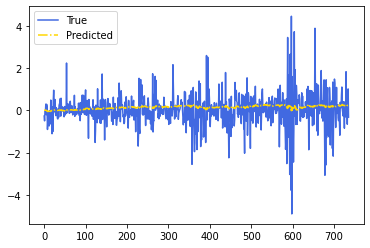

Epoch 25/200, Train Loss: 0.6937, Validation Loss: 0.6933
Epoch 50/200, Train Loss: 0.6935, Validation Loss: 0.6933
Epoch 75/200, Train Loss: 0.6933, Validation Loss: 0.6932
Epoch 100/200, Train Loss: 0.6932, Validation Loss: 0.6931
Epoch 125/200, Train Loss: 0.6930, Validation Loss: 0.6931
Epoch 150/200, Train Loss: 0.6929, Validation Loss: 0.6931
Epoch 175/200, Train Loss: 0.6927, Validation Loss: 0.6931
Epoch 200/200, Train Loss: 0.6925, Validation Loss: 0.6931


Epoch 25/200, Train Loss: 0.6929, Validation Loss: 0.6931
Epoch 50/200, Train Loss: 0.6927, Validation Loss: 0.6932
Epoch 75/200, Train Loss: 0.6926, Validation Loss: 0.6932
Epoch 100/200, Train Loss: 0.6925, Validation Loss: 0.6933
Epoch 125/200, Train Loss: 0.6924, Validation Loss: 0.6934
Epoch 150/200, Train Loss: 0.6921, Validation Loss: 0.6936
Epoch 175/200, Train Loss: 0.6916, Validation Loss: 0.6940
Epoch 200/200, Train Loss: 0.6908, Validation Loss: 0.6948


Epoch 25/200, Train Loss: 0.6936, Validation Loss: 0.6934


In [37]:
Hidden = 256

AAPL_1_model_binary = Bidir_LSTM(len(X_AAPL_1.T), Hidden, 5, 1) 
AAPL_2_model_binary = Bidir_LSTM(len(X_AAPL_2.T), Hidden, 5, 1) 
AAPL_3_model_binary = Bidir_LSTM(len(X_AAPL_3.T), Hidden, 5, 1) 
AAPL_5_model_binary = Bidir_LSTM(len(X_AAPL_5.T), Hidden, 5, 1) 
AAPL_10_model_binary = Bidir_LSTM(len(X_AAPL_10.T), Hidden, 5, 1) 

AAPL_model_daily = LSTM(len(X_AAPL_1.T), Hidden, 1, 1) 
AAPL_model_daily.to(device)

AAPL_1_model_binary.to(device)
AAPL_2_model_binary.to(device)
AAPL_3_model_binary.to(device)
AAPL_5_model_binary.to(device)
AAPL_10_model_binary.to(device)

learning_rate = 1e-5

AAPL_1_model_optimizer_binary = torch.optim.Adam(AAPL_1_model_binary.parameters(), lr = learning_rate)
AAPL_2_model_optimizer_binary = torch.optim.Adam(AAPL_2_model_binary.parameters(), lr = learning_rate)
AAPL_3_model_optimizer_binary = torch.optim.Adam(AAPL_3_model_binary.parameters(), lr = learning_rate)
AAPL_5_model_optimizer_binary = torch.optim.Adam(AAPL_5_model_binary.parameters(), lr = learning_rate)
AAPL_10_model_optimizer_binary = torch.optim.Adam(AAPL_10_model_binary.parameters(), lr = learning_rate)

AAPL_model_daily_opt = torch.optim.Adam(AAPL_model_daily.parameters(), lr = learning_rate)

mse_loss = nn.MSELoss()
BCE_loss_function = nn.BCEWithLogitsLoss()

epochs = 200

train_loss_daily, validation_loss_daily = full_gd(AAPL_model_daily,
                                      mse_loss,
                                      AAPL_model_daily_opt,
                                      x_train, 
                                      y_train, 
                                      x_val,
                                      y_val, 
                                      epochs)

T_d_predictions = helper_funcs.make_predictions(AAPL_model_daily, x_test, y_test, 
                                                T_d, len(X_AAPL_T_d.T), 1, False)

plt.plot(y_test.cpu(), color = 'royalblue', label = 'True')
plt.plot(T_d_predictions, linestyle='-.', color = 'gold',label = 'Predicted')
plt.legend()
plt.show()



train_loss_1_binary, validation_loss_1_binary = full_gd(AAPL_1_model_binary,
                                      BCE_loss_function,
                                      AAPL_1_model_optimizer_binary,
                                      x_train_1, 
                                      y_train_1_binary, 
                                      x_val_1,
                                      y_val_1_binary, 
                                      epochs)
print('\n')
train_loss_2_binary, validation_loss_2_binary = full_gd(AAPL_2_model_binary,
                                      BCE_loss_function,
                                      AAPL_2_model_optimizer_binary,
                                      x_train_2, 
                                      y_train_2_binary, 
                                      x_val_2,
                                      y_val_2_binary, 
                                      epochs)
print('\n')
train_loss_3_binary, validation_loss_3_binary = full_gd(AAPL_3_model_binary,
                                      BCE_loss_function,
                                      AAPL_3_model_optimizer_binary,
                                      x_train_3, 
                                      y_train_3_binary, 
                                      x_val_3,
                                      y_val_3_binary, 
                                      epochs)
print('\n')
train_loss_5_binary, validation_loss_5_binary = full_gd(AAPL_5_model_binary,
                                      BCE_loss_function,
                                      AAPL_5_model_optimizer_binary,
                                      x_train_5, 
                                      y_train_5_binary, 
                                      x_val_5,
                                      y_val_5_binary, 
                                      epochs)
print('\n')
train_loss_10_binary, validation_loss_10_binary = full_gd(AAPL_10_model_binary,
                                      BCE_loss_function,
                                      AAPL_10_model_optimizer_binary,
                                      x_train_10, 
                                      y_train_10_binary, 
                                      x_val_10,
                                      y_val_10_binary, 
                                      epochs)


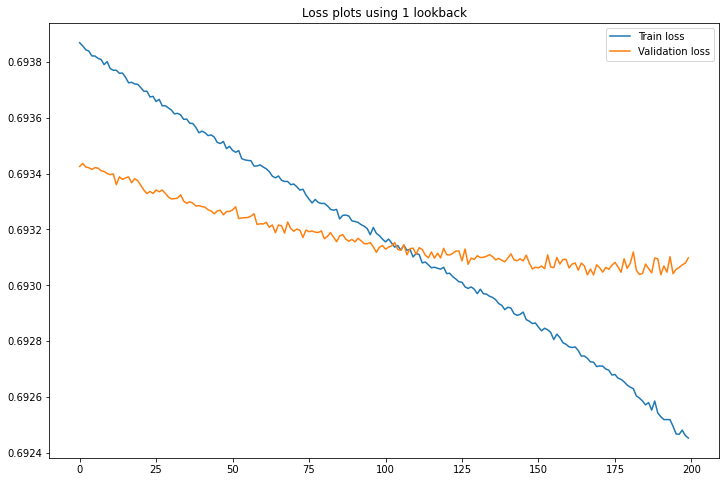

In [38]:
plot_loss_funcs(train_loss_1_binary, validation_loss_1_binary, 1)

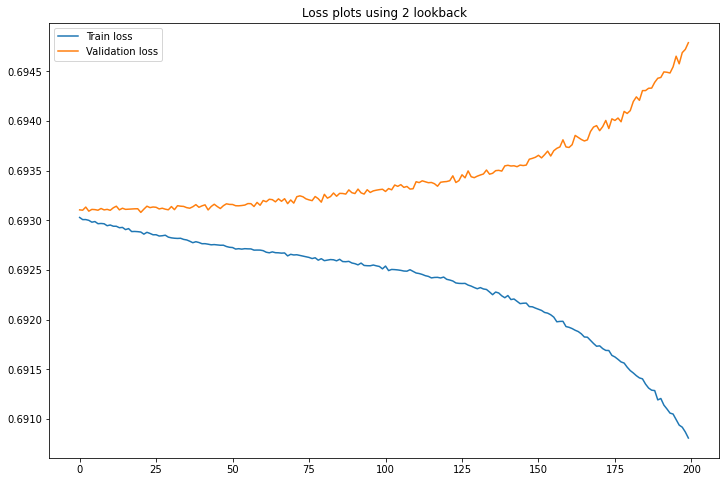

In [39]:
plot_loss_funcs(train_loss_2_binary, validation_loss_2_binary, 2)

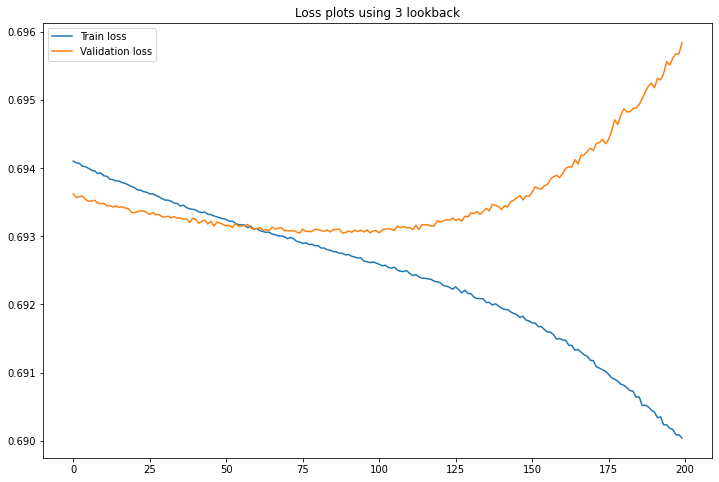

In [40]:
plot_loss_funcs(train_loss_3_binary, validation_loss_3_binary, 3)

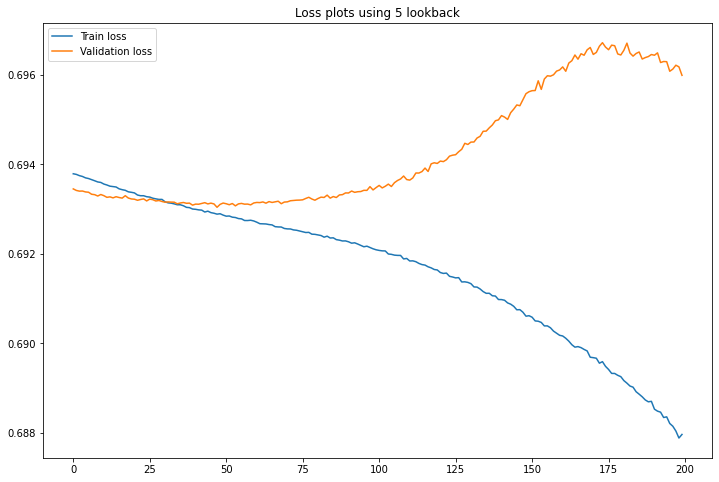

In [41]:
plot_loss_funcs(train_loss_5_binary, validation_loss_5_binary, 5)

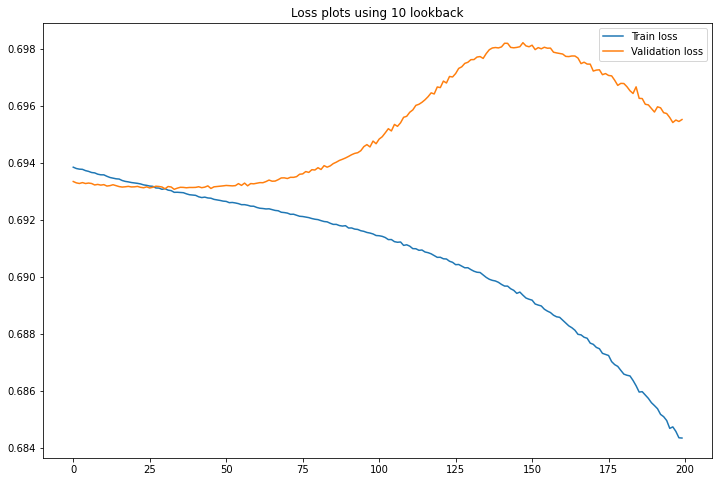

In [42]:
plot_loss_funcs(train_loss_10_binary, validation_loss_10_binary, 10)

### Plot the directional accuracy of each of the models to see if empirically we can see an advantage in which lookback period to use 

In [43]:
# Get the accuracy for each model with different T
with torch.no_grad():
  p_train = AAPL_1_model_binary(x_train_1)
  p_train = (p_train.cpu().numpy() > 0)
  train_acc = np.mean(y_train_1_binary.cpu().numpy() == p_train)

  p_test = AAPL_1_model_binary(x_test_1)
  p_test = (p_test.cpu().numpy() > 0)
  test_acc = np.mean(y_test_1_binary.cpu().numpy() == p_test)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.5152, Test acc: 0.5332


In [44]:
with torch.no_grad():
  p_train = AAPL_2_model_binary(x_train_2)
  p_train = (p_train.cpu().numpy() > 0)
  train_acc = np.mean(y_train_2_binary.cpu().numpy() == p_train)

  p_test = AAPL_2_model_binary(x_test_2)
  p_test = (p_test.cpu().numpy() > 0)
  test_acc = np.mean(y_test_2_binary.cpu().numpy() == p_test)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.5437, Test acc: 0.5332


In [45]:
with torch.no_grad():
  p_train = AAPL_3_model_binary(x_train_3)
  p_train = (p_train.cpu().numpy() > 0)
  train_acc = np.mean(y_train_3_binary.cpu().numpy() == p_train)

  p_test = AAPL_3_model_binary(x_test_3)
  p_test = (p_test.cpu().numpy() > 0)
  test_acc = np.mean(y_test_3_binary.cpu().numpy() == p_test)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.5430, Test acc: 0.5332


In [46]:
with torch.no_grad():
  p_train = AAPL_5_model_binary(x_train_5)
  p_train = (p_train.cpu().numpy() > 0)
  train_acc = np.mean(y_train_5_binary.cpu().numpy() == p_train)

  p_test = AAPL_5_model_binary(x_test_5)
  p_test = (p_test.cpu().numpy() > 0)
  test_acc = np.mean(y_test_5_binary.cpu().numpy() == p_test)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.5406, Test acc: 0.5326


In [47]:
with torch.no_grad():
  p_train = AAPL_10_model_binary(x_train_10)
  p_train = (p_train.cpu().numpy() > 0)
  train_acc = np.mean(y_train_10_binary.cpu().numpy() == p_train)

  p_test = AAPL_10_model_binary(x_test_10)
  p_test = (p_test.cpu().numpy() > 0)
  test_acc = np.mean(y_test_10_binary.cpu().numpy() == p_test)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.5531, Test acc: 0.5388


# Using an LSTM to predict the XOM daily Returns using just the FBM simulations as input 

In [48]:
import sklearn 
from sklearn.metrics import confusion_matrix

In [372]:

x = [i for i in range(1000)]

FBM_sim = pd.read_csv('/content/gdrive/MyDrive/MSc_Thesis/Exon_Mobil_Data/Fractional_Brownian_Motion_simulation.csv', names = x)
XOM_data = pd.read_excel('/content/gdrive/MyDrive/MSc_Thesis/Exon_Mobil_Data/XOM_full_data.xlsx')

observations = XOM_data.set_index(XOM_data['Dates'])
observations = observations[:'2019-10-23']
FBM_sim.set_index(observations.index, inplace=True)

FBM_mean_returns = FBM_sim.mean(axis = 1)

In [373]:
XOM_data['Daily Return'] = XOM_data['XOM Closing price'] / XOM_data['XOM Closing price'].shift(1) - 1 
dates = XOM_data['Dates']
XOM_returns = XOM_data['Daily Return']
XOM_returns = pd.DataFrame(data = XOM_returns.values, index = dates, columns = ['Daily Returns'])


In [374]:
XOM_returns_only = XOM_returns[:'2019-10-23']
XOM_returns_only = XOM_returns_only + 1
XOM_returns_only.dropna(inplace=True)
XOM_returns_only = helper_funcs.scale_dataset(XOM_returns_only, False)

In [375]:
XOM_returns_only

,Daily Returns
Dates,
1999-04-07,0.386932
1999-04-08,0.841458
1999-04-09,0.328302
1999-04-12,0.575177
1999-04-13,-0.219674
...,...
2019-10-17,-0.100949
2019-10-18,-0.485349
2019-10-21,0.972232


In [376]:
FBM_mean_returns = FBM_mean_returns + 1

In [377]:
FBM_mean_returns = pd.DataFrame(FBM_mean_returns, FBM_mean_returns.index, columns = ['FBM Daily Returns'])
pd.to_datetime(FBM_mean_returns.index)

DatetimeIndex(['1999-04-06', '1999-04-07', '1999-04-08', '1999-04-09',
               '1999-04-12', '1999-04-13', '1999-04-14', '1999-04-15',
               '1999-04-16', '1999-04-19',
               ...
               '2019-10-10', '2019-10-11', '2019-10-14', '2019-10-15',
               '2019-10-16', '2019-10-17', '2019-10-18', '2019-10-21',
               '2019-10-22', '2019-10-23'],
              dtype='datetime64[ns]', name='Dates', length=5362, freq=None)

In [378]:
FBM_mean_returns = FBM_mean_returns['1999-04-07':]
FBM_mean_returns = helper_funcs.scale_dataset(FBM_mean_returns, False)
FBM_mean_returns

,FBM Daily Returns
Dates,
1999-04-07,-0.045594
1999-04-08,0.918017
1999-04-09,-0.886228
1999-04-12,-0.220893
1999-04-13,0.139671
...,...
2019-10-17,0.103112
2019-10-18,1.401469
2019-10-21,-0.274608


Shape of X: (5316, 45, 1) Shape of Y: (5316, 1)
Epoch 25/2000, Train Loss: 1.0084, Validation Loss: 0.4180
Epoch 50/2000, Train Loss: 1.0081, Validation Loss: 0.4178
Epoch 75/2000, Train Loss: 1.0078, Validation Loss: 0.4179
Epoch 100/2000, Train Loss: 1.0073, Validation Loss: 0.4184
Epoch 125/2000, Train Loss: 1.0067, Validation Loss: 0.4198
Epoch 150/2000, Train Loss: 1.0062, Validation Loss: 0.4208
Epoch 175/2000, Train Loss: 1.0058, Validation Loss: 0.4212
Epoch 200/2000, Train Loss: 1.0055, Validation Loss: 0.4210
Epoch 225/2000, Train Loss: 1.0050, Validation Loss: 0.4209
Epoch 250/2000, Train Loss: 1.0024, Validation Loss: 0.4236
Epoch 275/2000, Train Loss: 0.9988, Validation Loss: 0.4263
Epoch 300/2000, Train Loss: 0.9940, Validation Loss: 0.4270
Epoch 325/2000, Train Loss: 0.9906, Validation Loss: 0.4287
Epoch 350/2000, Train Loss: 0.9844, Validation Loss: 0.4334
Epoch 375/2000, Train Loss: 0.9798, Validation Loss: 0.4376
Epoch 400/2000, Train Loss: 0.9763, Validation Loss: 0.

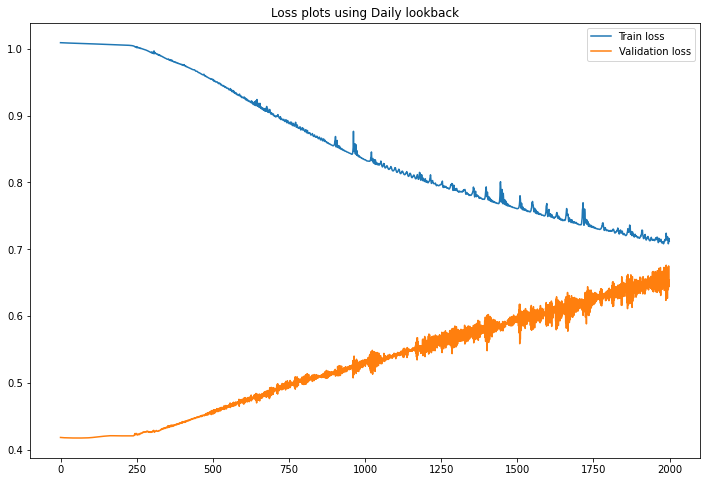

In [380]:
T_daily = 45

#returns_FBM_scaled = helper_funcs.scale_dataset(XOM_returns_only, False) 

X_FBM_daily, Y_FBM_daily = helper_funcs.create_datasets(T_daily, 1, XOM_returns_only.values, 'XOM', FBM_mean_returns.values, False)

X_FBM_daily_train, Y_FBM_daily_train, X_FBM_daily_val, Y_FBM_daily_val, X_FBM_daily_test, Y_FBM_daily_test = helper_funcs.data_split(X_FBM_daily, Y_FBM_daily)
X_FBM_daily_train, Y_FBM_daily_train, X_FBM_daily_val, Y_FBM_daily_val, X_FBM_daily_test, Y_FBM_daily_test = X_FBM_daily_train.to(device), Y_FBM_daily_train.to(device), X_FBM_daily_val.to(device), Y_FBM_daily_val.to(device), X_FBM_daily_test.to(device), Y_FBM_daily_test.to(device)

Hidden = 200
FBM_Daily_model = LSTM(len(X_FBM_daily_train.T), Hidden, 1, 1)
FBM_Daily_model.to(device)
learning_rate = 1e-4
epochs = 2000
mse_loss = nn.MSELoss()

FBM_Daily_model_optimizer = torch.optim.Adam(FBM_Daily_model.parameters(), lr = learning_rate)

FBM_daily_losses_train, FBM_daily_losses_val = full_gd(FBM_Daily_model,
                                                         mse_loss, 
                                                         FBM_Daily_model_optimizer,
                                                         X_FBM_daily_train, 
                                                         Y_FBM_daily_train, 
                                                         X_FBM_daily_val, 
                                                         Y_FBM_daily_val,
                                                         epochs)

plot_loss_funcs(FBM_daily_losses_train, FBM_daily_losses_val, 'Daily')


In [381]:
FBM_daily_preds = helper_funcs.make_predictions(FBM_Daily_model, 
                              X_FBM_daily_test, 
                              Y_FBM_daily_test, 
                              T_daily, 
                              len(X_FBM_daily_test.T), 1, False)


FBM_daily_preds = pd.DataFrame(FBM_daily_preds, index = FBM_mean_returns[int(-1/5*len(FBM_mean_returns)): int(-1/5*len(FBM_mean_returns)) + len(FBM_daily_preds)].index)

FBM_daily_preds.dropna(inplace=True)

In [382]:
FBM_daily_preds

,0
Dates,
2015-09-15,0.368687
2015-09-16,-0.428709
2015-09-17,-0.320671
2015-09-18,-0.108412
2015-09-21,-0.082481
...,...
2019-10-07,-0.153875
2019-10-08,-0.203596
2019-10-09,-0.283298


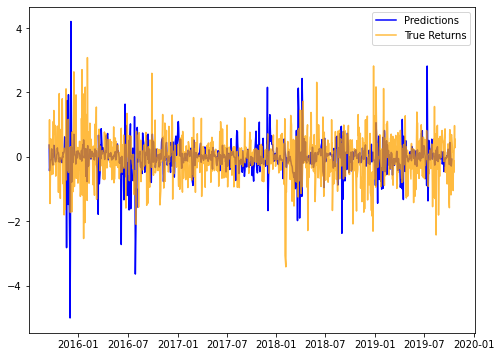

In [383]:
plt.figure(figsize =(8,6))
plt.plot(FBM_daily_preds, label = 'Predictions', color = 'Blue', alpha = 1)
plt.plot(returns_FBM_scaled[int(-1/5*len(FBM_mean_returns)):], label = 'True Returns', color = 'Orange', alpha = 0.75)
plt.legend()
plt.savefig('Predictions using FBM Returns(45d-250H-2500e).png')
plt.show()


In [397]:
# Get the accuracy for each model with different T
with torch.no_grad():
  p_train = FBM_Daily_model(X_FBM_daily_val)
  p_train = (p_train.cpu().numpy() > 0)
  Y_val = (Y_FBM_daily_val.cpu().numpy() > 0)
  train_acc = np.mean(Y_val == p_train)

  p_test = FBM_Daily_model(X_FBM_daily_test)
  p_test = (p_test.cpu().numpy() > 0)
  Y_test = (Y_FBM_daily_test.cpu().numpy() > 0)
  test_acc = np.mean(Y_test == p_test)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

z = FBM_Daily_model(X_FBM_daily_test)
z = z.cpu().detach()
MSE_FBM_alone = mean_squared_error(Y_FBM_daily_test.cpu(), z)
print(f'MSE: {MSE_FBM_alone}')

Train acc: 0.5108, Test acc: 0.4878
MSE: 0.762761652469635


# Using an LSTM to predict the XOM daily Returns using just the XOM Daily Returns as input 

In [386]:
XOM_data = pd.read_excel('/content/gdrive/MyDrive/MSc_Thesis/Exon_Mobil_Data/XOM_full_data.xlsx')
#XOM_returns = XOM_returns
dates = XOM_data['Dates']
XOM_data['Daily Return'] = XOM_data['XOM Closing price'] / XOM_data['XOM Closing price'].shift(1) - 1 
XOM_returns = XOM_data['Daily Return']
XOM_returns = pd.DataFrame(data = XOM_returns.values, index = dates, columns = ['Daily Returns'])
#XOM_returns.dropna(inplace=True)
print(XOM_returns.shape)
print(type(XOM_returns))

XOM_returns.tail()

(5762, 1)
<class 'pandas.core.frame.DataFrame'>


,Daily Returns
Dates,
2021-04-29,0.014283
2021-04-30,-0.028843
2021-05-03,0.027603
2021-05-04,0.006290
2021-05-05,0.017768


In [387]:
returns_XOM = pd.DataFrame(data = XOM_returns.values, index = dates, columns = ['Daily Returns'])
pd.to_datetime(returns_XOM.index)
returns_XOM.dropna(inplace=True)
returns_XOM = returns_XOM + 1
print(returns_XOM.head(10))
print('\n')
print(returns_XOM.tail(10))

# Manually checking if the weekly returns have been computed appropriately

            Daily Returns
Dates                    
1999-04-07       1.006879
1999-04-08       1.014516
1999-04-09       1.005894
1999-04-12       1.010042
1999-04-13       0.996686
1999-04-14       0.986700
1999-04-15       1.045493
1999-04-16       1.030620
1999-04-19       1.028928
1999-04-20       0.981763


            Daily Returns
Dates                    
2021-04-22       0.986964
2021-04-23       1.005428
2021-04-26       1.001979
2021-04-27       1.013111
2021-04-28       1.030137
2021-04-29       1.014283
2021-04-30       0.971157
2021-05-03       1.027603
2021-05-04       1.006290
2021-05-05       1.017768


Shape of X: (5716, 45, 1) Shape of Y: (5716, 1)
Epoch 25/2000, Train Loss: 0.9627, Validation Loss: 0.4438
Epoch 50/2000, Train Loss: 0.9650, Validation Loss: 0.4459
Epoch 75/2000, Train Loss: 0.9623, Validation Loss: 0.4461
Epoch 100/2000, Train Loss: 0.9585, Validation Loss: 0.4484
Epoch 125/2000, Train Loss: 0.9465, Validation Loss: 0.4499
Epoch 150/2000, Train Loss: 0.9243, Validation Loss: 0.4486
Epoch 175/2000, Train Loss: 0.8978, Validation Loss: 0.4451
Epoch 200/2000, Train Loss: 0.8653, Validation Loss: 0.4426
Epoch 225/2000, Train Loss: 0.8415, Validation Loss: 0.4423
Epoch 250/2000, Train Loss: 0.8295, Validation Loss: 0.4421
Epoch 275/2000, Train Loss: 0.8164, Validation Loss: 0.4435
Epoch 300/2000, Train Loss: 0.8011, Validation Loss: 0.4427
Epoch 325/2000, Train Loss: 0.7855, Validation Loss: 0.4438
Epoch 350/2000, Train Loss: 0.7805, Validation Loss: 0.4447
Epoch 375/2000, Train Loss: 0.7743, Validation Loss: 0.4440
Epoch 400/2000, Train Loss: 0.7637, Validation Loss: 0.

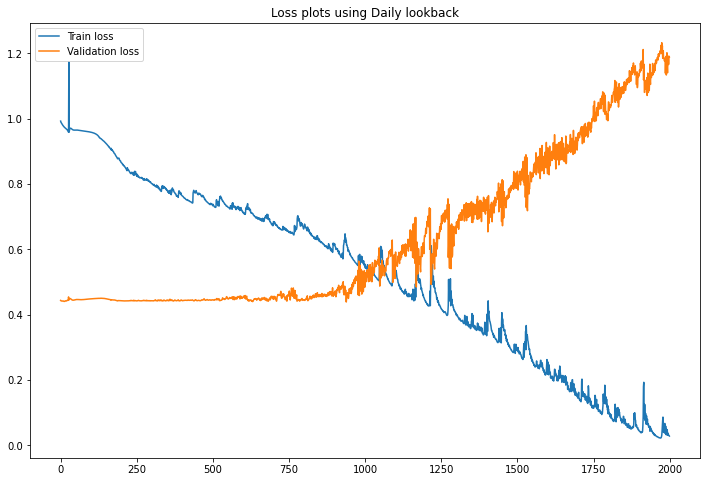

In [388]:
T_daily = 45

returns_XOM_scaled = helper_funcs.scale_dataset(returns_XOM, False) 

X_XOM_daily, Y_XOM_daily = helper_funcs.create_datasets(T_daily, 1, returns_XOM_scaled.values, 'XOM', returns_XOM_scaled.values, False)

X_XOM_daily_train, Y_XOM_daily_train, X_XOM_daily_val, Y_XOM_daily_val, X_XOM_daily_test, Y_XOM_daily_test = helper_funcs.data_split(X_XOM_daily, Y_XOM_daily)
X_XOM_daily_train, Y_XOM_daily_train, X_XOM_daily_val, Y_XOM_daily_val, X_XOM_daily_test, Y_XOM_daily_test = X_XOM_daily_train.to(device), Y_XOM_daily_train.to(device), X_XOM_daily_val.to(device), Y_XOM_daily_val.to(device), X_XOM_daily_test.to(device), Y_XOM_daily_test.to(device)

Hidden = 250
XOM_Daily_model = LSTM(len(X_XOM_daily_train.T), Hidden, 1, 1)
XOM_Daily_model.to(device)
learning_rate = 1e-3
epochs = 2000
mse_loss = nn.MSELoss()

XOM_Daily_model_optimizer = torch.optim.Adam(XOM_Daily_model.parameters(), lr = learning_rate)

XOM_daily_losses_train, XOM_daily_losses_val = full_gd(XOM_Daily_model,
                                                         mse_loss, 
                                                         XOM_Daily_model_optimizer,
                                                         X_XOM_daily_train, 
                                                         Y_XOM_daily_train, 
                                                         X_XOM_daily_val, 
                                                         Y_XOM_daily_val,
                                                         epochs)

plot_loss_funcs(XOM_daily_losses_train, XOM_daily_losses_val, 'Daily')


In [389]:
XOM_daily_preds = helper_funcs.make_predictions(XOM_Daily_model, 
                              X_XOM_daily_test, 
                              Y_XOM_daily_test, 
                              T_daily, 
                              len(X_XOM_daily_test.T), 1, False)


XOM_daily_preds = pd.DataFrame(XOM_daily_preds, index = returns_XOM[int(-1/5*len(returns_XOM)): int(-1/5*len(returns_XOM)) + len(XOM_daily_preds)].index)

XOM_daily_preds.dropna(inplace=True)

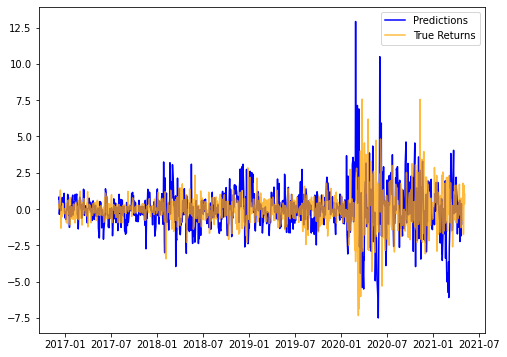

In [390]:
plt.figure(figsize =(8,6))
plt.plot(XOM_daily_preds, label = 'Predictions', color = 'Blue', alpha = 1)
plt.plot(returns_XOM_scaled[int(-1/5*len(returns_XOM)):], label = 'True Returns', color = 'Orange', alpha = 0.75)
plt.legend()
plt.savefig('Predictions using XOM Returns(45d-250H-2500e).png')
plt.show()


In [396]:
# Get the accuracy for each model with different T
with torch.no_grad():
  p_train = XOM_Daily_model(X_XOM_daily_val)
  p_train = (p_train.cpu().numpy() > 0)
  Y_XOM_val = (Y_XOM_daily_val.cpu().numpy() > 0)
  train_acc = np.mean(Y_XOM_val == p_train)

  p_test = XOM_Daily_model(X_XOM_daily_test)
  p_test = (p_test.cpu().numpy() > 0)
  Y_XOM_test = (Y_XOM_daily_test.cpu().numpy() > 0)
  test_acc = np.mean(Y_XOM_test == p_test)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

delta = XOM_Daily_model(X_XOM_daily_test)
delta = delta.cpu().detach()
MSE_XOM_alone = mean_squared_error(Y_XOM_daily_test.cpu(), delta)
print(f'MSE: {MSE_XOM_alone}')

Train acc: 0.4996, Test acc: 0.4886
MSE: 3.8587663173675537


In [65]:
XOM_returns_w = returns_XOM.groupby(pd.Grouper(freq='W')).prod()
XOM_returns_w = XOM_returns_w - 1
XOM_returns_m = returns_XOM.groupby(pd.Grouper(freq='M')).prod()
XOM_returns_m = XOM_returns_m - 1

scaled_XOM_returns_m = helper_funcs.scale_dataset(XOM_returns_m, min=False)
scaled_XOM_returns_w = helper_funcs.scale_dataset(XOM_returns_w, min=False)

print(XOM_returns_w[:10])

            Daily Returns
Dates                    
1999-04-11       0.027515
1999-04-18       0.070293
1999-04-25      -0.020328
1999-05-02       0.060654
1999-05-09      -0.003763
1999-05-16      -0.048338
1999-05-23       0.050794
1999-05-30      -0.034743
1999-06-06       0.010173
1999-06-13      -0.021689


In [66]:
# Checking to see there is no leakage in the actual returns we use 

T = 3
D = len(XOM_returns_w.T)

X_obs = []
Y_obs = []

for i in range(len(XOM_returns_w.values[:5]) - T):
    x = XOM_returns_w.values[i:i + T]
    X_obs.append(x)
    print(f'\n Input data {x}')

    y = XOM_returns_w.values[i + T]
    Y_obs.append(y)
    print(f'\n Targets {y}')

X_obs = np.array(X_obs).reshape(-1, T, D)
Y_obs = np.array(Y_obs).reshape(-1, 1)



 Input data [[ 0.02751501]
 [ 0.07029279]
 [-0.02032836]]

 Targets [0.06065435]

 Input data [[ 0.07029279]
 [-0.02032836]
 [ 0.06065435]]

 Targets [-0.00376343]


In [67]:
# Checking to see if I am computing the autocorrelations correctly. 
# I am computing the lag 1 autocorrelation between x at time t and y at time t + 1

def find_lagged_correlations(dataframe, returns):
    lagged = dataframe.shift(1)
    print(f'X, the input to the LSTM: \n {lagged}')
    check = pd.Series(returns, index=dataframe.index)
    print('\n')
    print(f'Y, the target of the LSTM: \n {check} \n')
    for i in lagged.columns:
        print(f'Correlation between {i} and the Returns: {lagged[i].corr(check)}')

find_lagged_correlations(XOM_returns_w[:8], XOM_returns_w[:8].values.reshape(-1))

X, the input to the LSTM: 
             Daily Returns
Dates                    
1999-04-11            NaN
1999-04-18       0.027515
1999-04-25       0.070293
1999-05-02      -0.020328
1999-05-09       0.060654
1999-05-16      -0.003763
1999-05-23      -0.048338
1999-05-30       0.050794


Y, the target of the LSTM: 
 Dates
1999-04-11    0.027515
1999-04-18    0.070293
1999-04-25   -0.020328
1999-05-02    0.060654
1999-05-09   -0.003763
1999-05-16   -0.048338
1999-05-23    0.050794
1999-05-30   -0.034743
Freq: W-SUN, dtype: float64 

Correlation between Daily Returns and the Returns: -0.490244423082743


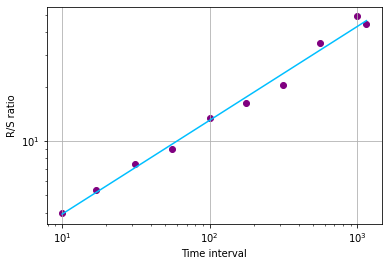

H=0.5194, c=1.1898


In [68]:
# Evaluate Hurst equation
H_w_XOM, c_w_XOM, data_w_XOM = compute_Hc(XOM_returns_w, kind='change', simplified=True)

# Plot
f, ax = plt.subplots()
ax.plot(data_w_XOM[0], c_w_XOM*data_w_XOM[0]**H_w_XOM, color="deepskyblue")
ax.scatter(data_w_XOM[0], data_w_XOM[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H_w_XOM, c_w_XOM))

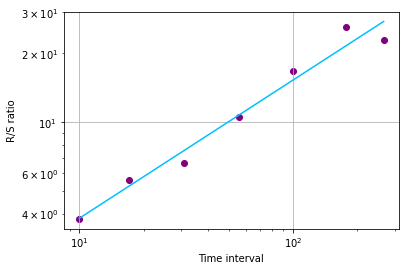

H=0.6004, c=0.9595


In [69]:
# Evaluate Hurst equation
H_m_XOM, c_m_XOM, data_m_XOM = compute_Hc(XOM_returns_m, kind='change', simplified=True)

# Plot
f, ax = plt.subplots()
ax.plot(data_m_XOM[0], c_m_XOM*data_m_XOM[0]**H_m_XOM, color="deepskyblue")
ax.scatter(data_m_XOM[0], data_m_XOM[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H_m_XOM, c_m_XOM))

### Binarising the weekly and monthly XOM returns for a binary classification problem

In [70]:
XOM_weekly_binary_returns = np.zeros(len(XOM_returns_w))

for i in range(len(XOM_returns_w)):
    if XOM_returns_w.values[i] > 0:
        XOM_weekly_binary_returns[i] = 1
    else:
        XOM_weekly_binary_returns[i] = 0

XOM_monthly_binary_returns = np.zeros(len(XOM_returns_m))

for i in range(len(XOM_returns_m)):
    if XOM_returns_m.values[i] > 0:
        XOM_monthly_binary_returns[i] = 1
    else:
        XOM_monthly_binary_returns[i] = 0

In [71]:
len(XOM_returns_w.values.T)

1

In [72]:
XOM_T_Weekly = 6
XOM_T_Monthly = 5

# Pippen
XOM_X_W, XOM_Y_W = helper_funcs.create_datasets(XOM_T_Weekly, 2, XOM_weekly_binary_returns, 'XOM', XOM_returns_w.values, False)
XOM_X_M, XOM_Y_M = helper_funcs.create_datasets(XOM_T_Monthly, 1, XOM_monthly_binary_returns, 'XOM', XOM_returns_m.values, False)

Shape of X: (1147, 6, 1) Shape of Y: (1147, 1)
Shape of X: (261, 5, 1) Shape of Y: (261, 1)


In [73]:
XOM_x_train_w, XOM_y_train_w, XOM_x_val_w, XOM_y_val_w, XOM_x_test_w, XOM_y_test_w = helper_funcs.data_split(XOM_X_W, XOM_Y_W)
XOM_x_train_w, XOM_y_train_w, XOM_x_val_w, XOM_y_val_w, XOM_x_test_w, XOM_y_test_w = XOM_x_train_w.to(device), XOM_y_train_w.to(device), XOM_x_val_w.to(device), XOM_y_val_w.to(device), XOM_x_test_w.to(device), XOM_y_test_w.to(device)

XOM_x_train_m, XOM_y_train_m, XOM_x_val_m, XOM_y_val_m, XOM_x_test_m, XOM_y_test_m = helper_funcs.data_split(XOM_X_M, XOM_Y_M)
XOM_x_train_m, XOM_y_train_m, XOM_x_val_m, XOM_y_val_m, XOM_x_test_m, XOM_y_test_m = XOM_x_train_m.to(device), XOM_y_train_m.to(device), XOM_x_val_m.to(device), XOM_y_val_m.to(device), XOM_x_test_m.to(device), XOM_y_test_m.to(device)

In [74]:
Hidden = 256

# The models taking just the weekly and monthly returns as input 
XOM_model_w_monthly_returns = LSTM(len(XOM_X_M.T), Hidden, 1, 1)
XOM_model_w_weekly_returns = LSTM(len(XOM_X_W.T), Hidden, 1, 1)

# Just returns 
XOM_model_w_monthly_returns.to(device)
XOM_model_w_weekly_returns.to(device)

print(f'Monthly Model: {XOM_model_w_monthly_returns}')
print('\n')
print(f'Weekly Model {XOM_model_w_weekly_returns}')

learning_rate = 5e-4

# Just returns 
XOM_optimizer_w_monthly_returns = torch.optim.Adam(XOM_model_w_monthly_returns.parameters(), lr = learning_rate)
XOM_optimizer_w_weekly_returns = torch.optim.Adam(XOM_model_w_weekly_returns.parameters(), lr = learning_rate)

binary_loss_function = nn.BCEWithLogitsLoss()

epochs = 1000

print('\n')
print('Training on the Monthly Returns')
# Just returns
XOM_train_loss_w_monthly_returns, XOM_val_loss_w_monthly_returns = full_gd(XOM_model_w_monthly_returns,
                                      binary_loss_function,
                                      XOM_optimizer_w_monthly_returns,
                                      XOM_x_train_m, 
                                      XOM_y_train_m, 
                                      XOM_x_val_m,
                                      XOM_y_val_m, 
                                      epochs)

print('\n')
print('Training on the Weekly Returns')
XOM_train_loss_w_weekly_returns, XOM_val_loss_w_weekly_returns = full_gd(XOM_model_w_weekly_returns,
                                      binary_loss_function,
                                      XOM_optimizer_w_weekly_returns,
                                      XOM_x_train_w, 
                                      XOM_y_train_w, 
                                      XOM_x_val_w,
                                      XOM_y_val_w, 
                                      epochs)

Monthly Model: LSTM(
  (rnn): LSTM(1, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


Weekly Model LSTM(
  (rnn): LSTM(1, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


Training on the Monthly Returns
Epoch 25/1000, Train Loss: 0.6911, Validation Loss: 0.6948
Epoch 50/1000, Train Loss: 0.6910, Validation Loss: 0.6952
Epoch 75/1000, Train Loss: 0.6908, Validation Loss: 0.6950
Epoch 100/1000, Train Loss: 0.6901, Validation Loss: 0.6951
Epoch 125/1000, Train Loss: 0.6889, Validation Loss: 0.6955
Epoch 150/1000, Train Loss: 0.6855, Validation Loss: 0.6955
Epoch 175/1000, Train Loss: 0.6826, Validation Loss: 0.6985
Epoch 200/1000, Train Loss: 0.6789, Validation Loss: 0.6970
Epoch 225/1000, Train Loss: 0.6726, Validation Loss: 0.6938
Epoch 250/1000, Train Loss: 0.6683, Validation Loss: 0.6933
Epoch 275/1000, Train Loss: 0.6616, Validation Loss: 0.6846
Epoch 300/1000, Train Loss: 0.6527, Validation Loss: 0.6806
Epoch

In [75]:
y = 0
for x in XOM_y_train_m:
    if x == 1:
        y+=1
z = 0
for x in XOM_y_val_m:
    if x == 1:
        z+=1 

u = 0
for x in XOM_y_test_m:
    if x == 1:
        u+=1       
    
print('Monthly data: \n')
print(f'XOM Train Proportion: {y/len(XOM_y_train_m)}')
print(f'XOM Validation Proportion: {z/len(XOM_y_val_m)}')
print(f'XOM Test Proportion: {u/len(XOM_y_test_m)}')
print('\n')
print(f'XOM Test Monthly - Average of Positive Returns: {(y+u+z)/(len(XOM_y_train_m)+len(XOM_y_val_m) + len(XOM_y_test_m))}')
print('\n')

y = 0
for x in XOM_y_train_w:
    if x == 1:
        y+=1
z = 0
for x in XOM_y_val_w:
    if x == 1:
        z+=1 

u = 0
for x in XOM_y_test_w:
    if x == 1:
        u+=1       
    
print('Weekly data: \n')
print(f'XOM Train Proportion: {y/len(XOM_y_train_w)}')
print(f'XOM Validation Proportion: {z/len(XOM_y_val_w)}')
print(f'XOM Test Proportion: {u/len(XOM_y_test_w)}')
print('\n')
print(f'XOM Test Monthly - Average of Positive Returns: {(y+u+z)/(len(XOM_y_train_w)+len(XOM_y_val_w) + len(XOM_y_test_w))}')
print('\n')

Monthly data: 

XOM Train Proportion: 0.532051282051282
XOM Validation Proportion: 0.5
XOM Test Proportion: 0.4716981132075472


XOM Test Monthly - Average of Positive Returns: 0.5134099616858238


Weekly data: 

XOM Train Proportion: 0.5334302325581395
XOM Validation Proportion: 0.4847161572052402
XOM Test Proportion: 0.4782608695652174


XOM Test Monthly - Average of Positive Returns: 0.5126416739319966




Monthly predictions 

Train acc: 0.9744, Validation acc: 0.5192 , Test acc: 0.4528 

Training 
 TP: 82.0000, TN: 70.0000 , FP: 3.0000. FN: 1.0000
Validation 
 TP: 13.0000, TN: 14.0000 , FP: 12.0000. FN: 13.0000
Test 
 TP: 15.0000, TN: 9.0000 , FP: 19.0000. FN: 10.0000
Monthly XOM Training Data 

Normalized confusion matrix
[[0.95890411 0.04109589]
 [0.01204819 0.98795181]]


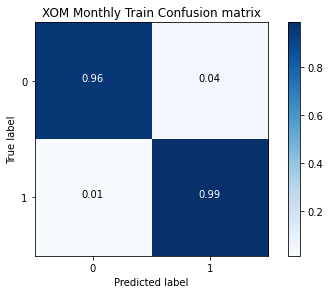

Monthly XOM Validation Data 

Normalized confusion matrix
[[0.53846154 0.46153846]
 [0.5        0.5       ]]


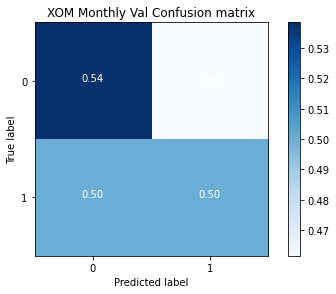

Monthly XOM Test Data 

Normalized confusion matrix
[[0.32142857 0.67857143]
 [0.4        0.6       ]]


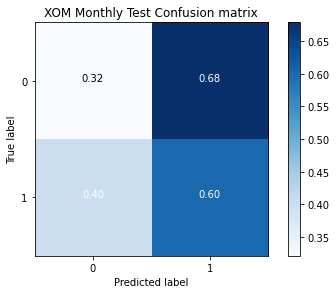

In [76]:
print('Monthly predictions \n')
# Get the accuracy for each model with different T
XOM_model_w_monthly_returns.eval()
with torch.no_grad():
  p_train = XOM_model_w_monthly_returns(XOM_x_train_m)
  p_train = (p_train.cpu().numpy() > 0)
  train_acc_m_just_returns = np.mean(XOM_y_train_m.cpu().numpy() == p_train)

  p_val = XOM_model_w_monthly_returns(XOM_x_val_m)
  p_val = (p_val.cpu().numpy() > 0)
  val_acc_m_just_returns = np.mean(XOM_y_val_m.cpu().numpy() == p_val)

  p_test = XOM_model_w_monthly_returns(XOM_x_test_m)
  p_test = (p_test.cpu().numpy() > 0)
  test_acc_m_just_returns = np.mean(XOM_y_test_m.cpu().numpy() == p_test)

train_tn, train_fp, train_fn, train_tp = confusion_matrix(XOM_y_train_m.cpu().numpy(), p_train).ravel()
val_tn, val_fp, val_fn, val_tp = confusion_matrix(XOM_y_val_m.cpu().numpy(), p_val).ravel()
test_tn, test_fp, test_fn, test_tp = confusion_matrix(XOM_y_test_m.cpu().numpy(), p_test).ravel()

print(f"Train acc: {train_acc_m_just_returns:.4f}, Validation acc: {val_acc_m_just_returns:.4f} , Test acc: {test_acc_m_just_returns:.4f} \n")
print(f"Training \n TP: {train_tp:.4f}, TN: {train_tn:.4f} , FP: {train_fp:.4f}. FN: {train_fn:.4f}")
print(f"Validation \n TP: {val_tp:.4f}, TN: {val_tn:.4f} , FP: {val_fp:.4f}. FN: {val_fn:.4f}")
print(f"Test \n TP: {test_tp:.4f}, TN: {test_tn:.4f} , FP: {test_fp:.4f}. FN: {test_fn:.4f}")

# Monthly XOM Training Data
print('Monthly XOM Training Data \n')
cm = confusion_matrix(XOM_y_train_m.cpu().numpy(), p_train)
plot_confusion_matrix("XOM", "Monthly", "Train", False, cm, list(range(2)), normalize=True)

# Monthly XOM Validation Data
print('Monthly XOM Validation Data \n')
cm = confusion_matrix(XOM_y_val_m.cpu().numpy(), p_val)
plot_confusion_matrix("XOM", "Monthly", "Val", False, cm, list(range(2)), normalize=True)

# Monthly XOM Test Data
print('Monthly XOM Test Data \n')
cm = confusion_matrix(XOM_y_test_m.cpu().numpy(), p_test)
plot_confusion_matrix("XOM", "Monthly", "Test",False, cm, list(range(2)), normalize=True)

Weekly predictions 

Train acc: 0.6831, Validation acc: 0.5240 , Test acc: 0.4870

Training 
 TP: 304.0000, TN: 166.0000 , FP: 155.0000. FN: 63.0000
Validation 
 TP: 80.0000, TN: 40.0000 , FP: 78.0000. FN: 31.0000
Test 
 TP: 79.0000, TN: 33.0000 , FP: 87.0000. FN: 31.0000
Weekly XOM Training Data 

Normalized confusion matrix
[[0.51713396 0.48286604]
 [0.17166213 0.82833787]]


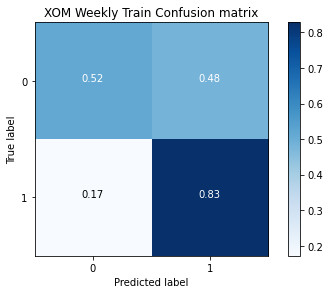

Weekly XOM Validation Data 

Normalized confusion matrix
[[0.33898305 0.66101695]
 [0.27927928 0.72072072]]


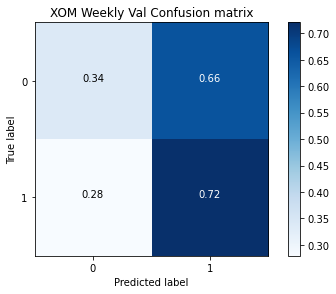

Weekly XOM Test Data 

Normalized confusion matrix
[[0.275      0.725     ]
 [0.28181818 0.71818182]]


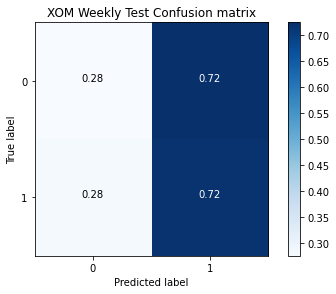

In [77]:
print('Weekly predictions \n')
# Get the accuracy for each model with different T
XOM_model_w_weekly_returns.eval()
with torch.no_grad():
  p_train = XOM_model_w_weekly_returns(XOM_x_train_w)
  p_train = (p_train.cpu().numpy() > 0)
  train_acc_w_just_returns = np.mean(XOM_y_train_w.cpu().numpy() == p_train)

  p_val = XOM_model_w_weekly_returns(XOM_x_val_w)
  p_val = (p_val.cpu().numpy() > 0)
  val_acc_w_just_returns = np.mean(XOM_y_val_w.cpu().numpy() == p_val)

  p_test = XOM_model_w_weekly_returns(XOM_x_test_w)
  p_test = (p_test.cpu().numpy() > 0)
  test_acc_w_just_returns = np.mean(XOM_y_test_w.cpu().numpy() == p_test)

train_tn, train_fp, train_fn, train_tp = confusion_matrix(XOM_y_train_w.cpu().numpy(), p_train).ravel()
val_tn, val_fp, val_fn, val_tp = confusion_matrix(XOM_y_val_w.cpu().numpy(), p_val).ravel()
test_tn, test_fp, test_fn, test_tp = confusion_matrix(XOM_y_test_w.cpu().numpy(), p_test).ravel()

print(f"Train acc: {train_acc_w_just_returns:.4f}, Validation acc: {val_acc_w_just_returns:.4f} , Test acc: {test_acc_w_just_returns:.4f}\n")
print(f"Training \n TP: {train_tp:.4f}, TN: {train_tn:.4f} , FP: {train_fp:.4f}. FN: {train_fn:.4f}")
print(f"Validation \n TP: {val_tp:.4f}, TN: {val_tn:.4f} , FP: {val_fp:.4f}. FN: {val_fn:.4f}")
print(f"Test \n TP: {test_tp:.4f}, TN: {test_tn:.4f} , FP: {test_fp:.4f}. FN: {test_fn:.4f}")

cm = confusion_matrix(XOM_y_train_w.cpu().numpy(), p_train)

# Weekly XOM Training Data
print('Weekly XOM Training Data \n')
cm = confusion_matrix(XOM_y_train_w.cpu().numpy(), p_train)
plot_confusion_matrix("XOM", "Weekly", "Train", False, cm, list(range(2)), normalize=True)

# Weekly XOM Validation Data
print('Weekly XOM Validation Data \n')
cm = confusion_matrix(XOM_y_val_w.cpu().numpy(), p_val)
plot_confusion_matrix("XOM", "Weekly", "Val", False, cm, list(range(2)), normalize=True)

# Weekly XOM Test Data
print('Weekly XOM Test Data \n')
cm = confusion_matrix(XOM_y_test_w.cpu().numpy(), p_test)
plot_confusion_matrix("XOM", "Weekly", "Test", False, cm, list(range(2)), normalize=True)


# Now going to look at the 'Filtered features' whose autocorrelation exceeds a given threshold

In [78]:
MISC_full_data = pd.read_excel('/content/gdrive/MyDrive/MSc_Thesis/Exon_Mobil_Data/Misc_full_data.xlsx', index_col = 'Dates')
MISC_full_data = MISC_full_data.loc['1999-04-07':]
print(returns_XOM.head(), returns_XOM.tail())

MISC_full_data.head()

            Daily Returns
Dates                    
1999-04-07       1.006879
1999-04-08       1.014516
1999-04-09       1.005894
1999-04-12       1.010042
1999-04-13       0.996686             Daily Returns
Dates                    
2021-04-29       1.014283
2021-04-30       0.971157
2021-05-03       1.027603
2021-05-04       1.006290
2021-05-05       1.017768


,VIX Closing price,VIX Opening price,VIX PX_HIGH,VIX PX_LOW,VIX VOLATILITY_10D,VIX VOLATILITY_30D,DJIA Closing price,DJIA Opening price,DJIA High price,DJIA Low price,DJIA VOLATILITY_10D,DJIA VOLATILITY_30D,DJIA Price_earning ratio,DJIA Price_book_ratio,DJIA Price_sales_ratio,EUR-USD Exchange,Oil Closing price,Oil opening price,Oil bid price,Oil ask price,Oil high price,Oil low price,Oil VOLATILITY_10D,Oil VOLATILITY_30D,Three Month Interest Rate,Gold/Dollar Closing price,Gold/Dollar Opening price,Gold/Dollar Bid price,Gold/Dollar ask price,Gold/Dollar High price,Gold/Dollar Low price,Gold/Dollar VOLATILITY_10D,Gold/Dollar VOLATILITY_30D,Pound/Dollar Closing price,Pound/Dollar Opening price,Pound/Dollar Bid price,Pound/Dollar Ask price,Pound/Dollar High price,Pound/Dollar Low price,Pound/Dollar VOLATILITY_10D,Pound/Dollar VOLATILITY_30D
Dates,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-04-07,22.81,22.53,23.26,22.10,59.75,65.83,10085.31,9963.49,10089.75,9955.16,19.80,18.25,22.7714,4.4619,1.6404,1.0775,16.03,16.78,16.52,15.55,16.79,15.98,39.05,36.15,4.413,280.55,280.05,280.3,280.8,281.55,279.75,8.87,9.82,1.5962,1.5913,1.5958,1.5968,1.5991,1.5879,4.89,6.27
1999-04-08,22.59,23.38,23.51,22.01,40.86,64.93,10197.70,10086.42,10209.08,10059.78,18.75,18.33,23.0252,4.5117,1.6586,1.0742,15.83,16.06,16.52,15.55,16.25,15.61,38.67,36.68,4.392,280.65,280.25,280.4,280.9,282.35,279.45,5.48,9.81,1.6062,1.5957,1.6057,1.6067,1.6121,1.5930,6.51,6.55
1999-04-09,21.77,22.16,22.59,21.55,43.71,65.52,10173.83,10197.70,10212.13,10094.47,18.84,18.18,22.9713,4.5011,1.6548,1.0797,16.57,15.85,16.52,15.55,16.84,15.85,42.84,36.16,4.349,281.55,280.40,281.3,281.8,282.25,279.55,5.62,9.87,1.6105,1.6052,1.6101,1.6108,1.6109,1.6008,6.34,6.51
1999-04-12,21.93,21.13,23.41,20.47,44.25,65.22,10339.51,10174.11,10340.62,10096.69,18.25,18.59,23.8889,4.6505,1.6929,1.0804,16.40,16.74,16.52,15.55,16.74,16.33,42.45,36.49,4.317,282.85,281.95,282.6,283.1,284.35,281.90,5.31,9.98,1.6120,1.6073,1.6115,1.6125,1.6191,1.6050,6.28,6.33
1999-04-13,22.73,22.16,23.35,22.01,46.46,65.59,10395.01,10340.62,10418.87,10316.47,16.46,18.49,24.0171,4.6755,1.7020,1.0782,16.72,16.47,16.52,15.55,16.80,16.42,42.07,36.42,4.268,283.35,282.45,283.1,283.6,284.25,282.40,5.25,10.00,1.6168,1.6120,1.6165,1.6170,1.6172,1.6109,6.46,6.35


In [ ]:

#returns_XOM['AAPL 2 Day Price Return'] = returns_XOM['PX_LAST'] / returns_XOM['PX_LAST'].shift(2)  - 1
#returns_XOM['AAPL 3 Day Price Return'] = returns_XOM['PX_LAST'] / returns_XOM['PX_LAST'].shift(3)  - 1
#returns_XOM['AAPL 5 Day Price Return'] = returns_XOM['PX_LAST'] / returns_XOM['PX_LAST'].shift(5)  - 1

MISC_full_data['Oil Previous Close'] = MISC_full_data['Oil Closing price'].shift(1)

#MISC_full_data['Oil 2 Day Price Return'] = MISC_full_data['Oil Closing price'] / MISC_full_data['Oil Closing price'].shift(2)  - 1
#MISC_full_data['Oil 3 Day Price Return'] = MISC_full_data['Oil Closing price'] / MISC_full_data['Oil Closing price'].shift(3)  - 1
#MISC_full_data['Oil 5 Day Price Return'] = MISC_full_data['Oil Closing price'] / MISC_full_data['Oil Closing price'].shift(5)  - 1
MISC_full_data['Oil Delta'] = MISC_full_data['Oil Closing price'] - MISC_full_data['Oil opening price']  - 1
MISC_full_data['Gold/Dollar Previous Close'] = MISC_full_data['Gold/Dollar Closing price'].shift(1)
#MISC_full_data['Gold/Dollar 2 Day Price Return'] = MISC_full_data['Gold/Dollar Closing price'] / MISC_full_data['Gold/Dollar Closing price'].shift(2)  - 1
#MISC_full_data['Gold/Dollar 3 Day Price Return'] = MISC_full_data['Gold/Dollar Closing price'] / MISC_full_data['Gold/Dollar Closing price'].shift(3)  - 1
#MISC_full_data['Gold/Dollar 5 Day Price Return'] = MISC_full_data['Gold/Dollar Closing price'] / MISC_full_data['Gold/Dollar Closing price'].shift(5)  - 1
MISC_full_data['DJIA Previous Close'] = MISC_full_data['DJIA Closing price'].shift(1)
MISC_full_data['Pound/Dollar Previous Close'] = MISC_full_data['Pound/Dollar Closing price'].shift(1)
MISC_full_data['DJIA Daily Returns'] = MISC_full_data['DJIA Closing price'] / MISC_full_data['DJIA Previous Close'] 
#MISC_full_data['DJIA 2 Day Price Return'] = MISC_full_data['DJIA Closing price'] / MISC_full_data['DJIA Closing price'].shift(2)  - 1
#MISC_full_data['DJIA 3 Day Price Return'] = MISC_full_data['DJIA Closing price'] / MISC_full_data['DJIA Closing price'].shift(3)  - 1
#MISC_full_data['DJIA 5 Day Price Return'] = MISC_full_data['DJIA Closing price'] / MISC_full_data['DJIA Closing price'].shift(5)  - 1


In [80]:

MISC_full_data['Dates'] = MISC_full_data.index
pd.to_datetime(MISC_full_data['Dates'])
MISC_full_data['Year'] = MISC_full_data['Dates'].dt.year
MISC_full_data['Month'] = MISC_full_data['Dates'].dt.month
MISC_full_data['Day'] = MISC_full_data['Dates'].dt.day
MISC_full_data['Year_sin'] = sin_transform(MISC_full_data['Year'].values, timeframe='year')
MISC_full_data['Year_cos'] = cos_transform(MISC_full_data['Year'].values, timeframe='year')
MISC_full_data['Month_sin'] = sin_transform(MISC_full_data['Month'].values, timeframe='month')
MISC_full_data['Month_cos'] = cos_transform(MISC_full_data['Month'].values, timeframe='month')
MISC_full_data['Day_sin'] = sin_transform(MISC_full_data['Day'].values, timeframe='day')
MISC_full_data['Day_cos'] = cos_transform(MISC_full_data['Day'].values, timeframe='day')

MISC_full_data.drop(columns=['Dates', 'Year', 'Month', 'Day'], inplace=True)
MISC_full_data.dropna(inplace=True)
MISC_full_data.head()

,VIX Closing price,VIX Opening price,VIX PX_HIGH,VIX PX_LOW,VIX VOLATILITY_10D,VIX VOLATILITY_30D,DJIA Closing price,DJIA Opening price,DJIA High price,DJIA Low price,DJIA VOLATILITY_10D,DJIA VOLATILITY_30D,DJIA Price_earning ratio,DJIA Price_book_ratio,DJIA Price_sales_ratio,EUR-USD Exchange,Oil Closing price,Oil opening price,Oil bid price,Oil ask price,Oil high price,Oil low price,Oil VOLATILITY_10D,Oil VOLATILITY_30D,Three Month Interest Rate,Gold/Dollar Closing price,Gold/Dollar Opening price,Gold/Dollar Bid price,Gold/Dollar ask price,Gold/Dollar High price,Gold/Dollar Low price,Gold/Dollar VOLATILITY_10D,Gold/Dollar VOLATILITY_30D,Pound/Dollar Closing price,Pound/Dollar Opening price,Pound/Dollar Bid price,Pound/Dollar Ask price,Pound/Dollar High price,Pound/Dollar Low price,Pound/Dollar VOLATILITY_10D,Pound/Dollar VOLATILITY_30D,Oil Previous Close,Oil Delta,Gold/Dollar Previous Close,DJIA Previous Close,Pound/Dollar Previous Close,DJIA Daily Returns,Year_sin,Year_cos,Month_sin,Month_cos,Day_sin,Day_cos
Dates,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-04-08,22.59,23.38,23.51,22.01,40.86,64.93,10197.70,10086.42,10209.08,10059.78,18.75,18.33,23.0252,4.5117,1.6586,1.0742,15.83,16.06,16.52,15.55,16.25,15.61,38.67,36.68,4.392,280.65,280.25,280.4,280.9,282.35,279.45,5.48,9.81,1.6062,1.5957,1.6057,1.6067,1.6121,1.5930,6.51,6.55,16.03,-1.23,280.55,10085.31,1.5962,1.011144,0.101168,-0.994869,0.724793,0.688967,0.998717,-0.050649
1999-04-09,21.77,22.16,22.59,21.55,43.71,65.52,10173.83,10197.70,10212.13,10094.47,18.84,18.18,22.9713,4.5011,1.6548,1.0797,16.57,15.85,16.52,15.55,16.84,15.85,42.84,36.16,4.349,281.55,280.40,281.3,281.8,282.25,279.55,5.62,9.87,1.6105,1.6052,1.6101,1.6108,1.6109,1.6008,6.34,6.51,15.83,-0.28,280.65,10197.70,1.6062,0.997659,0.101168,-0.994869,0.724793,0.688967,0.968077,-0.250653
1999-04-12,21.93,21.13,23.41,20.47,44.25,65.22,10339.51,10174.11,10340.62,10096.69,18.25,18.59,23.8889,4.6505,1.6929,1.0804,16.40,16.74,16.52,15.55,16.74,16.33,42.45,36.49,4.317,282.85,281.95,282.6,283.1,284.35,281.90,5.31,9.98,1.6120,1.6073,1.6115,1.6125,1.6191,1.6050,6.28,6.33,16.57,-1.34,281.55,10173.83,1.6105,1.016285,0.101168,-0.994869,0.724793,0.688967,0.651372,-0.758758
1999-04-13,22.73,22.16,23.35,22.01,46.46,65.59,10395.01,10340.62,10418.87,10316.47,16.46,18.49,24.0171,4.6755,1.7020,1.0782,16.72,16.47,16.52,15.55,16.80,16.42,42.07,36.42,4.268,283.35,282.45,283.1,283.6,284.25,282.40,5.25,10.00,1.6168,1.6120,1.6165,1.6170,1.6172,1.6109,6.46,6.35,16.40,-0.75,282.85,10339.51,1.6120,1.005368,0.101168,-0.994869,0.724793,0.688967,0.485302,-0.874347
1999-04-14,24.94,23.33,24.96,23.07,67.88,72.29,10411.66,10394.73,10526.54,10367.81,12.67,18.40,24.0556,4.6830,1.7047,1.0802,16.47,16.73,16.52,16.59,16.76,16.12,42.80,36.45,4.278,281.45,283.50,281.2,281.7,284.40,280.75,6.79,10.00,1.6113,1.6165,1.6120,1.6125,1.6211,1.6105,5.92,6.40,16.72,-1.26,283.35,10395.01,1.6168,1.001602,0.101168,-0.994869,0.724793,0.688967,0.299363,-0.954139


In [81]:
MISC_full_data['DJIA Closing price'].groupby(MISC_full_data.index.strftime('%Y-%m')).tail(1)

Dates
1999-04-30    10789.04
1999-05-31    10559.75
1999-06-30    10970.81
1999-07-30    10655.15
1999-08-31    10829.28
                ...   
2021-01-29    29982.62
2021-02-26    30932.37
2021-03-31    32981.55
2021-04-30    33874.85
2021-05-05    34057.78
Name: DJIA Closing price, Length: 266, dtype: float64

In [82]:
XOM_returns_m = returns_XOM.groupby(pd.Grouper(freq='M')).prod()
XOM_returns_w = returns_XOM.groupby(pd.Grouper(freq='W')).prod()

DJIA_returns_monthly = MISC_full_data['DJIA Daily Returns'].groupby(pd.Grouper(freq='M')).prod()
DJIA_returns_weekly = MISC_full_data['DJIA Daily Returns'].groupby(pd.Grouper(freq='W')).prod()

MISC_full_data.drop(columns = ['DJIA Daily Returns', 'VIX Closing price', 'VIX Opening price',
                               'VIX PX_HIGH', 'VIX PX_LOW','DJIA Closing price', 'DJIA Opening price',	
                               'DJIA High price', 'DJIA Low price',  'Oil Closing price', 'Oil opening price',
                               'Oil bid price',	'Oil ask price', 'Oil high price', 'Oil low price',
                               'Gold/Dollar Closing price',	'Gold/Dollar Opening price', 'Gold/Dollar Bid price',	
                               'Gold/Dollar ask price',	'Gold/Dollar High price', 'Gold/Dollar Low price',
                               'Pound/Dollar Closing price', 'Pound/Dollar Opening price', 'Pound/Dollar Bid price',	
                               'Pound/Dollar Ask price','Pound/Dollar High price', 'Pound/Dollar Low price'], 
                                inplace=True) 
                            
MISC_Monthly = MISC_full_data.groupby(pd.Grouper(freq='M')).mean()
MISC_Weekly = MISC_full_data.groupby(pd.Grouper(freq='W')).mean()

Scaled_MISC_Monthly = helper_funcs.scale_dataset(MISC_Monthly, min=False) 
Scaled_MISC_Weekly = helper_funcs.scale_dataset(MISC_Weekly, min=False)

Scaled_MISC_Monthly = Scaled_MISC_Monthly.join(XOM_returns_m, how = 'left')
Scaled_MISC_Monthly = Scaled_MISC_Monthly.join(DJIA_returns_monthly, how = 'left')

Scaled_MISC_Weekly = Scaled_MISC_Weekly.join(XOM_returns_w, how = 'left')
Scaled_MISC_Weekly = Scaled_MISC_Weekly.join(DJIA_returns_weekly, how = 'left')
 
Scaled_MISC_Monthly.dropna(inplace=True)
Scaled_MISC_Weekly.dropna(inplace=True)

print(Scaled_MISC_Monthly.shape)
print(XOM_returns_m.shape)
print('\n')
print(Scaled_MISC_Weekly.shape)
print(XOM_returns_w.shape)

(266, 28)
(266, 1)


(1153, 28)
(1153, 1)


In [83]:
Scaled_MISC_Monthly['XOM Monthly Returns'] = Scaled_MISC_Monthly['Daily Returns']  
Scaled_MISC_Monthly['DJIA Monthly Returns'] = Scaled_MISC_Monthly['DJIA Daily Returns']

Scaled_MISC_Monthly['2 Month Return'] = Scaled_MISC_Monthly['XOM Monthly Returns'] / Scaled_MISC_Monthly['XOM Monthly Returns'].shift(2)  
Scaled_MISC_Monthly['3 Month Return'] = Scaled_MISC_Monthly['XOM Monthly Returns'] / Scaled_MISC_Monthly['XOM Monthly Returns'].shift(3)  
Scaled_MISC_Monthly['5 Month Return'] = Scaled_MISC_Monthly['XOM Monthly Returns'] / Scaled_MISC_Monthly['XOM Monthly Returns'].shift(5) 

Scaled_MISC_Monthly['DJIA 2 Month Return'] = Scaled_MISC_Monthly['DJIA Monthly Returns'] / Scaled_MISC_Monthly['DJIA Monthly Returns'].shift(2)  
Scaled_MISC_Monthly['DJIA 3 Month Return'] = Scaled_MISC_Monthly['DJIA Monthly Returns'] / Scaled_MISC_Monthly['DJIA Monthly Returns'].shift(3)  
Scaled_MISC_Monthly['DJIA 5 Month Return'] = Scaled_MISC_Monthly['DJIA Monthly Returns'] / Scaled_MISC_Monthly['DJIA Monthly Returns'].shift(5)  

Scaled_MISC_Monthly['Oil Monthly Return'] = Scaled_MISC_Monthly['Oil Previous Close'] / Scaled_MISC_Monthly['Oil Previous Close'].shift(1) 
Scaled_MISC_Monthly['Oil 2 Month Return'] = Scaled_MISC_Monthly['Oil Monthly Return'] / Scaled_MISC_Monthly['Oil Monthly Return'].shift(2)  
Scaled_MISC_Monthly['Oil 3 Month Return'] = Scaled_MISC_Monthly['Oil Monthly Return'] / Scaled_MISC_Monthly['Oil Monthly Return'].shift(3)  
Scaled_MISC_Monthly['Oil 5 Month Return'] = Scaled_MISC_Monthly['Oil Monthly Return'] / Scaled_MISC_Monthly['Oil Monthly Return'].shift(5)  

Scaled_MISC_Monthly['Gold/Dollar Change'] = Scaled_MISC_Monthly['Gold/Dollar Previous Close'] / Scaled_MISC_Monthly['Gold/Dollar Previous Close'].shift(1)  
Scaled_MISC_Monthly['Gold/Dollar 2 Month Change'] = Scaled_MISC_Monthly['Gold/Dollar Change'] / Scaled_MISC_Monthly['Gold/Dollar Change'].shift(2)  
Scaled_MISC_Monthly['Gold/Dollar 5 Month Change'] = Scaled_MISC_Monthly['Gold/Dollar Change'] / Scaled_MISC_Monthly['Gold/Dollar Change'].shift(5)  
Scaled_MISC_Monthly['Gold/Dollar 3 Month Change'] = Scaled_MISC_Monthly['Gold/Dollar Change'] / Scaled_MISC_Monthly['Gold/Dollar Change'].shift(3)  

Scaled_MISC_Monthly['Pound/Dollar Monthly Change'] = Scaled_MISC_Monthly['Pound/Dollar Previous Close'] / Scaled_MISC_Monthly['Pound/Dollar Previous Close'].shift(1)  
Scaled_MISC_Monthly['Pound/Dollar 2 Month Change'] = Scaled_MISC_Monthly['Pound/Dollar Monthly Change'] / Scaled_MISC_Monthly['Pound/Dollar Monthly Change'].shift(2)  
Scaled_MISC_Monthly['Pound/Dollar 3 Month Change'] = Scaled_MISC_Monthly['Pound/Dollar Monthly Change'] / Scaled_MISC_Monthly['Pound/Dollar Monthly Change'].shift(3) 
Scaled_MISC_Monthly['Pound/Dollar 5 Month Change'] = Scaled_MISC_Monthly['Pound/Dollar Monthly Change'] / Scaled_MISC_Monthly['Pound/Dollar Monthly Change'].shift(5)  

Scaled_MISC_Monthly['1 Period Change in 3 Month Interest Rate'] = Scaled_MISC_Monthly['Three Month Interest Rate'] / Scaled_MISC_Monthly['Three Month Interest Rate'].shift(1)  
Scaled_MISC_Monthly['2 Period Change in 3 Month Interest Rate'] = Scaled_MISC_Monthly['Three Month Interest Rate'] / Scaled_MISC_Monthly['Three Month Interest Rate'].shift(2)  
Scaled_MISC_Monthly['3 Period Change in 3 Month Interest Rate'] = Scaled_MISC_Monthly['Three Month Interest Rate'] / Scaled_MISC_Monthly['Three Month Interest Rate'].shift(3)  
Scaled_MISC_Monthly['5 Period Change in 3 Month Interest Rate'] = Scaled_MISC_Monthly['Three Month Interest Rate'] / Scaled_MISC_Monthly['Three Month Interest Rate'].shift(5)  

Scaled_MISC_Monthly.drop(columns = ['Daily Returns', 'DJIA Daily Returns'], inplace=True)
Scaled_MISC_Monthly.dropna(inplace=True)

In [84]:
print(XOM_returns_m['1999-10-31':'2000-02-29'])

print(Scaled_MISC_Monthly['XOM Monthly Returns']['1999-10-31':'2000-02-29'])


            Daily Returns
Dates                    
1999-10-31       0.974508
1999-11-30       1.070886
1999-12-31       1.015760
2000-01-31       1.028703
2000-02-29       0.908749
Dates
1999-10-31    0.974508
1999-11-30    1.070886
1999-12-31    1.015760
2000-01-31    1.028703
2000-02-29    0.908749
Freq: M, Name: XOM Monthly Returns, dtype: float64


In [85]:
Scaled_MISC_Weekly['XOM Weekly Returns'] = Scaled_MISC_Weekly['Daily Returns']  
Scaled_MISC_Weekly['DJIA Weekly Returns'] = Scaled_MISC_Weekly['DJIA Daily Returns']

Scaled_MISC_Weekly['2 Week Return'] = Scaled_MISC_Weekly['XOM Weekly Returns'] / Scaled_MISC_Weekly['XOM Weekly Returns'].shift(2)  
Scaled_MISC_Weekly['3 Week Return'] = Scaled_MISC_Weekly['XOM Weekly Returns'] / Scaled_MISC_Weekly['XOM Weekly Returns'].shift(3)  
Scaled_MISC_Weekly['5 Week Return'] = Scaled_MISC_Weekly['XOM Weekly Returns'] / Scaled_MISC_Weekly['XOM Weekly Returns'].shift(5)  

Scaled_MISC_Weekly['DJIA 2 Week Return'] = Scaled_MISC_Weekly['DJIA Weekly Returns'] / Scaled_MISC_Weekly['DJIA Weekly Returns'].shift(2)  
Scaled_MISC_Weekly['DJIA 3 Week Return'] = Scaled_MISC_Weekly['DJIA Weekly Returns'] / Scaled_MISC_Weekly['DJIA Weekly Returns'].shift(3)  
Scaled_MISC_Weekly['DJIA 5 Week Return'] = Scaled_MISC_Weekly['DJIA Weekly Returns'] / Scaled_MISC_Weekly['DJIA Weekly Returns'].shift(5)  

Scaled_MISC_Weekly['Oil Weekly Return'] = Scaled_MISC_Weekly['Oil Previous Close'] / Scaled_MISC_Weekly['Oil Previous Close'].shift(1)  
Scaled_MISC_Weekly['Oil 2 Week Return'] = Scaled_MISC_Weekly['Oil Weekly Return'] / Scaled_MISC_Weekly['Oil Weekly Return'].shift(2)
Scaled_MISC_Weekly['Oil 3 Week Return'] = Scaled_MISC_Weekly['Oil Weekly Return'] / Scaled_MISC_Weekly['Oil Weekly Return'].shift(3)  
Scaled_MISC_Weekly['Oil 5 Week Return'] = Scaled_MISC_Weekly['Oil Weekly Return'] / Scaled_MISC_Weekly['Oil Weekly Return'].shift(5)  

Scaled_MISC_Weekly['Gold/Dollar Change'] = Scaled_MISC_Weekly['Gold/Dollar Previous Close'] / Scaled_MISC_Weekly['Gold/Dollar Previous Close'].shift(1)  
Scaled_MISC_Weekly['Gold/Dollar 2 Week Change'] = Scaled_MISC_Weekly['Gold/Dollar Change'] / Scaled_MISC_Weekly['Gold/Dollar Change'].shift(2)  
Scaled_MISC_Weekly['Gold/Dollar 5 Week Change'] = Scaled_MISC_Weekly['Gold/Dollar Change'] / Scaled_MISC_Weekly['Gold/Dollar Change'].shift(5)  
Scaled_MISC_Weekly['Gold/Dollar 3 Week Change'] = Scaled_MISC_Weekly['Gold/Dollar Change'] / Scaled_MISC_Weekly['Gold/Dollar Change'].shift(3) 

Scaled_MISC_Weekly['Pound/Dollar Weekly Change'] = Scaled_MISC_Weekly['Pound/Dollar Previous Close'] / Scaled_MISC_Weekly['Pound/Dollar Previous Close'].shift(1)  
Scaled_MISC_Weekly['Pound/Dollar 2 Week Change'] = Scaled_MISC_Weekly['Pound/Dollar Weekly Change'] / Scaled_MISC_Weekly['Pound/Dollar Weekly Change'].shift(2)  
Scaled_MISC_Weekly['Pound/Dollar 3 Week Change'] = Scaled_MISC_Weekly['Pound/Dollar Weekly Change'] / Scaled_MISC_Weekly['Pound/Dollar Weekly Change'].shift(3)  
Scaled_MISC_Weekly['Pound/Dollar 5 Week Change'] = Scaled_MISC_Weekly['Pound/Dollar Weekly Change'] / Scaled_MISC_Weekly['Pound/Dollar Weekly Change'].shift(5)  

Scaled_MISC_Weekly['1 Period Change in 3 Month Interest Rate'] = Scaled_MISC_Weekly['Three Month Interest Rate'] / Scaled_MISC_Weekly['Three Month Interest Rate'].shift(1)  
Scaled_MISC_Weekly['2 Period Change in 3 Month Interest Rate'] = Scaled_MISC_Weekly['Three Month Interest Rate'] / Scaled_MISC_Weekly['Three Month Interest Rate'].shift(2)  
Scaled_MISC_Weekly['3 Period Change in 3 Month Interest Rate'] = Scaled_MISC_Weekly['Three Month Interest Rate'] / Scaled_MISC_Weekly['Three Month Interest Rate'].shift(3)  
Scaled_MISC_Weekly['5 Period Change in 3 Month Interest Rate'] = Scaled_MISC_Weekly['Three Month Interest Rate'] / Scaled_MISC_Weekly['Three Month Interest Rate'].shift(5)  

Scaled_MISC_Weekly.drop(columns = ['Daily Returns', 'DJIA Daily Returns'], inplace=True)
Scaled_MISC_Weekly.dropna(inplace=True)

In [86]:
print('\n Monthly \n')
print(Scaled_MISC_Monthly.shape)
print(XOM_returns_m.shape)
print('\n Weekly \n')
print(Scaled_MISC_Weekly.shape)
print(XOM_returns_w.shape)


 Monthly 

(260, 50)
(266, 1)

 Weekly 

(1147, 50)
(1153, 1)


In [87]:
Scaled_MISC_Monthly.head()

,VIX VOLATILITY_10D,VIX VOLATILITY_30D,DJIA VOLATILITY_10D,DJIA VOLATILITY_30D,DJIA Price_earning ratio,DJIA Price_book_ratio,DJIA Price_sales_ratio,EUR-USD Exchange,Oil VOLATILITY_10D,Oil VOLATILITY_30D,Three Month Interest Rate,Gold/Dollar VOLATILITY_10D,Gold/Dollar VOLATILITY_30D,Pound/Dollar VOLATILITY_10D,Pound/Dollar VOLATILITY_30D,Oil Previous Close,Oil Delta,Gold/Dollar Previous Close,DJIA Previous Close,Pound/Dollar Previous Close,Year_sin,Year_cos,Month_sin,Month_cos,Day_sin,Day_cos,XOM Monthly Returns,DJIA Monthly Returns,2 Month Return,3 Month Return,5 Month Return,DJIA 2 Month Return,DJIA 3 Month Return,DJIA 5 Month Return,Oil Monthly Return,Oil 2 Month Return,Oil 3 Month Return,Oil 5 Month Return,Gold/Dollar Change,Gold/Dollar 2 Month Change,Gold/Dollar 5 Month Change,Gold/Dollar 3 Month Change,Pound/Dollar Monthly Change,Pound/Dollar 2 Month Change,Pound/Dollar 3 Month Change,Pound/Dollar 5 Month Change,1 Period Change in 3 Month Interest Rate,2 Period Change in 3 Month Interest Rate,3 Period Change in 3 Month Interest Rate,5 Period Change in 3 Month Interest Rate
Dates,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-10-31,0.696689,0.354977,0.347046,0.034881,1.774639,2.067664,2.292668,-0.720866,0.374266,-0.014184,1.281809,2.136111,2.715962,-0.857789,-0.526113,-1.184629,-0.538000,-0.849570,-0.237641,-0.084496,2.363248,-1.195051,0.616499,-1.097146,-0.565115,-0.739128,0.974508,1.038010,0.980685,0.946884,1.013398,1.021319,1.068761,1.060549,1.023968,1.058231,1.085791,1.037203,0.887699,0.888116,0.875717,0.876965,0.302815,0.449702,0.231553,0.327296,1.074544,1.055950,1.136377,1.167378
1999-11-30,-0.329417,0.273870,-0.267407,0.100013,2.034306,2.336578,2.543652,-0.914633,-0.039564,0.226153,1.393618,0.306704,1.219118,-0.263063,-0.321814,-1.113863,0.577769,-0.886742,0.076751,-0.275526,2.363248,-1.195051,0.171697,-1.391419,0.621817,0.326848,1.070886,1.013788,1.111396,1.077674,1.109070,1.062072,0.997486,0.975803,0.940263,1.008269,0.971725,0.940149,1.043754,1.059830,1.004528,1.044243,3.260809,4.306459,4.842534,2.479301,1.087227,1.168274,1.148057,1.229099
1999-12-31,-0.044959,-0.269986,-0.416222,-0.407432,2.308590,2.609639,2.842362,-1.025011,0.096354,0.138730,1.459202,0.015131,0.216401,-0.682508,-0.569235,-1.072389,0.002505,-0.908540,0.376907,-0.329459,2.363248,-1.195051,-0.407650,-1.642745,-0.192826,1.286103,1.015760,1.056933,1.042332,1.054186,0.986967,1.018230,1.107272,1.088245,0.962766,0.940231,1.032400,1.020895,1.024582,1.154199,1.012192,1.040363,1.195745,3.948762,1.579187,0.914349,1.047060,1.138392,1.223253,1.293643
2000-01-31,0.550697,0.109042,0.342344,-0.018838,2.043765,2.304416,2.574733,-1.016192,0.199341,-0.002799,1.514828,-0.819929,-0.438855,-0.407535,-0.679942,-1.041468,0.754419,-0.906859,0.451129,-0.178924,1.744669,-1.195051,-2.278117,1.336263,0.006180,-0.763965,1.028703,0.951590,0.960609,1.055613,1.035224,0.938648,0.916744,0.936288,0.971166,1.032866,0.948434,1.003663,0.998150,0.956308,0.998618,1.124424,0.543083,0.166549,1.793447,0.806517,1.038120,1.086975,1.181789,1.247909
2000-02-29,0.020464,0.228182,0.539629,0.311011,1.544051,1.787105,2.011329,-1.168054,-0.497939,-0.056779,1.638750,1.941100,1.215308,-0.008121,-0.215477,-0.961790,0.597762,-0.873576,-0.102091,-0.384628,1.744669,-1.195051,-1.475788,1.232457,0.698386,-0.628114,0.908749,0.925760,0.894649,0.848596,0.943126,0.875892,0.913169,0.969851,0.923494,0.959209,0.982166,0.990288,0.963298,0.940187,0.978135,0.922917,2.149673,1.797768,0.659245,2.839013,1.081806,1.123045,1.175896,1.373768


In [88]:
Scaled_MISC_Weekly.head()

,VIX VOLATILITY_10D,VIX VOLATILITY_30D,DJIA VOLATILITY_10D,DJIA VOLATILITY_30D,DJIA Price_earning ratio,DJIA Price_book_ratio,DJIA Price_sales_ratio,EUR-USD Exchange,Oil VOLATILITY_10D,Oil VOLATILITY_30D,Three Month Interest Rate,Gold/Dollar VOLATILITY_10D,Gold/Dollar VOLATILITY_30D,Pound/Dollar VOLATILITY_10D,Pound/Dollar VOLATILITY_30D,Oil Previous Close,Oil Delta,Gold/Dollar Previous Close,DJIA Previous Close,Pound/Dollar Previous Close,Year_sin,Year_cos,Month_sin,Month_cos,Day_sin,Day_cos,XOM Weekly Returns,DJIA Weekly Returns,2 Week Return,3 Week Return,5 Week Return,DJIA 2 Week Return,DJIA 3 Week Return,DJIA 5 Week Return,Oil Weekly Return,Oil 2 Week Return,Oil 3 Week Return,Oil 5 Week Return,Gold/Dollar Change,Gold/Dollar 2 Week Change,Gold/Dollar 5 Week Change,Gold/Dollar 3 Week Change,Pound/Dollar Weekly Change,Pound/Dollar 2 Week Change,Pound/Dollar 3 Week Change,Pound/Dollar 5 Week Change,1 Period Change in 3 Month Interest Rate,2 Period Change in 3 Month Interest Rate,3 Period Change in 3 Month Interest Rate,5 Period Change in 3 Month Interest Rate
Dates,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-05-23,-0.234582,-0.443927,-0.426736,-0.437721,2.452130,2.364461,2.581056,-0.752487,0.016712,-0.255506,1.098869,-0.624096,-0.846358,-1.191180,-0.855389,-1.370103,-0.193642,-0.930994,0.118729,-0.312317,2.365955,-1.195575,0.409094,0.576579,-0.916765,-1.056312,1.050794,0.992299,1.054763,0.990703,0.981781,0.970482,0.983160,0.962035,1.017504,1.035415,1.024777,1.034662,1.011399,1.021300,1.016548,1.008796,1.142430,1.435240,1.160970,1.342442,1.009431,1.008525,1.070183,1.162028
1999-05-30,0.182013,-0.258339,-0.050905,-0.257982,2.442779,2.283873,2.576458,-0.823747,-0.068087,-0.398947,1.107865,-1.219297,-0.872229,-0.928752,-0.772620,-1.376170,-0.168667,-0.938232,-0.049905,-0.406342,2.365955,-1.195575,0.409094,0.576579,-1.193970,0.784899,0.965257,0.975111,1.014286,0.968903,0.985286,0.985678,0.953671,0.957252,1.004428,0.987002,1.022109,1.035316,1.007775,0.987665,1.011688,1.017640,1.301057,1.265258,1.634524,1.290880,1.008186,1.017695,1.016782,1.131527
1999-06-06,0.403591,-0.281158,0.275849,-0.149583,2.758530,2.513651,2.841667,-0.885211,-0.280200,-0.394144,1.109136,-1.068294,-0.842780,-0.569946,-0.720243,-1.395138,0.012404,-0.945515,-0.082488,-0.372714,2.365955,-1.195575,0.707488,0.325175,0.552687,1.342520,1.010173,1.022736,0.961343,1.061484,0.952406,1.030673,1.033820,1.013317,1.013783,0.996343,0.996195,1.021029,1.007763,0.996405,1.005170,0.987653,0.917243,0.802887,0.892005,0.932128,1.001147,1.009343,1.018863,1.080181
1999-06-13,-0.091942,-0.176696,0.071236,-0.098456,2.817220,2.574422,2.892081,-0.850973,-0.003105,-0.247766,1.104931,-0.837507,-0.834799,-0.430023,-0.605790,-1.358388,0.333961,-0.958990,0.036630,-0.376254,2.365955,-1.195575,0.782086,0.262324,1.358877,-0.329812,0.978311,0.971358,1.013525,0.931021,0.982007,0.996151,0.978896,0.950001,0.973658,0.969366,0.956908,0.990797,1.014251,1.006427,1.024180,1.002820,1.009497,0.775906,0.883640,1.268236,0.996209,0.997352,1.005517,1.014089
1999-06-20,-0.103126,-0.091958,-0.039466,-0.156717,2.841386,2.597074,2.916795,-0.888408,-0.220403,-0.181717,1.122336,-0.715627,-1.002958,-0.036380,-0.719597,-1.339141,-0.240471,-0.964863,-0.036791,-0.402692,2.365955,-1.195575,0.782086,0.262324,-0.143621,-1.393908,1.018209,1.034798,1.007955,1.054858,1.069928,1.011794,1.061211,1.046012,0.985831,0.972428,0.981485,0.968728,1.006124,0.998373,0.986046,0.998362,1.070265,1.166829,0.822612,1.040817,1.015752,1.011901,1.013062,1.030988


In [89]:
# Testing if there is leakage. Notice how they start at different dates - this introduces leakage later

print(XOM_returns_w[:8])
print('\n')
print(Scaled_MISC_Weekly['DJIA Weekly Returns'][:8])

XOM_returns_w = XOM_returns_w['1999-05-23':]

print(XOM_returns_w[:8])

            Daily Returns
Dates                    
1999-04-11       1.027515
1999-04-18       1.070293
1999-04-25       0.979672
1999-05-02       1.060654
1999-05-09       0.996237
1999-05-16       0.951662
1999-05-23       1.050794
1999-05-30       0.965257


Dates
1999-05-23    0.992299
1999-05-30    0.975111
1999-06-06    1.022736
1999-06-13    0.971358
1999-06-20    1.034798
1999-06-27    0.972089
1999-07-04    1.055596
1999-07-11    1.004888
Freq: W-SUN, Name: DJIA Weekly Returns, dtype: float64
            Daily Returns
Dates                    
1999-05-23       1.050794
1999-05-30       0.965257
1999-06-06       1.010173
1999-06-13       0.978311
1999-06-20       1.018209
1999-06-27       0.947902
1999-07-04       1.043477
1999-07-11       0.999215


In [90]:
print(XOM_returns_m[:8])
print('\n')
print(Scaled_MISC_Monthly['DJIA Monthly Returns'][:8])

XOM_returns_m = XOM_returns_m['1999-10-31':]

print(XOM_returns_m[:8])

            Daily Returns
Dates                    
1999-04-30       1.142734
1999-05-31       0.961624
1999-06-30       0.965571
1999-07-31       1.029173
1999-08-31       0.993701
1999-09-30       0.963550
1999-10-31       0.974508
1999-11-30       1.070886


Dates
1999-10-31    1.038010
1999-11-30    1.013788
1999-12-31    1.056933
2000-01-31    0.951590
2000-02-29    0.925760
2000-03-31    1.078357
2000-04-30    0.982786
2000-05-31    0.980289
Freq: M, Name: DJIA Monthly Returns, dtype: float64
            Daily Returns
Dates                    
1999-10-31       0.974508
1999-11-30       1.070886
1999-12-31       1.015760
2000-01-31       1.028703
2000-02-29       0.908749
2000-03-31       1.035683
2000-04-30       0.995995
2000-05-31       1.072405


In [91]:
XOM_returns_m

,Daily Returns
Dates,
1999-10-31,0.974508
1999-11-30,1.070886
1999-12-31,1.015760
2000-01-31,1.028703
2000-02-29,0.908749
...,...
2021-01-31,1.087821
2021-02-28,1.212533
2021-03-31,1.026853


# Looking at the lag-1 autocorrelations between the XOM returns and the features

In [92]:
XOM_Autocorr_Weekly = helper_funcs.find_lagged_correlations(Scaled_MISC_Weekly, XOM_returns_w['Daily Returns'])

Correlation between VIX VOLATILITY_10D and the Returns: 0.00626635279786049
Correlation between VIX VOLATILITY_30D and the Returns: 0.029033494761291863
Correlation between DJIA VOLATILITY_10D and the Returns: 0.05780228852618268
Correlation between DJIA VOLATILITY_30D and the Returns: 0.059702479575997856
Correlation between DJIA Price_earning ratio and the Returns: -0.024813027687925253
Correlation between DJIA Price_book_ratio and the Returns: -0.04430130750144277
Correlation between DJIA Price_sales_ratio and the Returns: -0.03671490037160179
Correlation between EUR-USD Exchange and the Returns: 0.013526706054305681
Correlation between Oil VOLATILITY_10D and the Returns: 0.040136839651420106
Correlation between Oil VOLATILITY_30D and the Returns: 0.07329263091538589
Correlation between Three Month Interest Rate and the Returns: 0.0046457558202472535
Correlation between Gold/Dollar VOLATILITY_10D and the Returns: 0.036453945432481746
Correlation between Gold/Dollar VOLATILITY_30D an

In [93]:
XOM_Autocorr_Monthly = helper_funcs.find_lagged_correlations(Scaled_MISC_Monthly, XOM_returns_m['Daily Returns'])

Correlation between VIX VOLATILITY_10D and the Returns: 0.057358097390910925
Correlation between VIX VOLATILITY_30D and the Returns: 0.04897200059552743
Correlation between DJIA VOLATILITY_10D and the Returns: 0.11188908674354196
Correlation between DJIA VOLATILITY_30D and the Returns: 0.05523271530469046
Correlation between DJIA Price_earning ratio and the Returns: -0.0015427388530933441
Correlation between DJIA Price_book_ratio and the Returns: -0.05228921893037905
Correlation between DJIA Price_sales_ratio and the Returns: -0.045747813173293204
Correlation between EUR-USD Exchange and the Returns: 0.03530778925687453
Correlation between Oil VOLATILITY_10D and the Returns: 0.06843673404196274
Correlation between Oil VOLATILITY_30D and the Returns: 0.035893110948866214
Correlation between Three Month Interest Rate and the Returns: 0.025067525085228148
Correlation between Gold/Dollar VOLATILITY_10D and the Returns: 0.10666140243684205
Correlation between Gold/Dollar VOLATILITY_30D and 

In [94]:
print(len(Scaled_MISC_Weekly))

print(len(XOM_returns_w['Daily Returns']))

1147
1147


# Creating the 'Filtered' features whose autocorrelation exceeds a specified threshold value

In [95]:
XOM_Autocorr_Weekly = {}
for i in Scaled_MISC_Weekly.columns:
    col_name = i
    correlator = Scaled_MISC_Weekly[col_name].shift(1)
    val = XOM_returns_w['Daily Returns'].corr(correlator)
    XOM_Autocorr_Weekly[col_name] = val

In [96]:
XOM_Autocorr_Monthly = {}
for i in Scaled_MISC_Monthly.columns:
    col_name = i
    correlator = Scaled_MISC_Monthly[col_name].shift(1)
    val = XOM_returns_m['Daily Returns'].corr(correlator)
    XOM_Autocorr_Monthly[col_name] = val

In [97]:
filtered_positive_dict_XOM_m = {key for (key, value) in XOM_Autocorr_Monthly.items() if value > 0.05} #0.1
filtered_negative_dict_XOM_m = {key for (key, value) in XOM_Autocorr_Monthly.items() if value < -0.05} #0.1

In [98]:
filtered_positive_dict_XOM_w = {key for (key, value) in XOM_Autocorr_Weekly.items() if value > 0.05} #0.07
filtered_negative_dict_XOM_w = {key for (key, value) in XOM_Autocorr_Weekly.items() if value < -0.05} #0.07

In [99]:
filtered_positive_dict_XOM_m

{'1 Period Change in 3 Month Interest Rate',
 '2 Month Return',
 'DJIA VOLATILITY_10D',
 'DJIA VOLATILITY_30D',
 'Gold/Dollar 2 Month Change',
 'Gold/Dollar 5 Month Change',
 'Gold/Dollar Change',
 'Gold/Dollar VOLATILITY_10D',
 'Gold/Dollar VOLATILITY_30D',
 'Oil VOLATILITY_10D',
 'Pound/Dollar 2 Month Change',
 'Pound/Dollar Previous Close',
 'VIX VOLATILITY_10D'}

In [100]:
filtered_negative_dict_XOM_m

{'DJIA 5 Month Return',
 'DJIA Previous Close',
 'DJIA Price_book_ratio',
 'Day_sin',
 'Oil 2 Month Return',
 'Oil 3 Month Return',
 'Oil 5 Month Return',
 'Pound/Dollar VOLATILITY_30D',
 'Year_cos',
 'Year_sin'}

In [101]:
print(filtered_positive_dict_XOM_w)

#filtered_positive_dict_XOM_w.remove('Oil VOLATILITY_30D')
#print(filtered_positive_dict_XOM_w)

{'Gold/Dollar VOLATILITY_30D', 'Oil VOLATILITY_30D', 'DJIA VOLATILITY_10D', 'DJIA VOLATILITY_30D'}


In [102]:
print(filtered_negative_dict_XOM_w)

#Removing the DJIA weekly returns to see if this variable is the predictive variable 
#filtered_negative_dict_XOM_w.remove('DJIA Weekly Returns')
#print(filtered_negative_dict_XOM_w)

{'DJIA Weekly Returns', 'XOM Weekly Returns'}


In [103]:
XOM_filtered_weekly_data = Scaled_MISC_Weekly[filtered_negative_dict_XOM_w].join(Scaled_MISC_Weekly[filtered_positive_dict_XOM_w])
XOM_filtered_weekly_data.head()

,DJIA Weekly Returns,XOM Weekly Returns,Gold/Dollar VOLATILITY_30D,Oil VOLATILITY_30D,DJIA VOLATILITY_10D,DJIA VOLATILITY_30D
Dates,,,,,,
1999-05-23,0.992299,1.050794,-0.846358,-0.255506,-0.426736,-0.437721
1999-05-30,0.975111,0.965257,-0.872229,-0.398947,-0.050905,-0.257982
1999-06-06,1.022736,1.010173,-0.842780,-0.394144,0.275849,-0.149583
1999-06-13,0.971358,0.978311,-0.834799,-0.247766,0.071236,-0.098456
1999-06-20,1.034798,1.018209,-1.002958,-0.181717,-0.039466,-0.156717


In [104]:
XOM_filtered_monthly_data = Scaled_MISC_Monthly[filtered_negative_dict_XOM_m].join(Scaled_MISC_Monthly[filtered_positive_dict_XOM_m])
XOM_filtered_monthly_data.head()

,Year_sin,Pound/Dollar VOLATILITY_30D,DJIA Previous Close,Day_sin,Oil 3 Month Return,DJIA Price_book_ratio,Year_cos,Oil 2 Month Return,Oil 5 Month Return,DJIA 5 Month Return,2 Month Return,Pound/Dollar Previous Close,Oil VOLATILITY_10D,Gold/Dollar 5 Month Change,Gold/Dollar VOLATILITY_30D,DJIA VOLATILITY_30D,VIX VOLATILITY_10D,Gold/Dollar 2 Month Change,Pound/Dollar 2 Month Change,Gold/Dollar Change,1 Period Change in 3 Month Interest Rate,Gold/Dollar VOLATILITY_10D,DJIA VOLATILITY_10D
Dates,,,,,,,,,,,,,,,,,,,,,,,
1999-10-31,2.363248,-0.526113,-0.237641,-0.565115,1.085791,2.067664,-1.195051,1.058231,1.037203,1.060549,0.980685,-0.084496,0.374266,0.875717,2.715962,0.034881,0.696689,0.888116,0.449702,0.887699,1.074544,2.136111,0.347046
1999-11-30,2.363248,-0.321814,0.076751,0.621817,0.971725,2.336578,-1.195051,1.008269,0.940149,0.975803,1.111396,-0.275526,-0.039564,1.004528,1.219118,0.100013,-0.329417,1.059830,4.306459,1.043754,1.087227,0.306704,-0.267407
1999-12-31,2.363248,-0.569235,0.376907,-0.192826,1.032400,2.609639,-1.195051,0.940231,1.020895,1.088245,1.042332,-0.329459,0.096354,1.012192,0.216401,-0.407432,-0.044959,1.154199,3.948762,1.024582,1.047060,0.015131,-0.416222
2000-01-31,1.744669,-0.679942,0.451129,0.006180,0.948434,2.304416,-1.195051,1.032866,1.003663,0.936288,0.960609,-0.178924,0.199341,0.998618,-0.438855,-0.018838,0.550697,0.956308,0.166549,0.998150,1.038120,-0.819929,0.342344
2000-02-29,1.744669,-0.215477,-0.102091,0.698386,0.982166,1.787105,-1.195051,0.959209,0.990288,0.969851,0.894649,-0.384628,-0.497939,0.978135,1.215308,0.311011,0.020464,0.940187,1.797768,0.963298,1.081806,1.941100,0.539629


# Binarising the weekly and monhtly XOM returns 

In [105]:
XOM_weekly_binary_returns = np.zeros(len(XOM_returns_w))

for i in range(len(XOM_returns_w)): 
    if XOM_returns_w.values[i] > 1: # Greater than 0 as returns are centred around 0 
        XOM_weekly_binary_returns[i] = 1
    else:
        XOM_weekly_binary_returns[i] = 0

XOM_monthly_binary_returns = np.zeros(len(XOM_returns_m))

for i in range(len(XOM_returns_m)): 
    if XOM_returns_m.values[i] > 1: # Greater than 0 as returns are centred around 0 
        XOM_monthly_binary_returns[i] = 1
    else:
        XOM_monthly_binary_returns[i] = 0

In [106]:
# If we want to make binary predictions use the following data in create_dataset:
# AAPL_weekly_binary_returns & AAPL_monthly_binary_returns

# If we want to make numerical predictions use the following data in create_dataset: 
# Weekly_AAPL_returns & Monthly_AAPL_returns

T_w = 6 # 6 works well here 
T_m = 8

X_W_XOM_f, Y_W_XOM_f = helper_funcs.create_datasets(T_w, 1, XOM_weekly_binary_returns, 'AAPL', XOM_filtered_weekly_data, False)
X_M_XOM_f, Y_M_XOM_f = helper_funcs.create_datasets(T_m, 1,  XOM_monthly_binary_returns, 'AAPL', XOM_filtered_monthly_data, False)

Shape of X: (1141, 6, 6) Shape of Y: (1141, 1)
Shape of X: (252, 8, 23) Shape of Y: (252, 1)


In [107]:
x_train_w_XOM_f, y_train_w_XOM_f, x_val_w_XOM_f, y_val_w_XOM_f, x_test_w_XOM_f, y_test_w_XOM_f = helper_funcs.data_split(X_W_XOM_f, Y_W_XOM_f)
x_train_w_XOM_f, y_train_w_XOM_f, x_val_w_XOM_f, y_val_w_XOM_f, x_test_w_XOM_f, y_test_w_XOM_f = x_train_w_XOM_f.to(device), y_train_w_XOM_f.to(device), x_val_w_XOM_f.to(device), y_val_w_XOM_f.to(device), x_test_w_XOM_f.to(device), y_test_w_XOM_f.to(device)

x_train_m_XOM_f, y_train_m_XOM_f, x_val_m_XOM_f, y_val_m_XOM_f, x_test_m_XOM_f, y_test_m_XOM_f = helper_funcs.data_split(X_M_XOM_f, Y_M_XOM_f)
x_train_m_XOM_f, y_train_m_XOM_f, x_val_m_XOM_f, y_val_m_XOM_f, x_test_m_XOM_f, y_test_m_XOM_f = x_train_m_XOM_f.to(device), y_train_m_XOM_f.to(device), x_val_m_XOM_f.to(device), y_val_m_XOM_f.to(device), x_test_m_XOM_f.to(device), y_test_m_XOM_f.to(device)

In [108]:
Hidden_w = 400 # 400
Hidden_m = 500 # 200

XOM_model_w_f = LSTM(len(X_W_XOM_f.T), Hidden_w, 1, 1)
XOM_model_m_f = LSTM(len(X_M_XOM_f.T), Hidden_m, 1, 1)

XOM_model_w_f.to(device)
XOM_model_m_f.to(device)

learning_rate_w = 5e-5   #5e-4
learning_rate_m = 5e-5  #5e-5

XOM_filtered_w_optimizer = torch.optim.Adam(XOM_model_w_f.parameters(), lr = learning_rate_w)
XOM_filtered_m_optimizer = torch.optim.Adam(XOM_model_m_f.parameters(), lr = learning_rate_m)

loss_function = nn.MSELoss()
binary_loss_function = nn.BCEWithLogitsLoss()

epochs = 2500 # 1000

print('Training on the Weekly Returns')
XOM_filtered_w_train_loss, XOM_filtered_w_val_loss = full_gd(XOM_model_w_f,
                                      binary_loss_function,
                                      XOM_filtered_w_optimizer,
                                      x_train_w_XOM_f, 
                                      y_train_w_XOM_f, 
                                      x_val_w_XOM_f,
                                      y_val_w_XOM_f, 
                                      epochs)

print('\n')
print('Training on the Monthly Returns')
XOM_filtered_m_train_loss, XOM_filtered_m_val_loss = full_gd(XOM_model_m_f,
                                      binary_loss_function,
                                      XOM_filtered_m_optimizer,
                                      x_train_m_XOM_f, 
                                      y_train_m_XOM_f, 
                                      x_val_m_XOM_f,
                                      y_val_m_XOM_f, 
                                      epochs)

Training on the Weekly Returns
Epoch 25/2500, Train Loss: 0.6911, Validation Loss: 0.6959
Epoch 50/2500, Train Loss: 0.6896, Validation Loss: 0.7009
Epoch 75/2500, Train Loss: 0.6891, Validation Loss: 0.7044
Epoch 100/2500, Train Loss: 0.6886, Validation Loss: 0.7051
Epoch 125/2500, Train Loss: 0.6882, Validation Loss: 0.7061
Epoch 150/2500, Train Loss: 0.6876, Validation Loss: 0.7070
Epoch 175/2500, Train Loss: 0.6870, Validation Loss: 0.7075
Epoch 200/2500, Train Loss: 0.6864, Validation Loss: 0.7068
Epoch 225/2500, Train Loss: 0.6857, Validation Loss: 0.7059
Epoch 250/2500, Train Loss: 0.6849, Validation Loss: 0.7055
Epoch 275/2500, Train Loss: 0.6841, Validation Loss: 0.7055
Epoch 300/2500, Train Loss: 0.6832, Validation Loss: 0.7059
Epoch 325/2500, Train Loss: 0.6821, Validation Loss: 0.7064
Epoch 350/2500, Train Loss: 0.6812, Validation Loss: 0.7064
Epoch 375/2500, Train Loss: 0.6803, Validation Loss: 0.7054
Epoch 400/2500, Train Loss: 0.6792, Validation Loss: 0.7042
Epoch 425/25

In [ ]:
print('\n')
# Get the accuracy for each model with different T
XOM_model_w_f.eval()
with torch.no_grad():
  p_train = XOM_model_w_f(x_train_w_XOM_f)
  p_train = (p_train.cpu().numpy() > 0)
  train_acc_w_just_returns = np.mean(y_train_w_XOM_f.cpu().numpy() == p_train)

  p_val = XOM_model_w_f(x_val_w_XOM_f)
  p_val = (p_val.cpu().numpy() > 0)
  val_acc_w_just_returns = np.mean(y_val_w_XOM_f.cpu().numpy() == p_val)

  p_test = XOM_model_w_f(x_test_w_XOM_f)
  p_test = (p_test.cpu().numpy() > 0)
  test_acc_w_just_returns = np.mean(y_test_w_XOM_f.cpu().numpy() == p_test)

train_tn, train_fp, train_fn, train_tp = confusion_matrix(y_train_w_XOM_f.cpu().numpy(), p_train, labels = [0,1]).ravel()
val_tn, val_fp, val_fn, val_tp = confusion_matrix(y_val_w_XOM_f.cpu().numpy(), p_val, labels = [0,1]).ravel()
test_tn, test_fp, test_fn, test_tp = confusion_matrix(y_test_w_XOM_f.cpu().numpy(), p_test, labels = [0,1]).ravel()
print(f"Train acc: {train_acc_w_just_returns:.4f}, Validation acc: {val_acc_w_just_returns:.4f} , Test acc: {test_acc_w_just_returns:.4f} \n")
print(f"Training \n TP: {train_tp:.4f}, TN: {train_tn:.4f} , FP: {train_fp:.4f}. FN: {train_fn:.4f}")
print(f"Validation \n TP: {val_tp:.4f}, TN: {val_tn:.4f} , FP: {val_fp:.4f}. FN: {val_fn:.4f}")
print(f"Test \n TP: {test_tp:.4f}, TN: {test_tn:.4f} , FP: {test_fp:.4f}. FN: {test_fn:.4f}")

# Weekly Filtered XOM Training Data
print('Weekly XOM Training Data \n')
cm = confusion_matrix(y_train_w_XOM_f.cpu().numpy(), p_train)
plot_confusion_matrix("XOM", "Weekly", "Filtered_Train", False , cm, list(range(2)), normalize=True)

# Weekly Filtered XOM Validation Data
print('Weekly XOM Validation Data \n')
cm = confusion_matrix(y_val_w_XOM_f.cpu().numpy(), p_val)
plot_confusion_matrix("XOM", "Weekly", "Filtered_Val", False, cm, list(range(2)), normalize=True)

# Weekly Filtered XOM Test Data
print('Weekly XOM Test Data \n')
cm = confusion_matrix(y_test_w_XOM_f.cpu().numpy(), p_test)
plot_confusion_matrix("XOM", "Weekly", "Filtered_Test", False, cm, list(range(2)), normalize=True)

print('\n')

plot_loss_funcs(XOM_filtered_w_train_loss, XOM_filtered_w_val_loss, 1)

In [ ]:
print('\n')
# Get the accuracy for each model with different T
XOM_model_m_f.eval()
with torch.no_grad():
  p_train = XOM_model_m_f(x_train_m_XOM_f)
  p_train = (p_train.cpu().numpy() > 0)
  train_acc_w_just_returns = np.mean(y_train_m_XOM_f.cpu().numpy() == p_train)

  p_val = XOM_model_m_f(x_val_m_XOM_f)
  p_val = (p_val.cpu().numpy() > 0)
  val_acc_w_just_returns = np.mean(y_val_m_XOM_f.cpu().numpy() == p_val)

  p_test = XOM_model_m_f(x_test_m_XOM_f)
  p_test = (p_test.cpu().numpy() > 0)
  test_acc_w_just_returns = np.mean(y_test_m_XOM_f.cpu().numpy() == p_test)

train_tn, train_fp, train_fn, train_tp = confusion_matrix(y_train_m_XOM_f.cpu().numpy(), p_train, labels = [0,1]).ravel()
val_tn, val_fp, val_fn, val_tp = confusion_matrix(y_val_m_XOM_f.cpu().numpy(), p_val, labels = [0,1]).ravel()
test_tn, test_fp, test_fn, test_tp = confusion_matrix(y_test_m_XOM_f.cpu().numpy(), p_test, labels = [0,1]).ravel()
print(f"Train acc: {train_acc_w_just_returns:.4f}, Validation acc: {val_acc_w_just_returns:.4f} , Test acc: {test_acc_w_just_returns:.4f} \n")
print(f"Training \n TP: {train_tp:.4f}, TN: {train_tn:.4f} , FP: {train_fp:.4f}. FN: {train_fn:.4f}")
print(f"Validation \n TP: {val_tp:.4f}, TN: {val_tn:.4f} , FP: {val_fp:.4f}. FN: {val_fn:.4f}")
print(f"Test \n TP: {test_tp:.4f}, TN: {test_tn:.4f} , FP: {test_fp:.4f}. FN: {test_fn:.4f}")

# Monthly Filtered XOM Training Data
print('Monthly XOM Training Data \n')
cm = confusion_matrix(y_train_m_XOM_f.cpu().numpy(), p_train)
plot_confusion_matrix("XOM", "Monthly", "Filtered_Train", False ,cm, list(range(2)), normalize=True)

# Monthly Filtered XOM Validation Data
print('Monthly XOM Validation Data \n')
cm = confusion_matrix(y_val_m_XOM_f.cpu().numpy(), p_val)
plot_confusion_matrix("XOM", "Monthly", "Filtered_Val", False ,cm, list(range(2)), normalize=True)

# Monthly Filtered XOM Test Data
print('Monthly XOM Test Data \n')
cm = confusion_matrix(y_test_m_XOM_f.cpu().numpy(), p_test)
plot_confusion_matrix("XOM", "Monthly", "Filtered_Test", False ,cm, list(range(2)), normalize=True)

print('\n')

plot_loss_funcs(XOM_filtered_m_train_loss, XOM_filtered_m_val_loss, 1)

In [ ]:
"""# Install Ray Tune
!pip install -q -U ray[tune]
!pip install -q ray[debug]
!pip install pyarrow
!pip install -U ray
!pip install 'ray[default]'

from functools import partial
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from torch.utils.data import random_split
import os

from functools import partial
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler"""

In [ ]:
def create_datasets(T, T_target, targets, ticker, scaled_data, multi_step:bool):

    if multi_step is True:
        D = len(scaled_data.T)
        X_obs = []
        Y_obs = []
        Target_obs = targets

        for i in range(len(scaled_data) - T - T_target - 1):

            x = scaled_data[i:i + T]
            X_obs.append(x)

            y = Target_obs[(i+T) : (i+T + T_target)]
            Y_obs.append(y)

        X_obs = np.array(X_obs)
        Y_obs = np.array(Y_obs)
        print(f'X shape : {X_obs.shape}')
        print(f'Y shape : {Y_obs.shape}')

        X_obs = X_obs.reshape(-1, T, D)
        Y_obs = Y_obs.reshape(-1, T_target)

        print('Shape of X:', X_obs.shape, 'Shape of Y:', Y_obs.shape)
        
    else:
        D = len(scaled_data.T)
        X_obs = []
        Y_obs = []
        Target_obs = targets

        for i in range(len(scaled_data) - T):
            x = scaled_data[i:i + T]
            X_obs.append(x)

            y = Target_obs[i + T]
            Y_obs.append(y)

        X_obs = np.array(X_obs).reshape(-1, T, D)
        Y_obs = np.array(Y_obs).reshape(-1, 1)

        print('Shape of X:', X_obs.shape, 'Shape of Y:', Y_obs.shape)

    return X_obs, Y_obs

In [ ]:
def data_split(X, Y):
    x_train = torch.from_numpy(X[:3 * len(X) // 5].astype(np.float32))
    y_train = torch.from_numpy(Y[:3 * len(Y) // 5].astype(np.float32))

    x_test = torch.from_numpy(X[-1 * len(X) // 5:].astype(np.float32))
    y_test = torch.from_numpy(Y[-1 * len(Y) // 5:].astype(np.float32))

    x_val = torch.from_numpy(X[-2 * len(X) // 5: -1 * len(X) // 5].astype(np.float32))
    y_val = torch.from_numpy(Y[-2 * len(Y) // 5: -1 * len(Y) // 5].astype(np.float32))

    return x_train, y_train, x_val, y_val, x_test, y_test

# RayTune used for Hyperparameter Optimization

In [ ]:
"""
from functools import partial
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from torch.utils.data import random_split
import os

checkpoint_dir = './data'
print(checkpoint_dir)
epochs=1000

def custom_train_part(config, checkpoint_dir=None, data_dir=None):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    X_M_XOM_f, Y_M_XOM_f = create_datasets(config["T_m"], 1, XOM_monthly_binary_returns, 'AAPL', XOM_filtered_monthly_data, False)
    x_train_m_XOM_f, y_train_m_XOM_f, x_val_m_XOM_f, y_val_m_XOM_f, x_test_m_XOM_f, y_test_m_XOM_f = data_split(X_M_XOM_f, Y_M_XOM_f)
    x_train_m_XOM_f, y_train_m_XOM_f, x_val_m_XOM_f, y_val_m_XOM_f, x_test_m_XOM_f, y_test_m_XOM_f = x_train_m_XOM_f.to(device), y_train_m_XOM_f.to(device), x_val_m_XOM_f.to(device), y_val_m_XOM_f.to(device), x_test_m_XOM_f.to(device), y_test_m_XOM_f.to(device)

    model = LSTM(len(x_train_m_XOM_f.T), config["Hidden"], 1, 1)   
    model.to(device) 
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    criterion = nn.BCEWithLogitsLoss()
    

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    for e in range(epochs):
        
        model.train()  
        x = x_train_m_XOM_f
        y = y_train_m_XOM_f

        scores = model(x)
        loss = criterion(scores, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total_acc = 0
        total = 0
        correct = 0

        with torch.no_grad():
            x = x_val_m_XOM_f 
            y = y_val_m_XOM_f
            model.eval()
            scores = model(x)

            loss = criterion(scores, y)
            val_loss += loss.cpu().numpy()
            val_steps += 1

            # BCELosswithLogits cannot take integers as input so must compute accuracy AFTER the LOSS
            scores = (scores.cpu().numpy() > 0)

            correct += np.mean(y.cpu().numpy() == scores)
            #print(f"Accuracy scores: {correct:.3f}")
        with tune.checkpoint_dir(e) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), path)
        
        tune.report(loss=(val_loss / val_steps), accuracy = correct)
    print("Finished Training")


config = {
    "lr": tune.loguniform(1e-7, 1e-5),
    "T_m": tune.choice([2,3,4,5,6,7,8,9,10]),
    "Hidden" : tune.sample_from(lambda _: np.random.randint(250, 275))
}

scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=10,
        grace_period=2,
        reduction_factor=4)

reporter = CLIReporter(
    # parameter_columns=["l1", "l2", "lr", "batch_size"],
    metric_columns=["loss", "accuracy", "training_iteration"]
)

result = tune.run(
    partial(custom_train_part, checkpoint_dir=checkpoint_dir),
    resources_per_trial={"cpu": 2, "gpu": 1},
    config=config,
    num_samples=10,
    #scheduler=scheduler,
    progress_reporter=reporter
)

best_trial = result.get_best_trial(metric = "accuracy", mode = "max")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(best_trial.last_result["accuracy"]))

##############################################################
#                       AFTER TUNNING                       #
##############################################################

best_trained_model = LSTM(len(x_train_m_XOM_f.T), best_trial.config["Hidden"], 1, 1)  
best_checkpoint_dir = best_trial.checkpoint.value
model_state, optimizer_state = torch.load(os.path.join(
    best_checkpoint_dir, "checkpoint"))
best_trained_model.load_state_dict(model_state)"""


# Anaysis of Apple (AAPL) Data

In [ ]:
AAPL_returns = pd.read_excel('/content/gdrive/MyDrive/MSc_Thesis/Exon_Mobil_Data/Apple_data.xlsx')
MISC_full_data = pd.read_excel('/content/gdrive/MyDrive/MSc_Thesis/Exon_Mobil_Data/Misc_full_data.xlsx', index_col = 'Dates')
AAPL_returns.head()

In [ ]:
AAPL_returns.drop(columns={'CUR_RATIO', 'DVD_PAYOUT_RATIO', 
                           'INTEREST_COVERAGE_RATIO', 'EQY_RAW_BETA'}, inplace=True)

AAPL_returns.head()
AAPL_returns.set_index('Dates', inplace=True)

In [ ]:
# test to see if AAPL_returns DF still has all the data - which it does. Later on we see months 
# 4, 7, 10 missing consistently 
#x = AAPL_returns.groupby(pd.Grouper(freq='M')).mean()
#x.loc['2019']

In [ ]:
AAPL_returns['AAPL Daily Returns'] = AAPL_returns['PX_LAST'] / AAPL_returns['PX_LAST'].shift(1)  - 1
AAPL_returns['AAPL 2 Day Price Return'] = AAPL_returns['PX_LAST'] / AAPL_returns['PX_LAST'].shift(2)  - 1
AAPL_returns['AAPL 3 Day Price Return'] = AAPL_returns['PX_LAST'] / AAPL_returns['PX_LAST'].shift(3)  - 1
AAPL_returns['AAPL 5 Day Price Return'] = AAPL_returns['PX_LAST'] / AAPL_returns['PX_LAST'].shift(5)  - 1

AAPL_returns['AAPL Log Returns'] = np.log(AAPL_returns['PX_LAST']) - np.log(AAPL_returns['PX_LAST'].shift(1))

MISC_full_data['Oil Previous Close'] = MISC_full_data['Oil Closing price'].shift(1)

MISC_full_data['Oil 2 Day Price Return'] = MISC_full_data['Oil Closing price'] / MISC_full_data['Oil Closing price'].shift(2)  - 1
MISC_full_data['Oil 3 Day Price Return'] = MISC_full_data['Oil Closing price'] / MISC_full_data['Oil Closing price'].shift(3)  - 1
MISC_full_data['Oil 5 Day Price Return'] = MISC_full_data['Oil Closing price'] / MISC_full_data['Oil Closing price'].shift(5)  - 1
MISC_full_data['Oil Delta'] = MISC_full_data['Oil Closing price'] - MISC_full_data['Oil opening price']  - 1
MISC_full_data['Gold/Dollar Previous Close'] = MISC_full_data['Gold/Dollar Closing price'].shift(1)
MISC_full_data['Gold/Dollar 2 Day Price Return'] = MISC_full_data['Gold/Dollar Closing price'] / MISC_full_data['Gold/Dollar Closing price'].shift(2)  - 1
MISC_full_data['Gold/Dollar 3 Day Price Return'] = MISC_full_data['Gold/Dollar Closing price'] / MISC_full_data['Gold/Dollar Closing price'].shift(3)  - 1
MISC_full_data['Gold/Dollar 5 Day Price Return'] = MISC_full_data['Gold/Dollar Closing price'] / MISC_full_data['Gold/Dollar Closing price'].shift(5)  - 1
MISC_full_data['DJIA Previous Close'] = MISC_full_data['DJIA Closing price'].shift(1)
MISC_full_data['DJIA Daily Returns'] = MISC_full_data['DJIA Closing price'] / MISC_full_data['DJIA Previous Close']  - 1
MISC_full_data['DJIA 2 Day Price Return'] = MISC_full_data['DJIA Closing price'] / MISC_full_data['DJIA Closing price'].shift(2)  - 1
MISC_full_data['DJIA 3 Day Price Return'] = MISC_full_data['DJIA Closing price'] / MISC_full_data['DJIA Closing price'].shift(3)  - 1
MISC_full_data['DJIA 5 Day Price Return'] = MISC_full_data['DJIA Closing price'] / MISC_full_data['DJIA Closing price'].shift(5)  - 1


AAPL_returns = AAPL_returns.loc['1999-05-12':'2021-01-01']
MISC_full_data = MISC_full_data.loc['1999-05-12':'2021-01-01']


In [ ]:
# test to see if AAPL_returns DF still has all the data - which it does. Later on we see months 
# 4, 7, 10 missing consistently 
#x = AAPL_returns.groupby(pd.Grouper(freq='M')).mean()
#x.loc['2019']

In [ ]:
# test to see if AAPL_returns DF still has all the data - which it does. Later on we see months 
# 4, 7, 10 missing consistently 
#x = MISC_full_data.groupby(pd.Grouper(freq='M')).mean()
#x.loc['2019']

In [ ]:
AAPL_returns = AAPL_returns.join(MISC_full_data, how = 'left')
#AAPL_returns.dropna(inplace=True)

AAPL_returns.fillna(method='ffill', inplace = True)


In [122]:
print(AAPL_returns.shape)
print(AAPL_returns.isnull().values.any())

(5534, 73)
False


In [ ]:
AAPL_returns.isna().any()

In [ ]:
AAPL_returns.columns[AAPL_returns.isna().any()]

In [125]:

scaled_AAPL_returns = helper_funcs.scale_dataset(AAPL_returns, min=False)
scaled_AAPL_returns['Dates'] = scaled_AAPL_returns.index
pd.to_datetime(scaled_AAPL_returns['Dates'])
scaled_AAPL_returns['Year'] = scaled_AAPL_returns['Dates'].dt.year
scaled_AAPL_returns['Month'] = scaled_AAPL_returns['Dates'].dt.month
scaled_AAPL_returns['Day'] = scaled_AAPL_returns['Dates'].dt.day
scaled_AAPL_returns['Year_sin'] = sin_transform(scaled_AAPL_returns['Year'].values, timeframe='year')
scaled_AAPL_returns['Year_cos'] = cos_transform(scaled_AAPL_returns['Year'].values, timeframe='year')
scaled_AAPL_returns['Month_sin'] = sin_transform(scaled_AAPL_returns['Month'].values, timeframe='month')
scaled_AAPL_returns['Month_cos'] = cos_transform(scaled_AAPL_returns['Month'].values, timeframe='month')
scaled_AAPL_returns['Day_sin'] = sin_transform(scaled_AAPL_returns['Day'].values, timeframe='day')
scaled_AAPL_returns['Day_cos'] = cos_transform(scaled_AAPL_returns['Day'].values, timeframe='day')

scaled_AAPL_returns.drop(columns=['Dates', 'Year', 'Month', 'Day'], inplace=True)
scaled_AAPL_returns.head()

,PX_LAST,PX_OPEN,PX_BID,PX_ASK,PX_HIGH,PX_LOW,VOLATILITY_10D,VOLATILITY_30D,PE_RATIO,PX_TO_BOOK_RATIO,PX_TO_SALES_RATIO,BETA_ADJ_OVERRIDABLE,ALPHA_OVERRIDABLE,AAPL Daily Returns,AAPL 2 Day Price Return,AAPL 3 Day Price Return,AAPL 5 Day Price Return,AAPL Log Returns,VIX Closing price,VIX Opening price,VIX PX_HIGH,VIX PX_LOW,VIX VOLATILITY_10D,VIX VOLATILITY_30D,DJIA Closing price,DJIA Opening price,DJIA High price,DJIA Low price,DJIA VOLATILITY_10D,DJIA VOLATILITY_30D,DJIA Price_earning ratio,DJIA Price_book_ratio,DJIA Price_sales_ratio,EUR-USD Exchange,Oil Closing price,Oil opening price,Oil bid price,Oil ask price,Oil high price,Oil low price,Oil VOLATILITY_10D,Oil VOLATILITY_30D,Three Month Interest Rate,Gold/Dollar Closing price,Gold/Dollar Opening price,Gold/Dollar Bid price,Gold/Dollar ask price,Gold/Dollar High price,Gold/Dollar Low price,Gold/Dollar VOLATILITY_10D,Gold/Dollar VOLATILITY_30D,Pound/Dollar Closing price,Pound/Dollar Opening price,Pound/Dollar Bid price,Pound/Dollar Ask price,Pound/Dollar High price,Pound/Dollar Low price,Pound/Dollar VOLATILITY_10D,Pound/Dollar VOLATILITY_30D,Oil Previous Close,Oil 2 Day Price Return,Oil 3 Day Price Return,Oil 5 Day Price Return,Oil Delta,Gold/Dollar Previous Close,Gold/Dollar 2 Day Price Return,Gold/Dollar 3 Day Price Return,Gold/Dollar 5 Day Price Return,DJIA Previous Close,DJIA Daily Returns,DJIA 2 Day Price Return,DJIA 3 Day Price Return,DJIA 5 Day Price Return,Year_sin,Year_cos,Month_sin,Month_cos,Day_sin,Day_cos
Dates,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-05-12,-0.758890,-0.761780,-0.758842,-0.758915,-0.762441,-0.759794,1.292545,0.954024,-0.793033,-0.617767,-1.247782,-0.613356,-0.000826,1.106854,0.580591,0.146564,-0.309906,0.998319,0.423520,0.467943,0.400829,0.521426,-0.167358,-0.566396,0.226509,0.244244,0.205569,0.148211,-0.174678,-0.498221,2.406757,2.357110,2.444006,-0.749816,-1.369779,-1.353261,-1.338937,-1.331288,-1.364217,-1.365079,-0.376100,-0.217687,1.079232,-0.925536,-0.923287,-0.925338,-0.925754,-0.926744,-0.923280,-0.094334,-0.851207,-0.314246,-0.286690,-0.314358,-0.314625,-0.321245,-0.282591,-0.029649,-0.782519,-1.351746,-1.507235,-0.921010,-1.481774,-0.326037,-0.922934,-0.372082,-1.031213,-1.427991,0.245302,-0.192536,-0.047831,-0.155031,0.143185,0.101168,-0.994869,0.848644,0.528964,0.651372,-0.758758
1999-05-13,-0.759541,-0.758743,-0.759493,-0.759350,-0.761796,-0.757161,1.000600,0.959859,-0.797118,-0.626976,-1.252686,-0.612828,-0.038038,-0.269489,0.647704,0.297949,0.457787,-0.227766,0.302061,0.343015,0.244651,0.371001,-0.081802,-0.583900,0.303010,0.226198,0.268272,0.280439,-0.227473,-0.487443,2.480305,2.427662,2.518718,-0.744700,-1.353687,-1.369344,-1.338937,-1.331288,-1.362838,-1.362591,-0.149529,-0.175881,1.073850,-0.924609,-0.925721,-0.924411,-0.924827,-0.926974,-0.921406,-0.097831,-0.851207,-0.294494,-0.311936,-0.295708,-0.293221,-0.328919,-0.274903,-0.015774,-0.776060,-1.368887,-0.089382,-0.671957,-0.370787,0.338712,-0.925021,-0.177685,-0.262115,-1.668788,0.226835,0.761942,0.421035,0.436324,0.558787,0.101168,-0.994869,0.848644,0.528964,0.485302,-0.874347
1999-05-14,-0.763015,-0.761346,-0.762967,-0.762823,-0.763732,-0.759355,0.525947,1.010397,-0.820812,-0.680652,-1.281172,-0.595941,-0.085715,-1.242032,-1.186903,-0.295147,-0.653543,-1.127913,0.503399,0.454907,0.472753,0.570025,0.011754,-0.510212,0.164166,0.303221,0.251051,0.189008,-0.261477,-0.400245,2.346803,2.299618,2.383327,-0.743165,-1.353337,-1.352212,-1.338937,-1.331288,-1.352491,-1.349443,-0.199694,-0.198443,1.113480,-0.928781,-0.924678,-0.928584,-0.928998,-0.928008,-0.925155,-0.100162,-0.841716,-0.306016,-0.292727,-0.306678,-0.304197,-0.314120,-0.293572,0.000877,-0.785749,-1.352795,0.739330,-0.082702,-0.257702,-0.008113,-0.924093,-0.373610,-0.494099,-1.029152,0.303383,-1.390196,-0.476387,-0.522541,-0.440956,0.101168,-0.994869,0.848644,0.528964,0.299363,-0.954139
1999-05-17,-0.763015,-0.763950,-0.762967,-0.763040,-0.765882,-0.761987,0.206349,1.00127

In [126]:
AAPL_MISC_returns_m = (1 + AAPL_returns[['AAPL Daily Returns', 'DJIA Daily Returns']]).groupby(pd.Grouper(freq='M')).prod()
AAPL_0_returns_monthly = AAPL_MISC_returns_m['AAPL Daily Returns'] - 1
DJIA_0_returns_monthly = AAPL_MISC_returns_m['DJIA Daily Returns'] - 1
AAPL_0_returns_monthly_r = pd.DataFrame(data=AAPL_0_returns_monthly, index = AAPL_0_returns_monthly.index)
scaled_AAPL_0_returns_monthly = AAPL_0_returns_monthly #helper_funcs.scale_dataset(AAPL_0_returns_monthly_r, min=False)

AAPL_MISC_returns_w = (1 + AAPL_returns[['AAPL Daily Returns', 'DJIA Daily Returns']]).groupby(pd.Grouper(freq='W')).prod()
AAPL_0_returns_weekly = AAPL_MISC_returns_w['AAPL Daily Returns'] - 1
DJIA_0_returns_weekly = AAPL_MISC_returns_w['DJIA Daily Returns'] - 1
AAPL_0_returns_weekly_r = pd.DataFrame(data=AAPL_0_returns_weekly, index = AAPL_0_returns_weekly.index)
scaled_AAPL_0_returns_weekly = AAPL_0_returns_weekly #helper_funcs.scale_dataset(AAPL_0_returns_weekly_r, min=False)

In [127]:
print(AAPL_0_returns_monthly.tail())

print('\n')

print(scaled_AAPL_0_returns_monthly.tail())

Dates
2020-08-31    0.214380
2020-09-30   -0.056445
2020-10-31   -0.060012
2020-11-30    0.093606
2020-12-31    0.092749
Freq: M, Name: AAPL Daily Returns, dtype: float64


Dates
2020-08-31    0.214380
2020-09-30   -0.056445
2020-10-31   -0.060012
2020-11-30    0.093606
2020-12-31    0.092749
Freq: M, Name: AAPL Daily Returns, dtype: float64


In [128]:
# Checking to see if the sign of the returns and the scaled returns are always the same
# They're not - only 90.7% are the same for the monthly data 

k = 0
l = []
for i in AAPL_0_returns_monthly.index:
    if np.sign(AAPL_0_returns_monthly.loc[i]) == np.sign(scaled_AAPL_0_returns_monthly.loc[i]): #.values): last bit not necessary for non-scaled
        k +=1
    else:
        l.append(i)


print(k/len(AAPL_0_returns_monthly))
print(l)

1.0
[]


In [129]:
# All the locations where the signs are different for monthly data

print(scaled_AAPL_0_returns_monthly.loc[l])
print('\n')      
print(AAPL_0_returns_monthly.loc[l])

Series([], Freq: M, Name: AAPL Daily Returns, dtype: float64)


Series([], Freq: M, Name: AAPL Daily Returns, dtype: float64)


In [130]:
# Checking to see if the sign of the returns and the scaled returns are always the same
# They're not - only 92.1% are the same for the weekly data 

j = 0
m = []
for i in AAPL_0_returns_weekly.index:
    if np.sign(AAPL_0_returns_weekly.loc[i]) == np.sign(scaled_AAPL_0_returns_weekly.loc[i]): #.values):
        j +=1
    else:
        m.append(i)


print(j/len(AAPL_0_returns_weekly))
print(m)

1.0
[]


In [131]:
# All the locations where the signs are different for monthly data

print(scaled_AAPL_0_returns_weekly.loc[m])
print('\n')      
print(AAPL_0_returns_weekly.loc[m])

Series([], Freq: W-SUN, Name: AAPL Daily Returns, dtype: float64)


Series([], Freq: W-SUN, Name: AAPL Daily Returns, dtype: float64)


In [132]:
print(AAPL_0_returns_weekly.tail())

print('\n')

print(scaled_AAPL_0_returns_weekly.tail())

Dates
2020-12-06    0.048546
2020-12-13    0.001309
2020-12-20    0.034679
2020-12-27    0.050000
2021-01-03   -0.021777
Freq: W-SUN, Name: AAPL Daily Returns, dtype: float64


Dates
2020-12-06    0.048546
2020-12-13    0.001309
2020-12-20    0.034679
2020-12-27    0.050000
2021-01-03   -0.021777
Freq: W-SUN, Name: AAPL Daily Returns, dtype: float64


In [133]:
AAPL_0_returns_weekly.head()

Dates
1999-05-16   -0.010000
1999-05-23   -0.010101
1999-05-30    0.002551
1999-06-06    0.094148
1999-06-13   -0.034884
Freq: W-SUN, Name: AAPL Daily Returns, dtype: float64

In [134]:
AAPL_0_returns_monthly.head()

Dates
1999-05-31   -0.017500
1999-06-30    0.039596
1999-07-31    0.200483
1999-08-31    0.173038
1999-09-30    0.082878
Freq: M, Name: AAPL Daily Returns, dtype: float64

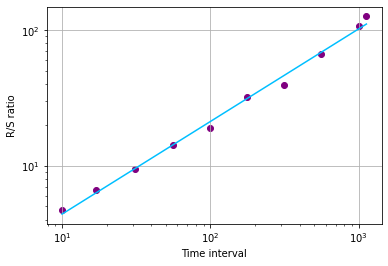

H=0.6834, c=0.9101


In [135]:
# Evaluate Hurst equation
H_w, c_w, data_w = compute_Hc(AAPL_0_returns_weekly, kind='change', simplified=True)

# Plot
f, ax = plt.subplots()
ax.plot(data_w[0], c_w*data_w[0]**H_w, color="deepskyblue")
ax.scatter(data_w[0], data_w[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H_w, c_w))


# H=0.6834, c=0.9101 for non-scaled returns 
# H=0.5421, c=1.2965 for scaled returns 

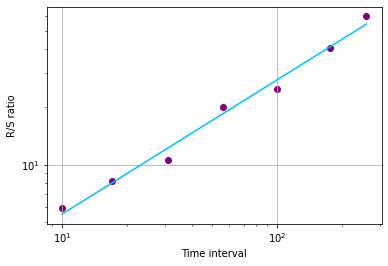

H=0.7014, c=1.0971


In [136]:
# Evaluate Hurst equation
H_m, c_m, data_m = compute_Hc(AAPL_0_returns_monthly, kind='change', simplified=True) #APL_MISC_returns_m['AAPL Daily Returns'].values

# Plot
f, ax = plt.subplots()
ax.plot(data_m[0], c_m*data_m[0]**H_m, color="deepskyblue")
ax.scatter(data_m[0], data_m[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H_m, c_m))

# H=0.7014, c=1.0971 for non-scaled returns 
# H=0.4769, c=1.6780 for scaled returns 

In [137]:
AAPL_0_returns_monthly.head()

Dates
1999-05-31   -0.017500
1999-06-30    0.039596
1999-07-31    0.200483
1999-08-31    0.173038
1999-09-30    0.082878
Freq: M, Name: AAPL Daily Returns, dtype: float64

In [138]:
AAPL_0_returns_weekly.head()

Dates
1999-05-16   -0.010000
1999-05-23   -0.010101
1999-05-30    0.002551
1999-06-06    0.094148
1999-06-13   -0.034884
Freq: W-SUN, Name: AAPL Daily Returns, dtype: float64

In [139]:

AAPL_returns.drop(columns = ['AAPL Log Returns', 'AAPL Daily Returns', 
                            'AAPL 2 Day Price Return', 'AAPL 3 Day Price Return',
                            'AAPL 5 Day Price Return', 'DJIA Daily Returns', 
                            'Oil 2 Day Price Return', 'Oil 3 Day Price Return', 
                            'Oil 5 Day Price Return', 'Gold/Dollar 2 Day Price Return',	
                            'Gold/Dollar 3 Day Price Return', 'Gold/Dollar 5 Day Price Return',
                             'DJIA 2 Day Price Return',	'DJIA 3 Day Price Return',
                             'DJIA 5 Day Price Return'], inplace=True) 
                            
Monthly_AAPL_data = AAPL_returns.groupby(pd.Grouper(freq='M')).mean()
Weekly_AAPL_data = AAPL_returns.groupby(pd.Grouper(freq='W')).mean()

print(f'Shape of monthly data: {Monthly_AAPL_data.shape}')
print(f'Shape of weekly data: {Weekly_AAPL_data.shape}')

scaled_Monthly_AAPL_data = helper_funcs.scale_dataset(Monthly_AAPL_data, min=False) 
scaled_Weekly_AAPL_data = helper_funcs.scale_dataset(Weekly_AAPL_data, min=False)

scaled_Monthly_AAPL_data = scaled_Monthly_AAPL_data.join(DJIA_0_returns_monthly, how = 'left')
scaled_Monthly_AAPL_data = scaled_Monthly_AAPL_data.join(AAPL_0_returns_monthly, how = 'left')
scaled_Weekly_AAPL_data = scaled_Weekly_AAPL_data.join(DJIA_0_returns_weekly, how = 'left')
scaled_Weekly_AAPL_data = scaled_Weekly_AAPL_data.join(AAPL_0_returns_weekly, how = 'left')
 
joined_data_w = scaled_AAPL_returns[['Year_cos', 'Year_sin', 'Month_sin', 'Month_cos']].groupby(pd.Grouper(freq='W')).mean()
joined_data_m = scaled_AAPL_returns[['Year_cos', 'Year_sin', 'Month_sin', 'Month_cos']].groupby(pd.Grouper(freq='M')).mean()

scaled_Monthly_AAPL_data = scaled_Monthly_AAPL_data.join(joined_data_m, how = 'left')
scaled_Monthly_AAPL_data.dropna(inplace=True)

scaled_Weekly_AAPL_data = scaled_Weekly_AAPL_data.join(joined_data_w, how = 'left')
scaled_Weekly_AAPL_data.dropna(inplace=True)

print(scaled_Monthly_AAPL_data.shape)
print(scaled_Weekly_AAPL_data.shape)

Shape of monthly data: (260, 58)
Shape of weekly data: (1130, 58)
(260, 64)
(1130, 64)


In [140]:
scaled_Monthly_AAPL_data.loc['2019']

,PX_LAST,PX_OPEN,PX_BID,PX_ASK,PX_HIGH,PX_LOW,VOLATILITY_10D,VOLATILITY_30D,PE_RATIO,PX_TO_BOOK_RATIO,PX_TO_SALES_RATIO,BETA_ADJ_OVERRIDABLE,ALPHA_OVERRIDABLE,VIX Closing price,VIX Opening price,VIX PX_HIGH,VIX PX_LOW,VIX VOLATILITY_10D,VIX VOLATILITY_30D,DJIA Closing price,DJIA Opening price,DJIA High price,DJIA Low price,DJIA VOLATILITY_10D,DJIA VOLATILITY_30D,DJIA Price_earning ratio,DJIA Price_book_ratio,DJIA Price_sales_ratio,EUR-USD Exchange,Oil Closing price,Oil opening price,Oil bid price,Oil ask price,Oil high price,Oil low price,Oil VOLATILITY_10D,Oil VOLATILITY_30D,Three Month Interest Rate,Gold/Dollar Closing price,Gold/Dollar Opening price,Gold/Dollar Bid price,Gold/Dollar ask price,Gold/Dollar High price,Gold/Dollar Low price,Gold/Dollar VOLATILITY_10D,Gold/Dollar VOLATILITY_30D,Pound/Dollar Closing price,Pound/Dollar Opening price,Pound/Dollar Bid price,Pound/Dollar Ask price,Pound/Dollar High price,Pound/Dollar Low price,Pound/Dollar VOLATILITY_10D,Pound/Dollar VOLATILITY_30D,Oil Previous Close,Oil Delta,Gold/Dollar Previous Close,DJIA Previous Close,DJIA Daily Returns,AAPL Daily Returns,Year_cos,Year_sin,Month_sin,Month_cos
Dates,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-31,7.583548,7.549626,7.584528,7.583262,7.576747,7.554180,0.222624,0.229902,-0.974959,0.728004,0.088288,0.144734,-1.576745,-0.306864,-0.232786,-0.218050,-0.300653,0.955065,1.473641,9.768828,9.733153,9.835707,9.633081,0.463863,1.054597,-0.601353,0.320245,2.468241,-0.350639,-0.174568,-0.186679,-0.161293,-0.164170,-0.175245,-0.182612,0.363978,1.109149,0.013890,1.441083,1.437637,1.440163,1.441995,1.424946,1.455592,-1.268370,-1.316274,-2.115132,-2.124972,-2.117084,-2.113100,-2.125156,-2.116280,0.058542,-0.200398,-0.187723,1.116617,1.438307,9.724540,0.071684,0.055154,0.688967,0.724793,0.201299,0.979530
2019-02-28,8.544207,8.521985,8.546095,8.544772,8.517046,8.581688,-0.873789,-0.319813,-0.923827,1.039162,0.324353,0.245912,-1.687082,-0.798433,-0.775515,-0.758966,-0.807183,-0.407093,0.185838,10.818233,10.798910,10.867157,10.732940,-0.510213,-0.186686,-0.315456,0.649568,2.918893,-0.387588,-0.054000,-0.056620,-0.044048,-0.046235,-0.059877,-0.052388,-0.681090,-0.259911,0.022245,1.499473,1.502537,1.498715,1.500711,1.487002,1.519256,-1.102046,-1.216945,-2.054850,-2.057967,-2.056230,-2.053303,-2.064047,-2.042029,-0.386729,-0.134373,-0.059418,0.242017,1.502704,10.798182,0.036654,0.040327,0.688967,0.724793,0.394356,0.918958
2019-03-31,9.193424,9.185341,9.195114,9.193438,9.182826,9.201096,-1.029276,-1.016907,-0.888132,1.275397,0.482836,0.252766,-1.657393,-0.887365,-0.876522,-0.821142,-0.911022,0.284164,-0.149696,10.909899,10.923105,10.989412,10.811735,-0.788665,-0.721481,-0.274103,0.679874,2.956153,-0.414843,0.061196,0.056349,0.069628,0.065621,0.047543,0.070010,-1.039195,-0.947763,0.028412,1.456495,1.460185,1.457071,1.455911,1.446738,1.473667,-1.001907,-1.041124,-1.971612,-1.965284,-1.973374,-1.969747,-1.967095,-1.967427,0.731372,0.237948,0.056166,0.443414,1.460202,10.917594,0.008706,0.104186,0.688967,0.724793,0.571268,0.820763
2019-04-30,10.118928,10.078878,10.119813,10.118055,10.072211,10.135262,-1.317151,-1.103413,-0.826766,1.850539,0.699128,0.237212,-1.605270,-1.057462,-1.043269,-1.028488,-1.073398,-0.315093,0.022316,11.395259,11.396979,11.429722,11.330803,-0.859570,-0.791430,-0.172531,0.657124,2.921885,-0.447279,0.258503,0.254268,0.265397,0.261936,0.242788,0.272607,-1.040489,-1.214264,0.018863,1.423501,1.426210,1.424445,1.422549,1.409724,1.442932,-1.254800,-1.185093,-2.047154,-2.046807,-2.049127,-2.045207,-2.059324,-2.025206,-0.965377,0.023149,0.253257,0.382163,1.426130,11.388051,0.025618,0.056170,0.688967,0.724793,0.724793,0.688967
2019-05-31,9.613334,9.590720,9.614955,9.613535,9.627388,9.614112,-0.398771,-0.750736,-0.854286,1.672894,0.575451,0.235054,-1.761554,-0.629908,-0.640665,-0.519177,-0.693753,2.287529,1.351567,10.919178,10.946416,11.017303,10.814895,-0.427346,-0.686721,-0.300701,0.522917,2.691595,-0.472950,0.152859,0.

In [141]:
scaled_Monthly_AAPL_data['AAPL Monthly Returns'] = scaled_Monthly_AAPL_data['AAPL Daily Returns']  
scaled_Monthly_AAPL_data['DJIA Monthly Returns'] = scaled_Monthly_AAPL_data['DJIA Daily Returns']

#scaled_Monthly_AAPL_data['AAPL 2 Month Return'] = scaled_Monthly_AAPL_data['AAPL Monthly Returns'] / scaled_Monthly_AAPL_data['AAPL Monthly Returns'].shift(2)  - 1
#scaled_Monthly_AAPL_data['AAPL 3 Month Return'] = scaled_Monthly_AAPL_data['AAPL Monthly Returns'] / scaled_Monthly_AAPL_data['AAPL Monthly Returns'].shift(3)  - 1
#scaled_Monthly_AAPL_data['AAPL 5 Month Return'] = scaled_Monthly_AAPL_data['AAPL Monthly Returns'] / scaled_Monthly_AAPL_data['AAPL Monthly Returns'].shift(5)  - 1

scaled_Monthly_AAPL_data['DJIA 2 Month Return'] = scaled_Monthly_AAPL_data['DJIA Monthly Returns'] / scaled_Monthly_AAPL_data['DJIA Monthly Returns'].shift(2)  - 1
scaled_Monthly_AAPL_data['DJIA 3 Month Return'] = scaled_Monthly_AAPL_data['DJIA Monthly Returns'] / scaled_Monthly_AAPL_data['DJIA Monthly Returns'].shift(3)  - 1
scaled_Monthly_AAPL_data['DJIA 5 Month Return'] = scaled_Monthly_AAPL_data['DJIA Monthly Returns'] / scaled_Monthly_AAPL_data['DJIA Monthly Returns'].shift(5)  - 1

scaled_Monthly_AAPL_data['Oil Monthly Return'] = scaled_Monthly_AAPL_data['Oil Previous Close'] / scaled_Monthly_AAPL_data['Oil Previous Close'].shift(1)  - 1
scaled_Monthly_AAPL_data['Oil 2 Month Return'] = scaled_Monthly_AAPL_data['Oil Monthly Return'] / scaled_Monthly_AAPL_data['Oil Monthly Return'].shift(2)  - 1
scaled_Monthly_AAPL_data['Oil 3 Month Return'] = scaled_Monthly_AAPL_data['Oil Monthly Return'] / scaled_Monthly_AAPL_data['Oil Monthly Return'].shift(3)  - 1
scaled_Monthly_AAPL_data['Oil 5 Month Return'] = scaled_Monthly_AAPL_data['Oil Monthly Return'] / scaled_Monthly_AAPL_data['Oil Monthly Return'].shift(5)  - 1

scaled_Monthly_AAPL_data['Gold/Dollar Change'] = scaled_Monthly_AAPL_data['Gold/Dollar Previous Close'] / scaled_Monthly_AAPL_data['Gold/Dollar Previous Close'].shift(1)  - 1
scaled_Monthly_AAPL_data['Gold/Dollar 2 Month Change'] = scaled_Monthly_AAPL_data['Gold/Dollar Change'] / scaled_Monthly_AAPL_data['Gold/Dollar Change'].shift(2)  - 1
scaled_Monthly_AAPL_data['Gold/Dollar 5 Month Change'] = scaled_Monthly_AAPL_data['Gold/Dollar Change'] / scaled_Monthly_AAPL_data['Gold/Dollar Change'].shift(5)  - 1
scaled_Monthly_AAPL_data['Gold/Dollar 3 Month Change'] = scaled_Monthly_AAPL_data['Gold/Dollar Change'] / scaled_Monthly_AAPL_data['Gold/Dollar Change'].shift(3)  - 1

scaled_Monthly_AAPL_data['Pound/Dollar Monthly Change'] = scaled_Monthly_AAPL_data['Pound/Dollar Closing price'] / scaled_Monthly_AAPL_data['Pound/Dollar Closing price'].shift(1)  - 1
scaled_Monthly_AAPL_data['Pound/Dollar 2 Month Change'] = scaled_Monthly_AAPL_data['Pound/Dollar Monthly Change'] / scaled_Monthly_AAPL_data['Pound/Dollar Monthly Change'].shift(2)  - 1
scaled_Monthly_AAPL_data['Pound/Dollar 3 Month Change'] = scaled_Monthly_AAPL_data['Pound/Dollar Monthly Change'] / scaled_Monthly_AAPL_data['Pound/Dollar Monthly Change'].shift(3)  - 1
scaled_Monthly_AAPL_data['Pound/Dollar 5 Month Change'] = scaled_Monthly_AAPL_data['Pound/Dollar Monthly Change'] / scaled_Monthly_AAPL_data['Pound/Dollar Monthly Change'].shift(5)  - 1

scaled_Monthly_AAPL_data['2 Period Change in 3 Month Interest Rate'] = scaled_Monthly_AAPL_data['Three Month Interest Rate'] / scaled_Monthly_AAPL_data['Three Month Interest Rate'].shift(2)  - 1
scaled_Monthly_AAPL_data['3 Period Change in 3 Month Interest Rate'] = scaled_Monthly_AAPL_data['Three Month Interest Rate'] / scaled_Monthly_AAPL_data['Three Month Interest Rate'].shift(3)  - 1
scaled_Monthly_AAPL_data['5 Period Change in 3 Month Interest Rate'] = scaled_Monthly_AAPL_data['Three Month Interest Rate'] / scaled_Monthly_AAPL_data['Three Month Interest Rate'].shift(5)  - 1

scaled_Monthly_AAPL_data.drop(columns =['PX_LAST', 'PX_OPEN', 'PX_BID', 'PX_HIGH', 'PX_LOW',
                                       'VIX Closing price',	'VIX Opening price', 'VIX PX_HIGH',	'VIX PX_LOW',
                                       'DJIA Closing price', 'DJIA Opening price', 'DJIA High price', 'DJIA Low price',
                                       "Oil Closing price",	"Oil opening price", 'Oil bid price', 'Oil ask price',	
                                       'Oil high price', 'Oil low price', 'Gold/Dollar Closing price', 'Gold/Dollar Opening price',	
                                       'Gold/Dollar Bid price',	'Gold/Dollar ask price', 'Gold/Dollar High price',
                                       'Gold/Dollar Low price'], inplace=True)


In [ ]:
print(scaled_Monthly_AAPL_data.shape)
print(scaled_Monthly_AAPL_data.isnull().values.any())
scaled_Monthly_AAPL_data.dropna(inplace=True)
print(scaled_Monthly_AAPL_data.isnull().values.any())
print(scaled_Monthly_AAPL_data.shape)
scaled_Monthly_AAPL_data.drop(columns = ['DJIA Daily Returns', 'AAPL Daily Returns'], inplace=True)
#scaled_Monthly_AAPL_data['AAPL Monthly Returns'] = scaled_Monthly_AAPL_data['AAPL Monthly Returns'] - 1
scaled_Monthly_AAPL_data.head()

In [143]:
scaled_Weekly_AAPL_data['AAPL Weekly Returns'] = scaled_Weekly_AAPL_data['AAPL Daily Returns']
scaled_Weekly_AAPL_data['DJIA Weekly Returns'] = scaled_Weekly_AAPL_data['DJIA Daily Returns'] 

#scaled_Weekly_AAPL_data['AAPL 2 Week Return'] = scaled_Weekly_AAPL_data['AAPL Weekly Returns'] / scaled_Weekly_AAPL_data['AAPL Weekly Returns'].shift(2)  - 1
#scaled_Weekly_AAPL_data['AAPL 3 Week Return'] = scaled_Weekly_AAPL_data['AAPL Weekly Returns'] / scaled_Weekly_AAPL_data['AAPL Weekly Returns'].shift(3)  - 1
#scaled_Weekly_AAPL_data['AAPL 5 Week Return'] = scaled_Weekly_AAPL_data['AAPL Weekly Returns'] / scaled_Weekly_AAPL_data['AAPL Weekly Returns'].shift(5)  - 1

scaled_Weekly_AAPL_data['DJIA 2 Week Return'] = scaled_Weekly_AAPL_data['DJIA Weekly Returns'] / scaled_Weekly_AAPL_data['DJIA Weekly Returns'].shift(2)  - 1
scaled_Weekly_AAPL_data['DJIA 3 Week Return'] = scaled_Weekly_AAPL_data['DJIA Weekly Returns'] / scaled_Weekly_AAPL_data['DJIA Weekly Returns'].shift(3)  - 1
scaled_Weekly_AAPL_data['DJIA 5 Week Return'] = scaled_Weekly_AAPL_data['DJIA Weekly Returns'] / scaled_Weekly_AAPL_data['DJIA Weekly Returns'].shift(5)  - 1

scaled_Weekly_AAPL_data['Oil 2 Week Return'] = scaled_Weekly_AAPL_data['Oil Previous Close'] / scaled_Weekly_AAPL_data['Oil Previous Close'].shift(2)  - 1
scaled_Weekly_AAPL_data['Oil 3 Week Return'] = scaled_Weekly_AAPL_data['Oil Previous Close'] / scaled_Weekly_AAPL_data['Oil Previous Close'].shift(3)  - 1
scaled_Weekly_AAPL_data['Oil 5 Week Return'] = scaled_Weekly_AAPL_data['Oil Previous Close'] / scaled_Weekly_AAPL_data['Oil Previous Close'].shift(5)  - 1

scaled_Weekly_AAPL_data['Gold/Dollar 2 Week Change'] = scaled_Weekly_AAPL_data['Gold/Dollar Previous Close'] / scaled_Weekly_AAPL_data['Gold/Dollar Previous Close'].shift(2)  - 1
scaled_Weekly_AAPL_data['Gold/Dollar 3 Week Change'] = scaled_Weekly_AAPL_data['Gold/Dollar Previous Close'] / scaled_Weekly_AAPL_data['Gold/Dollar Previous Close'].shift(3)  - 1
scaled_Weekly_AAPL_data['Gold/Dollar 5 Week Change'] = scaled_Weekly_AAPL_data['Gold/Dollar Previous Close'] / scaled_Weekly_AAPL_data['Gold/Dollar Previous Close'].shift(5)  - 1

scaled_Weekly_AAPL_data['Pound/Dollar 2 Week Change'] = scaled_Weekly_AAPL_data['Pound/Dollar Closing price'] / scaled_Weekly_AAPL_data['Pound/Dollar Closing price'].shift(2)  - 1
scaled_Weekly_AAPL_data['Pound/Dollar 3 Week Change'] = scaled_Weekly_AAPL_data['Pound/Dollar Closing price'] / scaled_Weekly_AAPL_data['Pound/Dollar Closing price'].shift(3)  - 1
scaled_Weekly_AAPL_data['Pound/Dollar 5 Week Change'] = scaled_Weekly_AAPL_data['Pound/Dollar Closing price'] / scaled_Weekly_AAPL_data['Pound/Dollar Closing price'].shift(5)  - 1


In [144]:
# Checking if there is any leakage on the AAPL data

print(scaled_Weekly_AAPL_data['AAPL Weekly Returns'][:5])

print(AAPL_0_returns_weekly['1999-06-20':][:5])

AAPL_0_returns_weekly = AAPL_0_returns_weekly['1999-06-20':]

print(AAPL_0_returns_weekly['1999-06-20':][:5])

Dates
1999-05-16   -0.010000
1999-05-23   -0.010101
1999-05-30    0.002551
1999-06-06    0.094148
1999-06-13   -0.034884
Freq: W-SUN, Name: AAPL Weekly Returns, dtype: float64
Dates
1999-06-20    0.014458
1999-06-27   -0.106882
1999-07-04    0.086591
1999-07-11    0.200483
1999-07-18   -0.046278
Freq: W-SUN, Name: AAPL Daily Returns, dtype: float64
Dates
1999-06-20    0.014458
1999-06-27   -0.106882
1999-07-04    0.086591
1999-07-11    0.200483
1999-07-18   -0.046278
Freq: W-SUN, Name: AAPL Daily Returns, dtype: float64


In [145]:
print(scaled_Monthly_AAPL_data['AAPL Monthly Returns'][:5])

print(AAPL_0_returns_monthly[:5])

AAPL_0_returns_monthly = AAPL_0_returns_monthly['1999-11-30':]

print(AAPL_0_returns_monthly[:5])

Dates
1999-11-30    0.222378
1999-12-31    0.050343
2000-01-31   -0.026996
2000-02-29    0.104752
2000-03-31    0.185728
Freq: M, Name: AAPL Monthly Returns, dtype: float64
Dates
1999-05-31   -0.017500
1999-06-30    0.039596
1999-07-31    0.200483
1999-08-31    0.173038
1999-09-30    0.082878
Freq: M, Name: AAPL Daily Returns, dtype: float64
Dates
1999-11-30    0.222378
1999-12-31    0.050343
2000-01-31   -0.026996
2000-02-29    0.104752
2000-03-31    0.185728
Freq: M, Name: AAPL Daily Returns, dtype: float64


In [146]:
print(scaled_Weekly_AAPL_data.shape)
print(scaled_Weekly_AAPL_data.isnull().values.any())
scaled_Weekly_AAPL_data.dropna(inplace=True)
print(scaled_Weekly_AAPL_data.isnull().values.any())

scaled_Weekly_AAPL_data.drop(columns = ['DJIA Daily Returns', 'AAPL Daily Returns'], inplace=True)
#scaled_Weekly_AAPL_data['AAPL Weekly Returns'] = scaled_Weekly_AAPL_data['AAPL Weekly Returns'] - 1

scaled_Weekly_AAPL_data.drop(columns =['PX_LAST', 'PX_OPEN', 'PX_BID', 'PX_HIGH', 'PX_LOW', 'PX_ASK',
                                       'VIX Closing price',	'VIX Opening price', 'VIX PX_HIGH',	'VIX PX_LOW',
                                       'DJIA Closing price', 'DJIA Opening price', 'DJIA High price', 'DJIA Low price',
                                       "Oil Closing price",	"Oil opening price", 'Oil bid price', 'Oil ask price',	
                                       'Oil high price', 'Oil low price', 'Gold/Dollar Closing price', 'Gold/Dollar Opening price',	
                                       'Gold/Dollar Bid price',	'Gold/Dollar ask price', 'Gold/Dollar High price',
                                       'Gold/Dollar Low price'], inplace=True)
print(scaled_Weekly_AAPL_data.shape)
scaled_Weekly_AAPL_data.head()

(1130, 78)
True
False
(1125, 50)


,VOLATILITY_10D,VOLATILITY_30D,PE_RATIO,PX_TO_BOOK_RATIO,PX_TO_SALES_RATIO,BETA_ADJ_OVERRIDABLE,ALPHA_OVERRIDABLE,VIX VOLATILITY_10D,VIX VOLATILITY_30D,DJIA VOLATILITY_10D,DJIA VOLATILITY_30D,DJIA Price_earning ratio,DJIA Price_book_ratio,DJIA Price_sales_ratio,EUR-USD Exchange,Oil VOLATILITY_10D,Oil VOLATILITY_30D,Three Month Interest Rate,Gold/Dollar VOLATILITY_10D,Gold/Dollar VOLATILITY_30D,Pound/Dollar Closing price,Pound/Dollar Opening price,Pound/Dollar Bid price,Pound/Dollar Ask price,Pound/Dollar High price,Pound/Dollar Low price,Pound/Dollar VOLATILITY_10D,Pound/Dollar VOLATILITY_30D,Oil Previous Close,Oil Delta,Gold/Dollar Previous Close,DJIA Previous Close,Year_cos,Year_sin,Month_sin,Month_cos,AAPL Weekly Returns,DJIA Weekly Returns,DJIA 2 Week Return,DJIA 3 Week Return,DJIA 5 Week Return,Oil 2 Week Return,Oil 3 Week Return,Oil 5 Week Return,Gold/Dollar 2 Week Change,Gold/Dollar 3 Week Change,Gold/Dollar 5 Week Change,Pound/Dollar 2 Week Change,Pound/Dollar 3 Week Change,Pound/Dollar 5 Week Change
Dates,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-06-20,-0.088124,0.155493,-0.796547,-0.613644,-1.245520,-0.526821,0.492545,-0.105566,-0.094588,-0.045634,-0.160903,2.889451,2.634485,2.951400,-0.884080,-0.228969,-0.195194,1.117841,-0.721342,-1.007874,-0.430450,-0.409214,-0.430637,-0.430973,-0.426635,-0.412189,-0.051234,-0.735645,-1.342378,-0.236975,-0.965490,-0.021352,-0.994869,0.101168,0.937752,0.347305,0.014458,0.034798,0.530507,-2.398132,-4.400894,-0.041159,-0.026957,-0.010361,0.019306,0.028926,0.046002,0.184497,0.047554,0.418582
1999-06-27,0.013728,0.092947,-0.846628,-0.765058,-1.292122,-0.487784,0.368555,-0.044219,-0.147822,-0.252097,-0.147731,2.823752,2.573070,2.884807,-0.883807,-0.050618,-0.183770,1.155193,-1.160693,-1.216989,-0.476337,-0.468463,-0.477498,-0.476946,-0.493821,-0.463128,-0.337264,-0.668532,-1.350538,0.084244,-0.964632,0.002535,-0.994869,0.101168,0.937752,0.347305,-0.106882,-0.026275,-0.082643,-2.155641,2.412040,-0.008204,-0.035331,-0.016700,0.005343,0.018399,0.036157,0.267594,0.310768,0.407383
1999-07-04,0.290706,0.148410,-0.854599,-0.867811,-1.272025,-0.449135,0.611809,-0.333605,-0.114077,-0.164180,-0.077150,2.781161,2.620170,2.997346,-0.926972,-0.065409,-0.261341,1.158473,-1.340382,-1.184572,-0.534849,-0.527713,-0.535334,-0.535182,-0.542218,-0.513152,-0.718060,-0.598838,-1.326270,0.391838,-0.960735,0.091571,-0.994869,0.101168,0.958039,0.268954,0.086591,0.055596,0.597671,-2.941057,-3.233755,-0.012000,-0.026025,-0.038634,-0.004926,0.001281,0.023858,0.242534,0.423301,0.301622
1999-07-11,0.384627,0.131674,-0.772928,-0.701520,-1.167781,-0.428448,0.933680,0.211636,-0.148296,-0.455323,-0.215314,2.779203,2.672500,3.095913,-0.966383,-0.528050,-0.325458,1.118232,-0.495765,-0.966439,-0.642788,-0.609586,-0.642390,-0.642987,-0.633319,-0.618813,-0.617516,-0.578995,-1.291620,-0.070340,-0.968489,0.332627,-0.994869,0.101168,0.988468,0.151428,0.200483,0.004888,-1.186037,-0.859529,-0.785008,-0.043626,-0.037813,-0.077415,0.003998,0.003106,0.022471,0.349439,0.493293,0.768802
1999-07-18,0.747991,0.307666,-0.745449,-0.645568,-1.132710,-0.429845,0.712938,0.568098,-0.053901,-0.836795,-0.401351,2.795823,2.688330,3.113453,-0.992180,-1.028268,-0.495982,1.133115,-0.613407,-1.024311,-0.620146,-0.632265,-0.620387,-0.620284,-0.641351,-0.609392,-0.396781,-0.576252,-1.281867,0.159177,-0.975141,0.356857,-0.994869,0.101168,0.988468,0.151428,-0.046278,0.001443,-0.974049,-1.054911,-1.050373,-0.033480,-0.050847,-0.058633,0.014995,0.010894,0.016296,0.159480,0.301906,0.650289


In [147]:
scaled_Weekly_AAPL_data['AAPL Weekly Returns'].head()

Dates
1999-06-20    0.014458
1999-06-27   -0.106882
1999-07-04    0.086591
1999-07-11    0.200483
1999-07-18   -0.046278
Freq: W-SUN, Name: AAPL Weekly Returns, dtype: float64

In [148]:
AAPL_MISC_returns_w['AAPL Daily Returns'].loc['1999-06-20':].tail()

Dates
2020-12-06    1.048546
2020-12-13    1.001309
2020-12-20    1.034679
2020-12-27    1.050000
2021-01-03    0.978223
Freq: W-SUN, Name: AAPL Daily Returns, dtype: float64

# Converting returns to binary form

In [149]:
# Non-scaled returns
Weekly_AAPL_returns = AAPL_MISC_returns_w['AAPL Daily Returns'] - 1
Monthly_AAPL_returns = AAPL_MISC_returns_m['AAPL Daily Returns'] - 1

AAPL_weekly_binary_returns = np.zeros(len(AAPL_0_returns_weekly))

for i in range(len(AAPL_0_returns_weekly)): # scaled_AAPL_0_returns_weekly
    if AAPL_0_returns_weekly.values[i] > 0: # Greater than 0 as returns are centred around 0 
        AAPL_weekly_binary_returns[i] = 1
    else:
        AAPL_weekly_binary_returns[i] = 0

AAPL_monthly_binary_returns = np.zeros(len(AAPL_0_returns_monthly))

for i in range(len(AAPL_0_returns_monthly)): # scaled_AAPL_0_returns_monthly
    if AAPL_0_returns_monthly.values[i] > 0: # Greater than 0 as returns are centred around 0 
        AAPL_monthly_binary_returns[i] = 1
    else:
        AAPL_monthly_binary_returns[i] = 0

AAPL_monthly_binary_returns = pd.DataFrame(data = AAPL_monthly_binary_returns, index = AAPL_0_returns_monthly.index)
AAPL_weekly_binary_returns = pd.DataFrame(data = AAPL_weekly_binary_returns, index = AAPL_0_returns_weekly.index)

In [150]:
# Checking the proportion of 1 and 0s in each - ideally need to be balanced 

print(f'Proportion of 1\'s in Weekly Data {np.array(AAPL_weekly_binary_returns == 1).sum()/len(AAPL_weekly_binary_returns)}')

print(f'Proportion of 1\'s in Monthly Data {np.array(AAPL_monthly_binary_returns == 1).sum()/len(AAPL_monthly_binary_returns)}')

# This is an issue because now we have an uneven distribution of class labels - explains why we see when the returns 
# are used as the only feature we see the model constantly predicting another 1 

Proportion of 1's in Weekly Data 0.5777777777777777
Proportion of 1's in Monthly Data 0.6141732283464567


In [151]:
# Checking the proportion of 1 and 0s in each - ideally need to be balanced 

print(f'Proportion of 1\'s in Weekly Data {np.array(XOM_weekly_binary_returns == 1).sum()/len(XOM_weekly_binary_returns)}')

print(f'Proportion of 1\'s in Monthly Data {np.array(XOM_monthly_binary_returns == 1).sum()/len(XOM_monthly_binary_returns)}')

# This is an issue because now we have an uneven distribution of class labels - explains why we see when the returns 
# are used as the only feature we see the model constantly predicting another 1 

Proportion of 1's in Weekly Data 0.5126416739319966
Proportion of 1's in Monthly Data 0.5153846153846153


In [152]:
Monthly_AAPL_returns

Dates
1999-05-31   -0.017500
1999-06-30    0.039596
1999-07-31    0.200483
1999-08-31    0.173038
1999-09-30    0.082878
                ...   
2020-08-31    0.214380
2020-09-30   -0.056445
2020-10-31   -0.060012
2020-11-30    0.093606
2020-12-31    0.092749
Freq: M, Name: AAPL Daily Returns, Length: 260, dtype: float64

In [153]:
print(Weekly_AAPL_returns.shape)
print(Weekly_AAPL_returns.loc['1999-06-20':][:5])
print('\n')
print(scaled_Weekly_AAPL_data.shape)
print(scaled_Weekly_AAPL_data['AAPL Weekly Returns'][:5])

(1130,)
Dates
1999-06-20    0.014458
1999-06-27   -0.106882
1999-07-04    0.086591
1999-07-11    0.200483
1999-07-18   -0.046278
Freq: W-SUN, Name: AAPL Daily Returns, dtype: float64


(1125, 50)
Dates
1999-06-20    0.014458
1999-06-27   -0.106882
1999-07-04    0.086591
1999-07-11    0.200483
1999-07-18   -0.046278
Freq: W-SUN, Name: AAPL Weekly Returns, dtype: float64


# Investigating which features showed strong lag-1 autocorrelation

In [154]:
lagged_monthly_correlations = helper_funcs.find_lagged_correlations(scaled_Monthly_AAPL_data, Monthly_AAPL_returns)
lagged_monthly_correlations


Correlation between PX_ASK and the Returns: -0.009303843717914385
Correlation between VOLATILITY_10D and the Returns: -0.15317891236493036
Correlation between VOLATILITY_30D and the Returns: -0.1350178246913033
Correlation between PE_RATIO and the Returns: 0.03851036538972969
Correlation between PX_TO_BOOK_RATIO and the Returns: 0.006519731751203164
Correlation between PX_TO_SALES_RATIO and the Returns: -0.02777333444025186
Correlation between BETA_ADJ_OVERRIDABLE and the Returns: -0.04299401071191564
Correlation between ALPHA_OVERRIDABLE and the Returns: -0.0207794837527866
Correlation between VIX VOLATILITY_10D and the Returns: -0.0283353625054065
Correlation between VIX VOLATILITY_30D and the Returns: 0.012504085262964211
Correlation between DJIA VOLATILITY_10D and the Returns: 0.023336814452252323
Correlation between DJIA VOLATILITY_30D and the Returns: 0.04201409351087578
Correlation between DJIA Price_earning ratio and the Returns: -0.08417523165359013
Correlation between DJIA Pr

In [155]:
#scaled_Weekly_AAPL_data['AAPL 5 Week Return'] #Worked before but now having NAN issues 

In [156]:
lagged_weekly_correlations = helper_funcs.find_lagged_correlations(scaled_Weekly_AAPL_data, Weekly_AAPL_returns)
lagged_weekly_correlations

Correlation between VOLATILITY_10D and the Returns: -0.10365102092013324
Correlation between VOLATILITY_30D and the Returns: -0.0631024643028702
Correlation between PE_RATIO and the Returns: 0.0052542675957466525
Correlation between PX_TO_BOOK_RATIO and the Returns: 0.003859243410667376
Correlation between PX_TO_SALES_RATIO and the Returns: -0.01894835793503721
Correlation between BETA_ADJ_OVERRIDABLE and the Returns: -0.03233072373824551
Correlation between ALPHA_OVERRIDABLE and the Returns: 0.003009830146718816
Correlation between VIX VOLATILITY_10D and the Returns: -0.0018824728441517874
Correlation between VIX VOLATILITY_30D and the Returns: -0.006262008086307412
Correlation between DJIA VOLATILITY_10D and the Returns: -0.0023997249717175317
Correlation between DJIA VOLATILITY_30D and the Returns: 0.012609998680295895
Correlation between DJIA Price_earning ratio and the Returns: -0.0030291725070868115
Correlation between DJIA Price_book_ratio and the Returns: -0.006889822489098453


In [157]:
Weekly_AAPL_returns

Dates
1999-05-16   -0.010000
1999-05-23   -0.010101
1999-05-30    0.002551
1999-06-06    0.094148
1999-06-13   -0.034884
                ...   
2020-12-06    0.048546
2020-12-13    0.001309
2020-12-20    0.034679
2020-12-27    0.050000
2021-01-03   -0.021777
Freq: W-SUN, Name: AAPL Daily Returns, Length: 1130, dtype: float64

In [158]:
lagged_weekly_correlations = {}
for i in scaled_Weekly_AAPL_data.columns:
    col_name = i
    correlator = scaled_Weekly_AAPL_data[col_name].shift(1)
    val = Weekly_AAPL_returns.corr(correlator)
    lagged_weekly_correlations[col_name] = val

In [159]:
lagged_monthly_correlations = {}
for i in scaled_Monthly_AAPL_data.columns:
    col_name = i
    correlator = scaled_Monthly_AAPL_data[col_name].shift(1)
    val = Monthly_AAPL_returns.corr(correlator)
    lagged_monthly_correlations[col_name] = val

# Filtered features whose autocorrelation exceeds |0.05|

In [160]:
filtered_positive_dict_m = {key for (key, value) in lagged_monthly_correlations.items() if value > 0.125}
filtered_negative_dict_m = {key for (key, value) in lagged_monthly_correlations.items() if value < -0.125}

In [161]:
filtered_positive_dict_w = {key for (key, value) in lagged_weekly_correlations.items() if value > 0.05}
filtered_negative_dict_w = {key for (key, value) in lagged_weekly_correlations.items() if value < -0.05}

In [162]:
for i in filtered_positive_dict_m:
    print(i, lagged_monthly_correlations[i])

EUR-USD Exchange 0.134428120333844
AAPL Monthly Returns 0.12868825983900667


In [163]:
for i in filtered_negative_dict_m:
    print(i, lagged_monthly_correlations[i])

VOLATILITY_10D -0.15317891236493034
VOLATILITY_30D -0.1350178246913033


In [164]:
for i in filtered_positive_dict_w:
    print(i, lagged_weekly_correlations[i])


EUR-USD Exchange 0.06422147404601396
AAPL Weekly Returns 0.12996832626464697


In [165]:
for i in filtered_negative_dict_w:
    print(i, lagged_weekly_correlations[i])


VOLATILITY_10D -0.10365102092013324
VOLATILITY_30D -0.0631024643028702
DJIA 3 Week Return -0.06101344754771166
Gold/Dollar 3 Week Change -0.05145577084085557


In [166]:
filtered_weekly_data = scaled_Weekly_AAPL_data[filtered_negative_dict_w].join(scaled_Weekly_AAPL_data[filtered_positive_dict_w])
filtered_weekly_data.head()

,VOLATILITY_10D,VOLATILITY_30D,DJIA 3 Week Return,Gold/Dollar 3 Week Change,EUR-USD Exchange,AAPL Weekly Returns
Dates,,,,,,
1999-06-20,-0.088124,0.155493,-2.398132,0.028926,-0.884080,0.014458
1999-06-27,0.013728,0.092947,-2.155641,0.018399,-0.883807,-0.106882
1999-07-04,0.290706,0.148410,-2.941057,0.001281,-0.926972,0.086591
1999-07-11,0.384627,0.131674,-0.859529,0.003106,-0.966383,0.200483
1999-07-18,0.747991,0.307666,-1.054911,0.010894,-0.992180,-0.046278


In [167]:
filtered_monthly_data = scaled_Monthly_AAPL_data[filtered_negative_dict_m].join(scaled_Monthly_AAPL_data[filtered_positive_dict_m])
filtered_monthly_data.head()

,VOLATILITY_10D,VOLATILITY_30D,EUR-USD Exchange,AAPL Monthly Returns
Dates,,,,
1999-11-30,0.390515,1.076479,-0.905373,0.222378
1999-12-31,0.517740,0.445801,-1.018477,0.050343
2000-01-31,2.038334,1.232732,-1.011401,-0.026996
2000-02-29,0.855925,1.322474,-1.161562,0.104752
2000-03-31,1.571362,1.101952,-1.261166,0.185728


In [168]:
AAPL_weekly_binary_returns[:10]

,0
Dates,
1999-06-20,1.0
1999-06-27,0.0
1999-07-04,1.0
1999-07-11,1.0
1999-07-18,0.0
1999-07-25,1.0
1999-08-01,1.0
1999-08-08,0.0
1999-08-15,1.0


In [169]:
AAPL_monthly_binary_returns[:10]

,0
Dates,
1999-11-30,1.0
1999-12-31,1.0
2000-01-31,0.0
2000-02-29,1.0
2000-03-31,1.0
2000-04-30,1.0
2000-05-31,0.0
2000-06-30,1.0
2000-07-31,0.0


In [170]:
# If we want to make binary predictions use the following data in create_dataset:
# AAPL_weekly_binary_returns & AAPL_monthly_binary_returns

# If we want to make numerical predictions use the following data in create_dataset: 
# Weekly_AAPL_returns & Monthly_AAPL_returns

T_w = 12 
T_m = 12 

X_W_AAPL_f, Y_W_AAPL_f = helper_funcs.create_datasets(T_w, 1, AAPL_weekly_binary_returns.values, 'AAPL', filtered_weekly_data, False)
X_M_AAPL_f, Y_M_AAPL_f = helper_funcs.create_datasets(T_m, 1,  AAPL_monthly_binary_returns.values, 'AAPL', filtered_monthly_data, False)

Shape of X: (1113, 12, 6) Shape of Y: (1113, 1)
Shape of X: (242, 12, 4) Shape of Y: (242, 1)


In [171]:
x_train_w_AAPL_f, y_train_w_AAPL_f, x_val_w_AAPL_f, y_val_w_AAPL_f, x_test_w_AAPL_f, y_test_w_AAPL_f = helper_funcs.data_split(X_W_AAPL_f, Y_W_AAPL_f)
x_train_w_AAPL_f, y_train_w_AAPL_f, x_val_w_AAPL_f, y_val_w_AAPL_f, x_test_w_AAPL_f, y_test_w_AAPL_f = x_train_w_AAPL_f.to(device), y_train_w_AAPL_f.to(device), x_val_w_AAPL_f.to(device), y_val_w_AAPL_f.to(device), x_test_w_AAPL_f.to(device), y_test_w_AAPL_f.to(device)

x_train_m_AAPL_f, y_train_m_AAPL_f, x_val_m_AAPL_f, y_val_m_AAPL_f, x_test_m_AAPL_f, y_test_m_AAPL_f = helper_funcs.data_split(X_M_AAPL_f, Y_M_AAPL_f)
x_train_m_AAPL_f, y_train_m_AAPL_f, x_val_m_AAPL_f, y_val_m_AAPL_f, x_test_m_AAPL_f, y_test_m_AAPL_f = x_train_m_AAPL_f.to(device), y_train_m_AAPL_f.to(device), x_val_m_AAPL_f.to(device), y_val_m_AAPL_f.to(device), x_test_m_AAPL_f.to(device), y_test_m_AAPL_f.to(device)

In [172]:
Hidden_w = 200 # 256
Hidden_m = 200 # 200

AAPL_model_w_f = LSTM(len(X_W_AAPL_f.T), Hidden_w, 1, 1)
AAPL_model_m_f = LSTM(len(X_M_AAPL_f.T), Hidden_m, 1, 1)

AAPL_model_w_f.to(device)
AAPL_model_m_f.to(device)

learning_rate = 5e-4   #5e-4

filtered_w_optimizer = torch.optim.Adam(AAPL_model_w_f.parameters(), lr = learning_rate)
filtered_m_optimizer = torch.optim.Adam(AAPL_model_m_f.parameters(), lr = learning_rate)

loss_function = nn.MSELoss()
binary_loss_function = nn.BCEWithLogitsLoss()

epochs = 1000 # 1000

print('Training on the Weekly Returns')
filtered_w_train_loss, filtered_w_val_loss = full_gd(AAPL_model_w_f,
                                      binary_loss_function,
                                      filtered_w_optimizer,
                                      x_train_w_AAPL_f, 
                                      y_train_w_AAPL_f, 
                                      x_val_w_AAPL_f,
                                      y_val_w_AAPL_f, 
                                      epochs)

print('\n')
print('Training on the Monthly Returns')
filtered_m_train_loss, filtered_m_val_loss = full_gd(AAPL_model_m_f,
                                      binary_loss_function,
                                      filtered_m_optimizer,
                                      x_train_m_AAPL_f, 
                                      y_train_m_AAPL_f, 
                                      x_val_m_AAPL_f,
                                      y_val_m_AAPL_f, 
                                      epochs)

Training on the Weekly Returns
Epoch 25/1000, Train Loss: 0.6710, Validation Loss: 0.7166
Epoch 50/1000, Train Loss: 0.6626, Validation Loss: 0.7361
Epoch 75/1000, Train Loss: 0.6323, Validation Loss: 0.7662
Epoch 100/1000, Train Loss: 0.5583, Validation Loss: 0.8205
Epoch 125/1000, Train Loss: 0.4852, Validation Loss: 1.0323
Epoch 150/1000, Train Loss: 0.4152, Validation Loss: 1.3077
Epoch 175/1000, Train Loss: 0.3609, Validation Loss: 1.5112
Epoch 200/1000, Train Loss: 0.3170, Validation Loss: 1.6748
Epoch 225/1000, Train Loss: 0.2767, Validation Loss: 1.9183
Epoch 250/1000, Train Loss: 0.2726, Validation Loss: 2.0239
Epoch 275/1000, Train Loss: 0.2381, Validation Loss: 2.0837
Epoch 300/1000, Train Loss: 0.2174, Validation Loss: 2.2521
Epoch 325/1000, Train Loss: 0.1991, Validation Loss: 2.4110
Epoch 350/1000, Train Loss: 0.1818, Validation Loss: 2.5593
Epoch 375/1000, Train Loss: 0.1647, Validation Loss: 2.6994
Epoch 400/1000, Train Loss: 0.1478, Validation Loss: 2.8207
Epoch 425/10

In [ ]:
print('\n')
# Get the accuracy for each model with different T
AAPL_model_w_f.eval()
with torch.no_grad():
  p_train = AAPL_model_w_f(x_train_w_AAPL_f)
  p_train = (p_train.cpu().numpy() > 0)
  train_acc_w_just_returns = np.mean(y_train_w_AAPL_f.cpu().numpy() == p_train)

  p_val = AAPL_model_w_f(x_val_w_AAPL_f)
  p_val = (p_val.cpu().numpy() > 0)
  val_acc_w_just_returns = np.mean(y_val_w_AAPL_f.cpu().numpy() == p_val)

  p_test = AAPL_model_w_f(x_test_w_AAPL_f)
  p_test = (p_test.cpu().numpy() > 0)
  test_acc_w_just_returns = np.mean(y_test_w_AAPL_f.cpu().numpy() == p_test)

train_tn, train_fp, train_fn, train_tp = confusion_matrix(y_train_w_AAPL_f.cpu().numpy(), p_train, labels = [0,1]).ravel()
val_tn, val_fp, val_fn, val_tp = confusion_matrix(y_val_w_AAPL_f.cpu().numpy(), p_val, labels = [0,1]).ravel()
test_tn, test_fp, test_fn, test_tp = confusion_matrix(y_test_w_AAPL_f.cpu().numpy(), p_test, labels = [0,1]).ravel()
print(f"Train acc: {train_acc_w_just_returns:.4f}, Validation acc: {val_acc_w_just_returns:.4f} , Test acc: {test_acc_w_just_returns:.4f} \n")
print(f"Training \n TP: {train_tp:.4f}, TN: {train_tn:.4f} , FP: {train_fp:.4f}. FN: {train_fn:.4f}")
print(f"Validation \n TP: {val_tp:.4f}, TN: {val_tn:.4f} , FP: {val_fp:.4f}. FN: {val_fn:.4f}")
print(f"Test \n TP: {test_tp:.4f}, TN: {test_tn:.4f} , FP: {test_fp:.4f}. FN: {test_fn:.4f}")

# Weekly Filtered AAPL Training Data
print('Weekly AAPL Training Data \n')
cm = confusion_matrix(y_train_w_AAPL_f.cpu().numpy(), p_train)
plot_confusion_matrix("AAPL", "Weekly", "Filtered_Train", False, cm, list(range(2)), normalize=True)

# Weekly Filtered AAPL Validation Data
print('Weekly AAPL Validation Data \n')
cm = confusion_matrix(y_val_w_AAPL_f.cpu().numpy(), p_val)
plot_confusion_matrix("AAPL", "Weekly", "Filtered_Val", False, cm, list(range(2)), normalize=True)

# Weekly Filtered AAPL Test Data
print('Weekly AAPL Test Data \n')
cm = confusion_matrix(y_test_w_AAPL_f.cpu().numpy(), p_test)
plot_confusion_matrix("AAPL", "Weekly", "Filtered_Test", False, cm, list(range(2)), normalize=True)

print('\n')

plot_loss_funcs(filtered_w_train_loss, filtered_w_val_loss, 1)

In [ ]:
print('\n')
# Get the accuracy for each model with different T
AAPL_model_m_f.eval()
with torch.no_grad():
  p_train = AAPL_model_m_f(x_train_m_AAPL_f)
  p_train = (p_train.cpu().numpy() > 0)
  train_acc_w_just_returns = np.mean(y_train_m_AAPL_f.cpu().numpy() == p_train)

  p_val = AAPL_model_m_f(x_val_m_AAPL_f)
  p_val = (p_val.cpu().numpy() > 0)
  val_acc_w_just_returns = np.mean(y_val_m_AAPL_f.cpu().numpy() == p_val)

  p_test = AAPL_model_m_f(x_test_m_AAPL_f)
  p_test = (p_test.cpu().numpy() > 0)
  test_acc_w_just_returns = np.mean(y_test_m_AAPL_f.cpu().numpy() == p_test)

train_tn, train_fp, train_fn, train_tp = confusion_matrix(y_train_m_AAPL_f.cpu().numpy(), p_train, labels = [0,1]).ravel()
val_tn, val_fp, val_fn, val_tp = confusion_matrix(y_val_m_AAPL_f.cpu().numpy(), p_val, labels = [0,1]).ravel()
test_tn, test_fp, test_fn, test_tp = confusion_matrix(y_test_m_AAPL_f.cpu().numpy(), p_test, labels = [0,1]).ravel()
print(f"Train acc: {train_acc_w_just_returns:.4f}, Validation acc: {val_acc_w_just_returns:.4f} , Test acc: {test_acc_w_just_returns:.4f} \n")
print(f"Training \n TP: {train_tp:.4f}, TN: {train_tn:.4f} , FP: {train_fp:.4f}. FN: {train_fn:.4f}")
print(f"Validation \n TP: {val_tp:.4f}, TN: {val_tn:.4f} , FP: {val_fp:.4f}. FN: {val_fn:.4f}")
print(f"Test \n TP: {test_tp:.4f}, TN: {test_tn:.4f} , FP: {test_fp:.4f}. FN: {test_fn:.4f}")

# Monthly Filtered AAPL Training Data
print('Monthly AAPL Training Data \n')
cm = confusion_matrix(y_train_m_AAPL_f.cpu().numpy(), p_train)
plot_confusion_matrix("AAPL", "Monthly", "Filtered_Train", False, cm, list(range(2)), normalize=True)

# Monthly Filtered AAPL Validation Data
print('Monthly AAPL Validation Data \n')
cm = confusion_matrix(y_val_m_AAPL_f.cpu().numpy(), p_val)
plot_confusion_matrix("AAPL", "Monthly", "Filtered_Val", False, cm, list(range(2)), normalize=True)

# Monthly Filtered AAPL Test Data
print('Monthly AAPL Test Data \n')
cm = confusion_matrix(y_test_m_AAPL_f.cpu().numpy(), p_test)
plot_confusion_matrix("AAPL", "Monthly", "Filtered_Test", False, cm, list(range(2)), normalize=True)

print('\n')

plot_loss_funcs(filtered_m_train_loss, filtered_m_val_loss, 1)

# Hurst Exponent for Weekly & Monthly Data

In [ ]:
# Evaluate Hurst equation
H_w, c_w, data_w = compute_Hc(Weekly_AAPL_returns, kind='change', simplified=True)

# Plot
f, ax = plt.subplots()
ax.plot(data_w[0], c_w*data_w[0]**H_w, color="deepskyblue")
ax.scatter(data_w[0], data_w[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H_w,c_w))

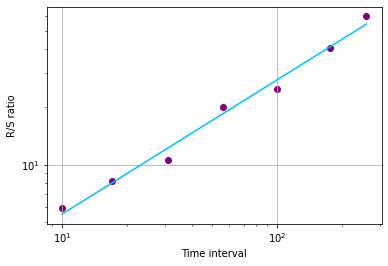

H=0.7014, c=1.0971


In [176]:
# Evaluate Hurst equation
H_m, c_m, data_m = compute_Hc(Monthly_AAPL_returns, kind='change', simplified=True)

# Plot
f, ax = plt.subplots()
ax.plot(data_m[0], c_m*data_m[0]**H_m, color="deepskyblue")
ax.scatter(data_m[0], data_m[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H_m, c_m))

In [ ]:
# Durant - Ease of location placeholder 

In [178]:
filtered_1_positive_dict_m = {key for (key, value) in lagged_monthly_correlations.items() if value > 0.05}
filtered_1_negative_dict_m = {key for (key, value) in lagged_monthly_correlations.items() if value < -0.05}

In [179]:
filtered_1_positive_dict_w = {key for (key, value) in lagged_weekly_correlations.items() if value > 0.05}
filtered_1_negative_dict_w = {key for (key, value) in lagged_weekly_correlations.items() if value < -0.05}

In [180]:
for i in filtered_1_positive_dict_m:
    print(i, lagged_monthly_correlations[i])

Pound/Dollar VOLATILITY_30D 0.07369618475967306
Pound/Dollar Ask price 0.08544740564638334
Oil VOLATILITY_10D 0.0713351421322728
Pound/Dollar Low price 0.08374393505772819
Pound/Dollar VOLATILITY_10D 0.06938112179668471
Gold/Dollar 5 Month Change 0.05835224764609055
Month_cos 0.05252706082178732
Pound/Dollar Opening price 0.0839891674120419
2 Period Change in 3 Month Interest Rate 0.05480711694234144
Oil VOLATILITY_30D 0.06731830005248993
Pound/Dollar Bid price 0.08532507042822042
Pound/Dollar High price 0.08521960376801359
AAPL Monthly Returns 0.12868825983900667
EUR-USD Exchange 0.134428120333844
Pound/Dollar 5 Month Change 0.09652172027839845
Pound/Dollar 3 Month Change 0.06281818454182446
Pound/Dollar Closing price 0.08539707839256004


In [181]:
for i in filtered_1_negative_dict_m:
    print(i, lagged_monthly_correlations[i])

Year_sin -0.06228313969339723
DJIA Price_sales_ratio -0.06650350969158154
Three Month Interest Rate -0.07944055242567813
VOLATILITY_10D -0.15317891236493034
VOLATILITY_30D -0.1350178246913033
DJIA Price_earning ratio -0.08417523165359012
DJIA Price_book_ratio -0.08635023682488438


In [182]:
for i in filtered_1_positive_dict_w:
    print(i, lagged_weekly_correlations[i])


EUR-USD Exchange 0.06422147404601396
AAPL Weekly Returns 0.12996832626464697


In [183]:
for i in filtered_1_negative_dict_w:
    print(i, lagged_weekly_correlations[i])


VOLATILITY_10D -0.10365102092013324
VOLATILITY_30D -0.0631024643028702
DJIA 3 Week Return -0.06101344754771166
Gold/Dollar 3 Week Change -0.05145577084085557


In [184]:
filtered_weekly_data = scaled_Weekly_AAPL_data[filtered_1_negative_dict_w].join(scaled_Weekly_AAPL_data[filtered_1_positive_dict_w])
filtered_weekly_data.head()

,VOLATILITY_10D,VOLATILITY_30D,DJIA 3 Week Return,Gold/Dollar 3 Week Change,EUR-USD Exchange,AAPL Weekly Returns
Dates,,,,,,
1999-06-20,-0.088124,0.155493,-2.398132,0.028926,-0.884080,0.014458
1999-06-27,0.013728,0.092947,-2.155641,0.018399,-0.883807,-0.106882
1999-07-04,0.290706,0.148410,-2.941057,0.001281,-0.926972,0.086591
1999-07-11,0.384627,0.131674,-0.859529,0.003106,-0.966383,0.200483
1999-07-18,0.747991,0.307666,-1.054911,0.010894,-0.992180,-0.046278


In [185]:
filtered_monthly_data = scaled_Monthly_AAPL_data[filtered_1_negative_dict_m].join(scaled_Monthly_AAPL_data[filtered_1_positive_dict_m])
filtered_monthly_data.head()

,Year_sin,DJIA Price_sales_ratio,Three Month Interest Rate,VOLATILITY_10D,VOLATILITY_30D,DJIA Price_earning ratio,DJIA Price_book_ratio,Pound/Dollar VOLATILITY_30D,Pound/Dollar Ask price,Oil VOLATILITY_10D,Pound/Dollar Low price,Pound/Dollar VOLATILITY_10D,Gold/Dollar 5 Month Change,Month_cos,Pound/Dollar Opening price,2 Period Change in 3 Month Interest Rate,Oil VOLATILITY_30D,Pound/Dollar Bid price,Pound/Dollar High price,AAPL Monthly Returns,EUR-USD Exchange,Pound/Dollar 5 Month Change,Pound/Dollar 3 Month Change,Pound/Dollar Closing price
Dates,,,,,,,,,,,,,,,,,,,,,,,,
1999-11-30,0.101168,2.559072,1.386795,0.390515,1.076479,2.057970,2.357451,-0.348435,-0.292191,-0.060628,-0.275489,-0.278427,0.479969,-0.612106,-0.278605,0.170993,0.225666,-0.292844,-0.292795,0.222378,-0.905373,9.222229,-8.063742,-0.292572
1999-12-31,0.101168,2.859573,1.451614,0.517740,0.445801,2.337396,2.634452,-0.585175,-0.331712,0.108952,-0.318236,-0.700605,0.886345,-0.758758,-0.334015,0.137328,0.122973,-0.332851,-0.343826,0.050343,-1.018477,-0.456712,-1.456043,-0.332247
2000-01-31,-0.101168,2.589408,1.508062,2.038334,1.232732,2.066941,2.326148,-0.702593,-0.191284,0.143667,-0.181813,-0.493776,1.082703,0.979530,-0.191564,0.087444,-0.010521,-0.192365,-0.199818,-0.026996,-1.011401,0.417359,-0.346508,-0.191695
2000-02-29,-0.101168,2.042238,1.632521,0.855925,1.322474,1.575877,1.817257,-0.235382,-0.400750,-0.509609,-0.396326,-0.032014,1.168355,0.918958,-0.392583,0.124625,-0.072782,-0.401605,-0.401976,0.104752,-1.161562,-4.668932,-0.482519,-0.400835
2000-03-31,-0.101168,1.993955,1.707066,1.571362,1.101952,1.526558,1.774568,-0.458618,-0.510695,0.668511,-0.503613,-0.927783,-1.300112,0.820763,-0.512017,0.131960,0.230338,-0.511570,-0.523733,0.185728,-1.261166,-1.425279,1.030104,-0.511186


In [186]:
T_w = 3
T_m = 3

X_W_AAPL, Y_W_AAPL = helper_funcs.create_datasets(T_w, 1, AAPL_0_returns_weekly.values, 'AAPL', scaled_Weekly_AAPL_data, False)
X_W_AAPL, Y_W_AAPL_BINARY = helper_funcs.create_datasets(T_w, 1,  AAPL_weekly_binary_returns.values, 'AAPL', scaled_Weekly_AAPL_data, False)

x_train_w_AAPL, y_train_w_AAPL, x_val_w_AAPL, y_val_w_AAPL, x_test_w_AAPL, y_test_w_AAPL = helper_funcs.data_split(X_W_AAPL, Y_W_AAPL)
x_train_w_AAPL, y_train_w_AAPL, x_val_w_AAPL, y_val_w_AAPL, x_test_w_AAPL, y_test_w_AAPL = x_train_w_AAPL.to(device), y_train_w_AAPL.to(device), x_val_w_AAPL.to(device), y_val_w_AAPL.to(device), x_test_w_AAPL.to(device), y_test_w_AAPL.to(device)

x_train_w_AAPL_b, y_train_w_AAPL_b, x_val_w_AAPL_b, y_val_w_AAPL_b, x_test_w_AAPL_b, y_test_w_AAPL_b = helper_funcs.data_split(X_W_AAPL, Y_W_AAPL_BINARY)
x_train_w_AAPL_b, y_train_w_AAPL_b, x_val_w_AAPL_b, y_val_w_AAPL_b, x_test_w_AAPL_b, y_test_w_AAPL_b = x_train_w_AAPL_b.to(device), y_train_w_AAPL_b.to(device), x_val_w_AAPL_b.to(device), y_val_w_AAPL_b.to(device), x_test_w_AAPL_b.to(device), y_test_w_AAPL_b.to(device)

Shape of X: (1122, 3, 50) Shape of Y: (1122, 1)
Shape of X: (1122, 3, 50) Shape of Y: (1122, 1)


In [187]:
X_M_AAPL, Y_M_AAPL = helper_funcs.create_datasets(T_m, 1,  AAPL_0_returns_monthly.values, 'AAPL', scaled_Monthly_AAPL_data, False)
X_M_AAPL, Y_M_AAPL_BINARY = helper_funcs.create_datasets(T_m, 1,  AAPL_monthly_binary_returns.values, 'AAPL', scaled_Monthly_AAPL_data, False)

x_train_m_AAPL_b, y_train_m_AAPL_b, x_val_m_AAPL_b, y_val_m_AAPL_b, x_test_m_AAPL_b, y_test_m_AAPL_b = helper_funcs.data_split(X_M_AAPL, Y_M_AAPL_BINARY)
x_train_m_AAPL_b, y_train_m_AAPL_b, x_val_m_AAPL_b, y_val_m_AAPL_b, x_test_m_AAPL_b, y_test_m_AAPL_b = x_train_m_AAPL_b.to(device), y_train_m_AAPL_b.to(device), x_val_m_AAPL_b.to(device), y_val_m_AAPL_b.to(device), x_test_m_AAPL_b.to(device), y_test_m_AAPL_b.to(device)

x_train_m_AAPL, y_train_m_AAPL, x_val_m_AAPL, y_val_m_AAPL, x_test_m_AAPL, y_test_m_AAPL = helper_funcs.data_split(X_M_AAPL, Y_M_AAPL)
x_train_m_AAPL, y_train_m_AAPL, x_val_m_AAPL, y_val_m_AAPL, x_test_m_AAPL, y_test_m_AAPL = x_train_m_AAPL.to(device), y_train_m_AAPL.to(device), x_val_m_AAPL.to(device), y_val_m_AAPL.to(device), x_test_m_AAPL.to(device), y_test_m_AAPL.to(device)

Shape of X: (251, 3, 57) Shape of Y: (251, 1)
Shape of X: (251, 3, 57) Shape of Y: (251, 1)


In [188]:
# This dataset will just use the monthly and weekly returns, respectively, as input

X_M_AAPL_RETURNS, Y_M_AAPL_TARGET = helper_funcs.create_datasets(T_m, 1, AAPL_monthly_binary_returns.values, 'AAPL', AAPL_monthly_binary_returns, False)
X_W_AAPL_RETURNS, Y_W_AAPL_TARGET = helper_funcs.create_datasets(T_w, 1, AAPL_weekly_binary_returns.values, 'AAPL', AAPL_weekly_binary_returns, False)

# Split the data into train-val-test

train_return_m_AAPL, y_train_return_m_AAPL, val_return_m_AAPL, y_val_return_m_AAPL, test_return_m_AAPL, y_test_return_m_AAPL = helper_funcs.data_split(X_M_AAPL_RETURNS, Y_M_AAPL_TARGET)
train_return_m_AAPL, y_train_return_m_AAPL, val_return_m_AAPL, y_val_return_m_AAPL, test_return_m_AAPL, y_test_return_m_AAPL = train_return_m_AAPL.to(device), y_train_return_m_AAPL.to(device), val_return_m_AAPL.to(device), y_val_return_m_AAPL.to(device), test_return_m_AAPL.to(device), y_test_return_m_AAPL.to(device)

train_return_w_AAPL, y_train_return_w_AAPL, val_return_w_AAPL, y_val_return_w_AAPL, test_return_w_AAPL, y_test_return_w_AAPL = helper_funcs.data_split(X_W_AAPL_RETURNS, Y_W_AAPL_TARGET)
train_return_w_AAPL, y_train_return_w_AAPL, val_return_w_AAPL, y_val_return_w_AAPL, test_return_w_AAPL, y_test_return_w_AAPL = train_return_w_AAPL.to(device), y_train_return_w_AAPL.to(device), val_return_w_AAPL.to(device), y_val_return_w_AAPL.to(device), test_return_w_AAPL.to(device), y_test_return_w_AAPL.to(device)



Shape of X: (251, 3, 1) Shape of Y: (251, 1)
Shape of X: (1122, 3, 1) Shape of Y: (1122, 1)


In [189]:
y = 0
for x in y_train_return_m_AAPL:
    if x == 1:
        y+=1
z = 0
for x in y_val_return_m_AAPL:
    if x == 1:
        z+=1 

u = 0
for x in y_test_return_m_AAPL:
    if x == 1:
        u+=1       
    
print('Monthly data: \n')
print(f'AAPL Train - Proportion of Positive Returns: {y/len(y_train_return_m_AAPL)}')
print(f'AAPL Validation - Proportion of Positive Returns: {z/len(y_val_return_m_AAPL)}')
print(f'AAPL Test - Proportion of Positive Returns: {u/len(y_test_return_m_AAPL)}')
print('\n')
print(f'AAPL Test Monthly - Average of Positive Returns: {(y+u+z)/(len(y_test_return_m_AAPL)+len(y_val_return_m_AAPL) + len(y_train_return_m_AAPL))}')
print('\n')

y = 0
for x in y_train_return_w_AAPL:
    if x == 1:
        y+=1
z = 0
for x in y_val_return_w_AAPL:
    if x == 1:
        z+=1 

u = 0
for x in y_test_return_w_AAPL:
    if x == 1:
        u+=1       
    
print('Weekly data: \n')
print(f'AAPL Train - Proportion of Positive Returns: {y/len(y_train_return_w_AAPL)}')
print(f'AAPL Validation - Proportion of Positive Returns: {z/len(y_val_return_w_AAPL)}')
print(f'AAPL Test - Proportion of Positive Returns: {u/len(y_test_return_w_AAPL)}')
print('\n')
print(f'AAPL Test Weekly - Average of Positive Returns: {(y+u+z)/(len(y_test_return_w_AAPL)+len(y_val_return_w_AAPL) + len(y_train_return_w_AAPL))}')
print('\n')

Monthly data: 

AAPL Train - Proportion of Positive Returns: 0.6266666666666667
AAPL Validation - Proportion of Positive Returns: 0.56
AAPL Test - Proportion of Positive Returns: 0.6274509803921569


AAPL Test Monthly - Average of Positive Returns: 0.6135458167330677


Weekly data: 

AAPL Train - Proportion of Positive Returns: 0.575037147102526
AAPL Validation - Proportion of Positive Returns: 0.5357142857142857
AAPL Test - Proportion of Positive Returns: 0.6266666666666667


AAPL Test Weekly - Average of Positive Returns: 0.5775401069518716




In [190]:
# Comparing the inputs for the models just taking the XOM and AAPL Returns

In [191]:
# Davis - word to search

Hidden = 100

AAPL_model_w = LSTM(len(X_W_AAPL.T), Hidden, 1, 1)
AAPL_model_w_b = LSTM(len(X_W_AAPL.T), Hidden, 1, 1)

AAPL_model_m = LSTM(len(X_M_AAPL.T), Hidden, 1, 1)
AAPL_model_m_b = LSTM(len(X_M_AAPL.T), Hidden, 1, 1)

AAPL_model_w.to(device)
AAPL_model_w_b.to(device)

AAPL_model_m.to(device)
AAPL_model_m_b.to(device)

# The models taking just the weekly and monthly returns as input 
AAPL_model_w_monthly_returns = LSTM(len(X_M_AAPL_RETURNS.T), Hidden, 1, 1) 
AAPL_model_w_weekly_returns = LSTM(len(X_W_AAPL_RETURNS.T), Hidden, 1, 1) 

AAPL_model_w_monthly_returns.to(device)
AAPL_model_w_weekly_returns.to(device)

learning_rate = 5e-3

optimizer_X_w_AAPL = torch.optim.Adam(AAPL_model_w.parameters(), lr = learning_rate)
optimizer_X_w_AAPL_b = torch.optim.Adam(AAPL_model_w_b.parameters(), lr = learning_rate)

optimizer_X_m_AAPL = torch.optim.Adam(AAPL_model_m.parameters(), lr = learning_rate)
optimizer_X_m_AAPL_b = torch.optim.Adam(AAPL_model_m_b.parameters(), lr = learning_rate)


# Just returns 
optimizer_w_monthly_returns = torch.optim.Adam(AAPL_model_w_monthly_returns.parameters(), lr = learning_rate)
optimizer_w_weekly_returns = torch.optim.Adam(AAPL_model_w_weekly_returns.parameters(), lr = learning_rate)

loss_function = nn.MSELoss()
binary_loss_function = nn.BCEWithLogitsLoss()

epochs = 250
train_loss_w_AAPL, val_loss_w_AAPL = full_gd(AAPL_model_w,
                                      loss_function,
                                      optimizer_X_w_AAPL,
                                      x_train_w_AAPL, 
                                      y_train_w_AAPL, 
                                      x_val_w_AAPL,
                                      y_val_w_AAPL, 
                                      epochs)

print('\n')
print('Training on the Monthly Returns')
# Just returns
train_loss_w_monthly_returns, val_loss_w_monthly_returns = full_gd(AAPL_model_w_monthly_returns,
                                      binary_loss_function,
                                      optimizer_w_monthly_returns,
                                      train_return_m_AAPL, 
                                      y_train_return_m_AAPL, 
                                      val_return_m_AAPL,
                                      y_val_return_m_AAPL, 
                                      epochs)
print('\n')
print('Training on the Weekly Returns')
train_loss_w_weekly_returns, val_loss_w_weekly_returns = full_gd(AAPL_model_w_weekly_returns,
                                      binary_loss_function,
                                      optimizer_w_weekly_returns,
                                      train_return_w_AAPL, 
                                      y_train_return_w_AAPL, 
                                      val_return_w_AAPL,
                                      y_val_return_w_AAPL, 
                                      epochs)

Epoch 25/250, Train Loss: 0.0025, Validation Loss: 0.0024
Epoch 50/250, Train Loss: 0.0012, Validation Loss: 0.0042
Epoch 75/250, Train Loss: 0.0005, Validation Loss: 0.0054
Epoch 100/250, Train Loss: 0.0002, Validation Loss: 0.0056
Epoch 125/250, Train Loss: 0.0000, Validation Loss: 0.0061
Epoch 150/250, Train Loss: 0.0000, Validation Loss: 0.0065
Epoch 175/250, Train Loss: 0.0000, Validation Loss: 0.0066
Epoch 200/250, Train Loss: 0.0000, Validation Loss: 0.0066
Epoch 225/250, Train Loss: 0.0000, Validation Loss: 0.0066
Epoch 250/250, Train Loss: 0.0000, Validation Loss: 0.0065


Training on the Monthly Returns
Epoch 25/250, Train Loss: 0.6521, Validation Loss: 0.6733
Epoch 50/250, Train Loss: 0.6425, Validation Loss: 0.6553
Epoch 75/250, Train Loss: 0.6367, Validation Loss: 0.6532
Epoch 100/250, Train Loss: 0.6342, Validation Loss: 0.6571
Epoch 125/250, Train Loss: 0.6337, Validation Loss: 0.6576
Epoch 150/250, Train Loss: 0.6336, Validation Loss: 0.6593
Epoch 175/250, Train Loss: 0

In [ ]:
# Weekly numerical predictions

weekly_unfiltered_predictions = helper_funcs.make_predictions(AAPL_model_w, x_test_w_AAPL, 
                                                              y_test_w_AAPL, T_w, len(X_W_AAPL.T), 1, False)

plt.plot(y_test_w_AAPL.cpu(), color = 'royalblue', label = 'True')
plt.plot(weekly_unfiltered_predictions, linestyle='-.', color = 'gold',label = 'Predicted')
plt.legend()
plt.show()

In [193]:
# Checking to see if model predictions have the same sign as the ground truths - testing hidden size etc 
# Before, one issue was that it seemed values were always positive meaning accuracy values were meaningless

print(AAPL_model_w_weekly_returns(val_return_w_AAPL)[-5:])

print('\n')

print(y_val_return_w_AAPL[-5:])

tensor([[0.3438],
        [0.3747],
        [0.3747],
        [0.1278],
        [0.6932]], device='cuda:0', grad_fn=<SliceBackward>)


tensor([[1.],
        [1.],
        [0.],
        [1.],
        [0.]], device='cuda:0')




Train acc: 0.5750, Validation acc: 0.5357 , Test acc: 0.6267 

Training 
 TP: 387.0000, TN: 0.0000 , FP: 286.0000. FN: 0.0000
Validation 
 TP: 120.0000, TN: 0.0000 , FP: 104.0000. FN: 0.0000
Test 
 TP: 141.0000, TN: 0.0000 , FP: 84.0000. FN: 0.0000
Weekly AAPL Training Data 

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


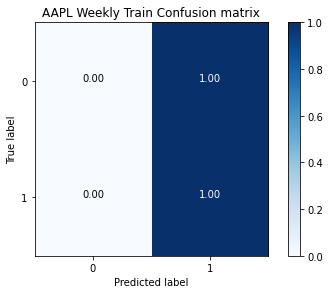

Weekly AAPL Validation Data 

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


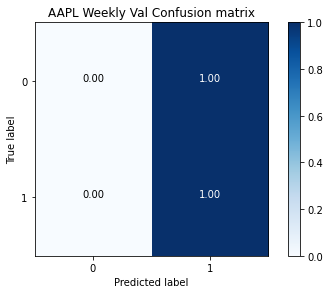

Weekly AAPL Test Data 

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


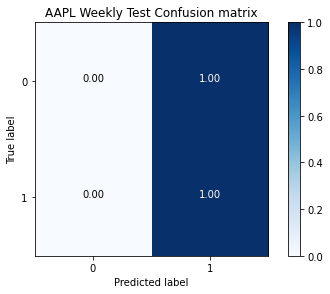

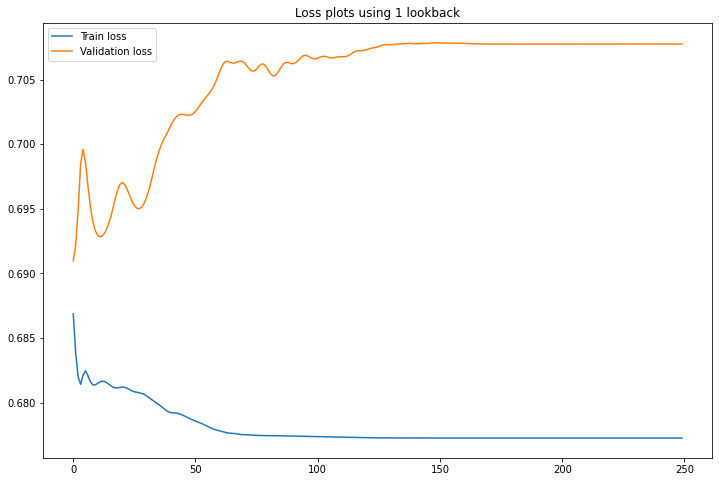

In [194]:
print('\n')
# Get the accuracy for each model with different T
AAPL_model_w_weekly_returns.eval()
with torch.no_grad():
  p_train = AAPL_model_w_weekly_returns(train_return_w_AAPL)
  p_train = (p_train.cpu().numpy() > 0)
  train_acc_w_just_returns = np.mean(y_train_return_w_AAPL.cpu().numpy() == p_train)

  p_val = AAPL_model_w_weekly_returns(val_return_w_AAPL)
  p_val = (p_val.cpu().numpy() > 0)
  val_acc_w_just_returns = np.mean(y_val_return_w_AAPL.cpu().numpy() == p_val)

  p_test = AAPL_model_w_weekly_returns(test_return_w_AAPL)
  p_test = (p_test.cpu().numpy() > 0)
  test_acc_w_just_returns = np.mean(y_test_return_w_AAPL.cpu().numpy() == p_test)

# Train acc: 0.5731, Validation acc: 0.5402 , Test acc: 0.6250
# Train acc: 0.5748, Validation acc: 0.5378 , Test acc: 0.6239

train_tn, train_fp, train_fn, train_tp = confusion_matrix(y_train_return_w_AAPL.cpu().numpy(), p_train, labels = [0,1]).ravel()
val_tn, val_fp, val_fn, val_tp = confusion_matrix(y_val_return_w_AAPL.cpu().numpy(), p_val, labels = [0,1]).ravel()
test_tn, test_fp, test_fn, test_tp = confusion_matrix(y_test_return_w_AAPL.cpu().numpy(), p_test, labels = [0,1]).ravel()
print(f"Train acc: {train_acc_w_just_returns:.4f}, Validation acc: {val_acc_w_just_returns:.4f} , Test acc: {test_acc_w_just_returns:.4f} \n")
print(f"Training \n TP: {train_tp:.4f}, TN: {train_tn:.4f} , FP: {train_fp:.4f}. FN: {train_fn:.4f}")
print(f"Validation \n TP: {val_tp:.4f}, TN: {val_tn:.4f} , FP: {val_fp:.4f}. FN: {val_fn:.4f}")
print(f"Test \n TP: {test_tp:.4f}, TN: {test_tn:.4f} , FP: {test_fp:.4f}. FN: {test_fn:.4f}")

# Weekly AAPL Training Data
print('Weekly AAPL Training Data \n')
cm = confusion_matrix(y_train_return_w_AAPL.cpu().numpy(), p_train)
plot_confusion_matrix("AAPL", "Weekly", "Train", False, cm, list(range(2)), normalize=True)

# Weekly AAPL Validation Data
print('Weekly AAPL Validation Data \n')
cm = confusion_matrix(y_val_return_w_AAPL.cpu().numpy(), p_val)
plot_confusion_matrix("AAPL", "Weekly", "Val", False, cm, list(range(2)), normalize=True)

# Weekly AAPL Test Data
print('Weekly AAPL Test Data \n')
cm = confusion_matrix(y_test_return_w_AAPL.cpu().numpy(), p_test)
plot_confusion_matrix("AAPL", "Weekly", "Test", False, cm, list(range(2)), normalize=True)

print('\n')

plot_loss_funcs(train_loss_w_weekly_returns, val_loss_w_weekly_returns, 1)

In [195]:
y = 0
for x in y_test_return_m_AAPL:
    if x == 1:
        y+=1
z = 0
for x in y_train_return_m_AAPL:
    if x == 1:
        z+=1 

u = 0
for x in y_val_return_m_AAPL:
    if x == 1:
        u+=1       
    
print(f'AAPL Train Proportion: {z/len(y_train_return_m_AAPL)}')
print(f'AAPL Validation Proportion: {u/len(y_val_return_m_AAPL)}')
print(f'AAPL Test Proportion: {y/len(y_test_return_m_AAPL)}')



AAPL Train Proportion: 0.6266666666666667
AAPL Validation Proportion: 0.56
AAPL Test Proportion: 0.6274509803921569




Train acc: 0.6600, Validation acc: 0.5800 , Test acc: 0.6078 

Training 
 TP: 90.0000, TN: 9.0000 , FP: 47.0000. FN: 4.0000
Validation 
 TP: 27.0000, TN: 2.0000 , FP: 20.0000. FN: 1.0000
Test 
 TP: 29.0000, TN: 2.0000 , FP: 17.0000. FN: 3.0000
Monthly AAPL Training Data 

Normalized confusion matrix
[[0.16071429 0.83928571]
 [0.04255319 0.95744681]]


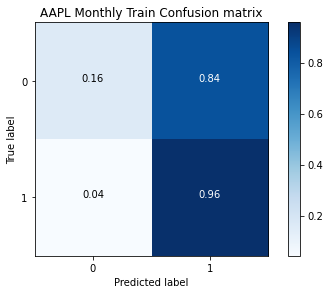

Monthly AAPL Validation Data 

Normalized confusion matrix
[[0.09090909 0.90909091]
 [0.03571429 0.96428571]]


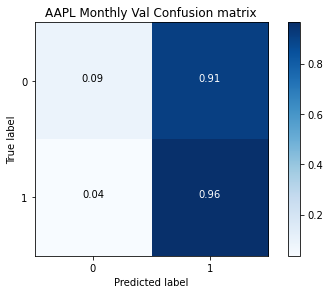

Monthly AAPL Test Data 

Normalized confusion matrix
[[0.10526316 0.89473684]
 [0.09375    0.90625   ]]


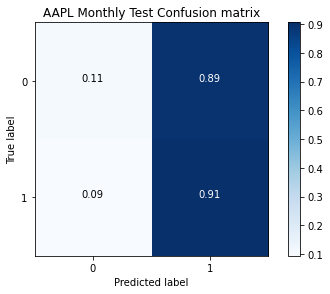

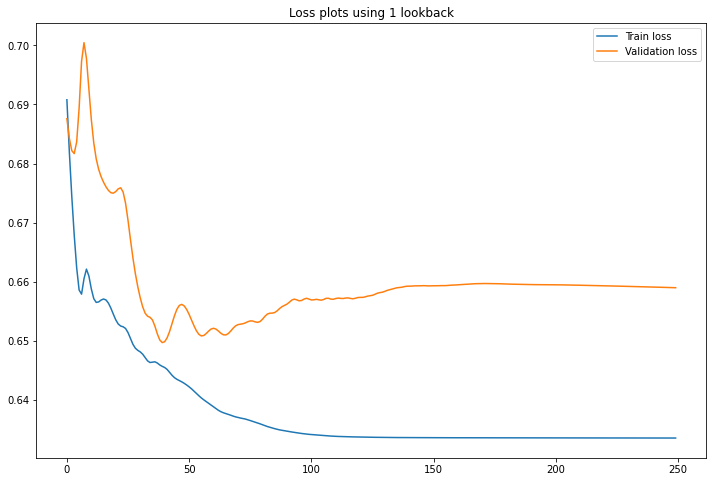

In [196]:
print('\n')
# Get the accuracy for each model with different T
AAPL_model_w_monthly_returns.eval()
with torch.no_grad():
  p_train = AAPL_model_w_monthly_returns(train_return_m_AAPL)
  p_train = (p_train.cpu().numpy() > 0)
  train_acc_m_just_returns = np.mean(y_train_return_m_AAPL.cpu().numpy() == p_train)

  p_val = AAPL_model_w_monthly_returns(val_return_m_AAPL)
  p_val = (p_val.cpu().numpy() > 0)
  val_acc_m_just_returns = np.mean(y_val_return_m_AAPL.cpu().numpy() == p_val)

  p_test = AAPL_model_w_monthly_returns(test_return_m_AAPL)
  p_test = (p_test.cpu().numpy() > 0)
  test_acc_m_just_returns = np.mean(y_test_return_m_AAPL.cpu().numpy() == p_test)

# Train acc: 0.6250, Validation acc: 0.5686 , Test acc: 0.6275
# Train acc: 0.6494, Validation acc: 0.5686 , Test acc: 0.6346

train_tn, train_fp, train_fn, train_tp = confusion_matrix(y_train_return_m_AAPL.cpu().numpy(), p_train, labels=[0,1]).ravel()
val_tn, val_fp, val_fn, val_tp = confusion_matrix(y_val_return_m_AAPL.cpu().numpy(), p_val, labels=[0,1]).ravel()
test_tn, test_fp, test_fn, test_tp = confusion_matrix(y_test_return_m_AAPL.cpu().numpy(), p_test, labels=[0,1]).ravel()

print(f"Train acc: {train_acc_m_just_returns:.4f}, Validation acc: {val_acc_m_just_returns:.4f} , Test acc: {test_acc_m_just_returns:.4f} \n")
print(f"Training \n TP: {train_tp:.4f}, TN: {train_tn:.4f} , FP: {train_fp:.4f}. FN: {train_fn:.4f}")
print(f"Validation \n TP: {val_tp:.4f}, TN: {val_tn:.4f} , FP: {val_fp:.4f}. FN: {val_fn:.4f}")
print(f"Test \n TP: {test_tp:.4f}, TN: {test_tn:.4f} , FP: {test_fp:.4f}. FN: {test_fn:.4f}")

# Monthly AAPL Training Data
print('Monthly AAPL Training Data \n')
cm = confusion_matrix(y_train_return_m_AAPL.cpu().numpy(), p_train)
plot_confusion_matrix("AAPL", "Monthly", "Train", False, cm, list(range(2)), normalize=True)

# Monthly AAPL Validation Data
print('Monthly AAPL Validation Data \n')
cm = confusion_matrix(y_val_return_m_AAPL.cpu().numpy(), p_val)
plot_confusion_matrix("AAPL", "Monthly", "Val", False, cm, list(range(2)), normalize=True)

# Monthly AAPL Test Data
print('Monthly AAPL Test Data \n')
cm = confusion_matrix(y_test_return_m_AAPL.cpu().numpy(), p_test)
plot_confusion_matrix("AAPL", "Monthly", "Test", False, cm, list(range(2)), normalize=True)

print('\n')

plot_loss_funcs(train_loss_w_monthly_returns, val_loss_w_monthly_returns, 1)

In [ ]:
print('/n')
train_loss_m_AAPL, val_loss_m_AAPL = full_gd(AAPL_model_m,
                                      loss_function,
                                      optimizer_X_m_AAPL,
                                      x_train_m_AAPL, 
                                      y_train_m_AAPL, 
                                      x_val_m_AAPL,
                                      y_val_m_AAPL, 
                                      epochs)

In [198]:
AAPL_model_w_b.train()
train_loss_w_AAPL_b, val_loss_w_AAPL_b = full_gd(AAPL_model_w_b,
                                      binary_loss_function,
                                      optimizer_X_w_AAPL_b,
                                      x_train_w_AAPL_b, 
                                      y_train_w_AAPL_b, 
                                      x_val_w_AAPL_b,
                                      y_val_w_AAPL_b, 
                                      epochs)

Epoch 25/250, Train Loss: 0.3556, Validation Loss: 1.0425
Epoch 50/250, Train Loss: 0.0193, Validation Loss: 2.7746
Epoch 75/250, Train Loss: 0.0020, Validation Loss: 3.5331
Epoch 100/250, Train Loss: 0.0010, Validation Loss: 3.7513
Epoch 125/250, Train Loss: 0.0007, Validation Loss: 3.8755
Epoch 150/250, Train Loss: 0.0005, Validation Loss: 3.9717
Epoch 175/250, Train Loss: 0.0004, Validation Loss: 4.0539
Epoch 200/250, Train Loss: 0.0004, Validation Loss: 4.1276
Epoch 225/250, Train Loss: 0.0003, Validation Loss: 4.1950
Epoch 250/250, Train Loss: 0.0003, Validation Loss: 4.2571




Train acc: 1.0000, Validation acc: 0.5179 , Test acc: 0.5422 

Training 
 TP: 387.0000, TN: 286.0000 , FP: 0.0000. FN: 0.0000
Validation 
 TP: 96.0000, TN: 20.0000 , FP: 84.0000. FN: 24.0000
Test 
 TP: 96.0000, TN: 26.0000 , FP: 58.0000. FN: 45.0000
Weekly AAPL Training Data 

Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


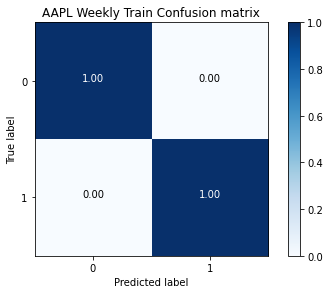

Weekly AAPL Validation Data 

Normalized confusion matrix
[[0.19230769 0.80769231]
 [0.2        0.8       ]]


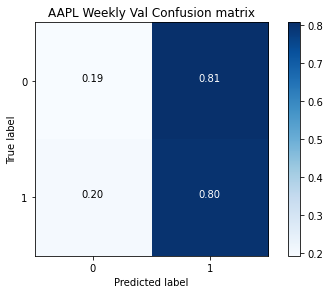

Weekly AAPL Test Data 

Normalized confusion matrix
[[0.30952381 0.69047619]
 [0.31914894 0.68085106]]


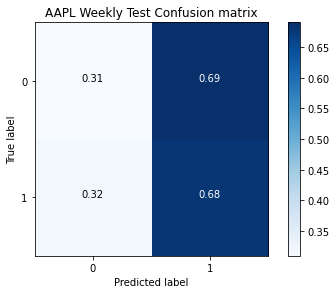

In [199]:
print('\n')
# Get the accuracy for each model with different T
# This model takes more features - not just returns 
AAPL_model_w_b.eval()
with torch.no_grad():
  p_train = AAPL_model_w_b(x_train_w_AAPL_b)
  p_train = (p_train.cpu().numpy() > 0)
  train_acc_w = np.mean(y_train_w_AAPL_b.cpu().numpy() == p_train)

  p_val = AAPL_model_w_b(x_val_w_AAPL_b)
  p_val = (p_val.cpu().numpy() > 0)
  val_acc_w = np.mean(y_val_w_AAPL_b.cpu().numpy() == p_val)

  p_test = AAPL_model_w_b(x_test_w_AAPL_b)
  p_test = (p_test.cpu().numpy() > 0)
  test_acc_w = np.mean(y_test_w_AAPL_b.cpu().numpy() == p_test)

# Train acc: 0.5982, Validation acc: 0.5381 , Test acc: 0.6188
# Train acc: 0.6503, Validation acc: 0.5312 , Test acc: 0.6222

train_tn, train_fp, train_fn, train_tp = confusion_matrix(y_train_w_AAPL_b.cpu().numpy(), p_train, labels = [0,1]).ravel()
val_tn, val_fp, val_fn, val_tp = confusion_matrix(y_val_w_AAPL_b.cpu().numpy(), p_val, labels = [0,1]).ravel()
test_tn, test_fp, test_fn, test_tp = confusion_matrix(y_test_w_AAPL_b.cpu().numpy(), p_test, labels = [0,1]).ravel()

print(f"Train acc: {train_acc_w:.4f}, Validation acc: {val_acc_w:.4f} , Test acc: {test_acc_w:.4f} \n")
print(f"Training \n TP: {train_tp:.4f}, TN: {train_tn:.4f} , FP: {train_fp:.4f}. FN: {train_fn:.4f}")
print(f"Validation \n TP: {val_tp:.4f}, TN: {val_tn:.4f} , FP: {val_fp:.4f}. FN: {val_fn:.4f}")
print(f"Test \n TP: {test_tp:.4f}, TN: {test_tn:.4f} , FP: {test_fp:.4f}. FN: {test_fn:.4f}")

# Weekly AAPL Training Data
print('Weekly AAPL Training Data \n')
cm = confusion_matrix(y_train_w_AAPL_b.cpu().numpy(), p_train)
plot_confusion_matrix("AAPL", "Weekly", "Train", False,cm, list(range(2)), normalize=True)

# Weekly AAPL Validation Data
print('Weekly AAPL Validation Data \n')
cm = confusion_matrix(y_val_w_AAPL_b.cpu().numpy(), p_val)
plot_confusion_matrix("AAPL", "Weekly", "Val", False,cm, list(range(2)), normalize=True)

# Weekly AAPL Test Data
print('Weekly AAPL Test Data \n')
cm = confusion_matrix(y_test_w_AAPL_b.cpu().numpy(), p_test)
plot_confusion_matrix("AAPL", "Weekly", "Test",False, cm, list(range(2)), normalize=True)

In [ ]:
AAPL_model_m_b.train()
train_loss_m_AAPL_b, val_loss_m_AAPL_b = full_gd(AAPL_model_m_b,
                                      binary_loss_function,
                                      optimizer_X_m_AAPL_b,
                                      x_train_m_AAPL_b, 
                                      y_train_m_AAPL_b, 
                                      x_val_m_AAPL_b,
                                      y_val_m_AAPL_b, 
                                      epochs)



Train acc: 1.0000, Validation acc: 0.5400 , Test acc: 0.5686 

Training 
 TP: 94.0000, TN: 56.0000 , FP: 0.0000. FN: 0.0000
Validation 
 TP: 24.0000, TN: 3.0000 , FP: 19.0000. FN: 4.0000
Test 
 TP: 16.0000, TN: 13.0000 , FP: 6.0000. FN: 16.0000
Monthly AAPL Training Data 

Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


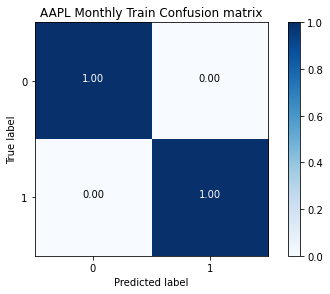

Monthly AAPL Validation Data 

Normalized confusion matrix
[[0.13636364 0.86363636]
 [0.14285714 0.85714286]]


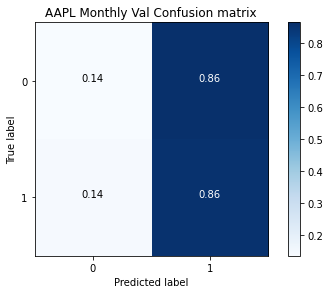

Monthly AAPL Test Data 

Normalized confusion matrix
[[0.68421053 0.31578947]
 [0.5        0.5       ]]


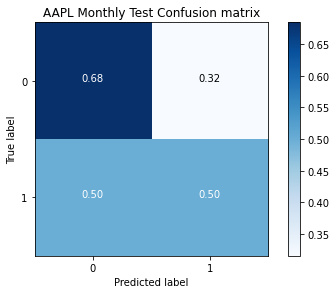

In [201]:
print('\n')
# Get the accuracy for the model
AAPL_model_m_b.eval()
with torch.no_grad():
  p_train = AAPL_model_m_b(x_train_m_AAPL_b)
  p_train = (p_train.cpu().numpy() > 0)
  train_acc_m = np.mean(y_train_m_AAPL_b.cpu().numpy() == p_train)

  p_val = AAPL_model_m_b(x_val_m_AAPL_b)
  p_val = (p_val.cpu().numpy() > 0)
  val_acc_m = np.mean(y_val_m_AAPL_b.cpu().numpy() == p_val)

  p_test = AAPL_model_m_b(x_test_m_AAPL_b)
  p_test = (p_test.cpu().numpy() > 0)
  test_acc_m = np.mean(y_test_m_AAPL_b.cpu().numpy() == p_test)

# Train acc: 0.5539, Validation acc: 0.6400 , Test acc: 0.6538
# Train acc: 0.7815, Validation acc: 0.5098 , Test acc: 0.6667

train_tn, train_fp, train_fn, train_tp = confusion_matrix(y_train_m_AAPL_b.cpu().numpy(), p_train, labels = [0,1]).ravel()
val_tn, val_fp, val_fn, val_tp = confusion_matrix(y_val_m_AAPL_b.cpu().numpy(), p_val, labels = [0,1]).ravel()
test_tn, test_fp, test_fn, test_tp = confusion_matrix(y_test_m_AAPL_b.cpu().numpy(), p_test, labels = [0,1]).ravel()

print(f"Train acc: {train_acc_m:.4f}, Validation acc: {val_acc_m:.4f} , Test acc: {test_acc_m:.4f} \n")
print(f"Training \n TP: {train_tp:.4f}, TN: {train_tn:.4f} , FP: {train_fp:.4f}. FN: {train_fn:.4f}")
print(f"Validation \n TP: {val_tp:.4f}, TN: {val_tn:.4f} , FP: {val_fp:.4f}. FN: {val_fn:.4f}")
print(f"Test \n TP: {test_tp:.4f}, TN: {test_tn:.4f} , FP: {test_fp:.4f}. FN: {test_fn:.4f}")

# Monthly AAPL Training Data
print('Monthly AAPL Training Data \n')
cm = confusion_matrix(y_train_m_AAPL_b.cpu().numpy(), p_train)
plot_confusion_matrix("AAPL", "Monthly", "Train", False,cm, list(range(2)), normalize=True)

# Monthly AAPL Validation Data
print('Monthly AAPL Validation Data \n')
cm = confusion_matrix(y_val_m_AAPL_b.cpu().numpy(), p_val)
plot_confusion_matrix("AAPL", "Monthly", "Val", False,cm, list(range(2)), normalize=True)

# Monthly AAPL Test Data
print('Monthly AAPL Test Data \n')
cm = confusion_matrix(y_test_m_AAPL_b.cpu().numpy(), p_test)
plot_confusion_matrix("AAPL", "Monthly", "Test",False, cm, list(range(2)), normalize=True)

#### Binary model used on the entire AAPL dataset to see entire performance

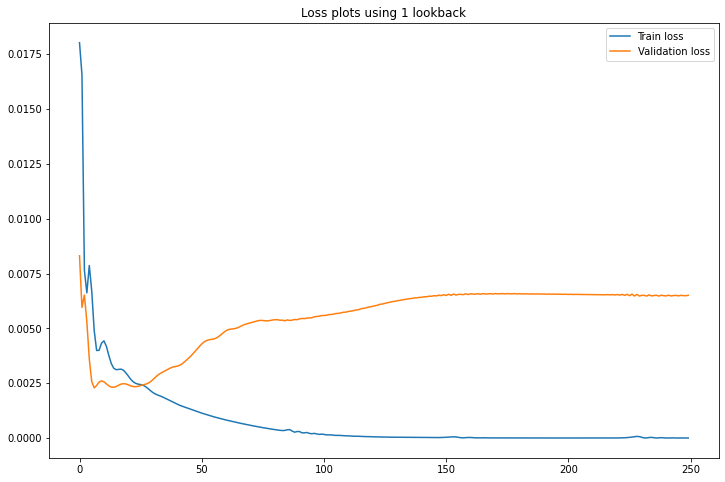

In [202]:
plot_loss_funcs(train_loss_w_AAPL, val_loss_w_AAPL, 1)

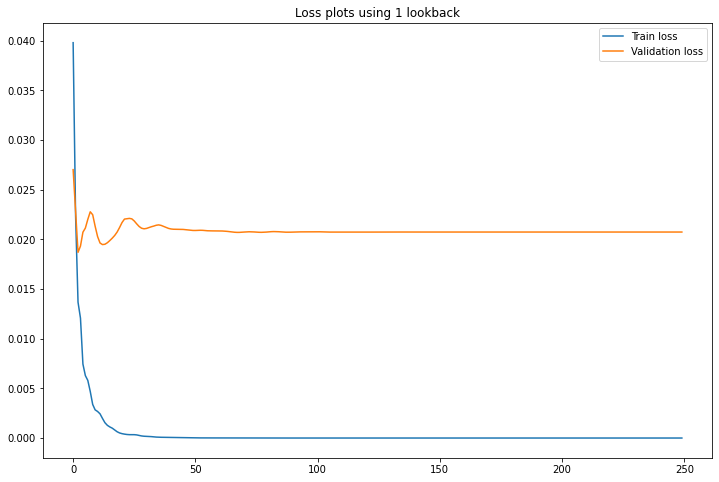

In [203]:
plot_loss_funcs(train_loss_m_AAPL, val_loss_m_AAPL, 1)

# One-step numerical predictions for the weekly and monthly AAPL data

In [204]:
weekly_predictions = helper_funcs.make_predictions(AAPL_model_w, x_test_w_AAPL, 
                                                   y_test_w_AAPL, T_w, len(x_test_w_AAPL.T), 1, False)

In [205]:
#weekly_predictions_train = helper_funcs.make_predictions(AAPL_model_w, x_train_w_AAPL, y_train_w_AAPL, T_w, len(x_test_w_AAPL.T))
#plot_predicted_returns(weekly_predictions_train, y_train_w_AAPL)

In [206]:
#monthly_predictions_train = helper_funcs.make_predictions(AAPL_model_m, x_train_m_AAPL, y_train_m_AAPL, T_m, len(x_test_m_AAPL.T))
#plot_predicted_returns(monthly_predictions_train, y_train_m_AAPL)

In [207]:
monthly_predictions = helper_funcs.make_predictions(AAPL_model_m, x_test_m_AAPL, 
                                                    y_test_m_AAPL, T_m, len(x_test_m_AAPL.T), 1, False)

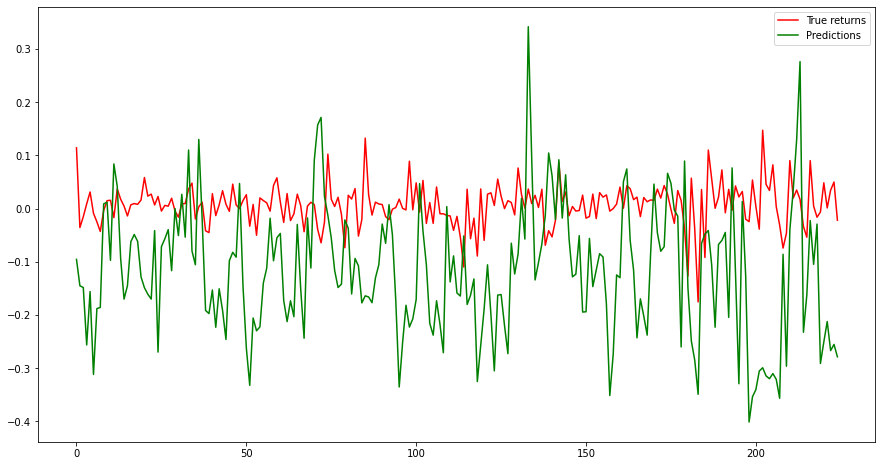

In [208]:
plot_predicted_returns(weekly_predictions, y_test_w_AAPL)

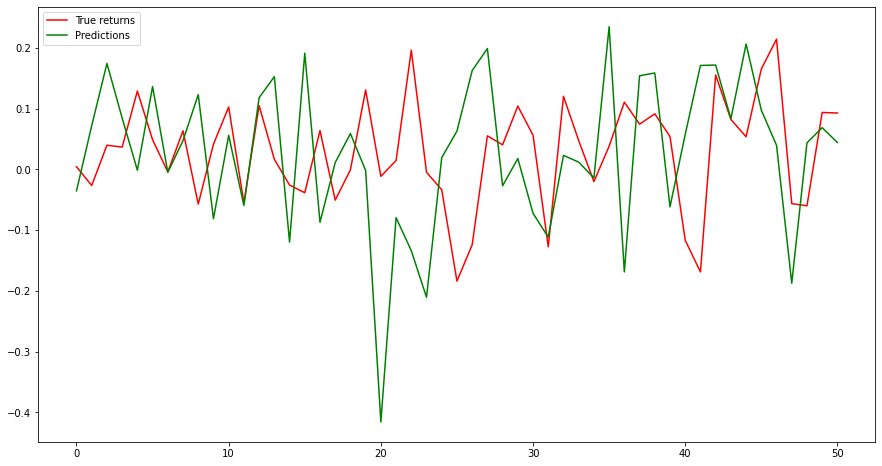

In [209]:
plot_predicted_returns(monthly_predictions, y_test_m_AAPL)

# Kalman Filter using XOM simulations, engineered features to make 1-step predictions 

In [210]:
# Kyrie
x = [i for i in range(1000)]

# Uncomment these when starting afresh 
FBM_sim = pd.read_csv('/content/gdrive/MyDrive/MSc_Thesis/Exon_Mobil_Data/Fractional_Brownian_Motion_simulation.csv', names = x)
MRW_sim = pd.read_csv('/content/gdrive/MyDrive/MSc_Thesis/Exon_Mobil_Data/Multifractal_Random_Walk_simulation.csv', names = x)

print(FBM_sim.shape)
print(MRW_sim.shape)
print(XOM_data.shape)
observations = XOM_data.set_index(XOM_data['Dates'])
observations = observations[:'2019-10-23']
ground_truth_returns = observations['Daily Return'][:'2019-10-23'] + 1
print(observations.shape)

(5362, 1000)
(5362, 1000)
(5762, 18)
(5362, 18)


In [ ]:
FBM_sim.set_index(ground_truth_returns.index, inplace=True)
MRW_sim.set_index(ground_truth_returns.index, inplace=True)
#FBM_sim = FBM_sim/100
#MRW_sim = MRW_sim/100

FBM_mean_returns = FBM_sim.mean(axis = 1)
MRW_mean_returns = MRW_sim.mean(axis = 1)

print(FBM_mean_returns.head())

FBM_sim.tail()

In [ ]:
FBM_monthly_returns = (1+FBM_mean_returns).groupby(pd.Grouper(freq='M')).prod()
FBM_weekly_returns = (1+FBM_mean_returns).groupby(pd.Grouper(freq='W')).prod()

MRW_monthly_returns = (1+MRW_mean_returns).groupby(pd.Grouper(freq='M')).prod()
MRW_weekly_returns = (1+MRW_mean_returns).groupby(pd.Grouper(freq='W')).prod()

FBM_monthly_variance = np.var(FBM_monthly_returns)
FBM_weekly_variance = np.var(FBM_weekly_returns)

MRW_monthly_variance = np.var(MRW_monthly_returns)
MRW_weekly_variance = np.var(MRW_weekly_returns)

FBM_daily_returns = (1+FBM_mean_returns)
MRW_daily_returns = (1+MRW_mean_returns)

# I will do a running variance for the observations as they become available in real time 

In [213]:
observations.dropna(inplace=True)
observations

,Dates,XOM Closing price,XOM Opening price,XOM Bid price,XOM Ask price,XOM High price,XOM Low price,XOM VOLATILITY_10D,XOM VOLATILITY_30D,XOM Price_earning ratio,XOM Price_book_ratio,XOM Current_ratio,XOM Price_sales_ratio,XOM Dividend_payout_ratio,XOM INTEREST_COVERAGE_RATIO,XOM Adjusted Beta,XOM Adjusted alpha,Daily Return
Dates,,,,,,,,,,,,,,,,,,
1999-04-07,1999-04-07,36.5938,36.3438,36.4375,36.7500,36.6250,36.0313,25.316,29.506,29.3926,4.1407,0.8854,1.3166,98.0272,6.4560,0.7950,-0.0018,0.006879
1999-04-08,1999-04-08,37.1250,36.7188,36.9688,37.2813,37.3125,36.4688,25.956,29.690,29.8193,4.2009,0.8854,1.3357,98.0272,6.4560,0.7959,0.0017,0.014516
1999-04-09,1999-04-09,37.3438,37.0313,37.1875,37.5000,37.4688,36.6875,25.920,29.349,29.9950,4.2256,0.8854,1.3436,98.0272,6.4560,0.7961,0.0022,0.005894
1999-04-12,1999-04-12,37.7188,37.3438,37.6563,37.7813,37.9375,37.0000,24.551,28.362,30.2962,4.2680,0.8854,1.3570,98.0272,6.4560,0.7947,0.0005,0.010042
1999-04-13,1999-04-13,37.5938,37.5000,37.5938,37.7813,37.8750,37.2813,19.142,28.284,30.1958,4.2539,0.8854,1.3526,98.0272,6.4560,0.7947,0.0007,-0.003314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-17,2019-10-17,68.1400,68.4800,68.1400,68.1500,68.8847,68.0800,20.225,18.908,19.2980,1.5180,0.7790,1.1157,119.0221,14.3362,0.9230,-0.0633,-0.001319
2019-10-18,2019-10-18,67.6100,67.8700,67.6100,67.6200,68.1500,67.6100,19.244,18.778,19.1479,1.5062,0.7790,1.1070,119.0221,14.3362,0.9232,-0.0635,-0.007778
2019-10-21,2019-10-21,68.7400,67.8200,68.7300,68.7400,68.7700,67.8200,17.417,19.362,19.4679,1.5314,0.7790,1.1255,119.0221,14.3362,0.9247,-0.0626,0.016714


In [214]:
real = []
FBM_simulated_price = []
MRW_simulated_price = []

o = observations['XOM Closing price'][0]* (observations['Daily Return'] + 1)[0]
p = observations['XOM Closing price'][0]* (FBM_mean_returns + 1)[0]
q = observations['XOM Closing price'][0]* (MRW_mean_returns + 1)[0]

real.append(o)
FBM_simulated_price.append(p)
MRW_simulated_price.append(q)

for u in range(len(observations['Daily Return'])-1):

    o = real[u] * (observations['Daily Return'] + 1)[u]
    p = FBM_simulated_price[u] * (FBM_mean_returns + 1)[u]
    q = MRW_simulated_price[u] * (MRW_mean_returns + 1)[u]

    real.append(o)
    FBM_simulated_price.append(p)
    MRW_simulated_price.append(q)

real = pd.Series(real, index = observations['XOM Closing price'].index)
FBM_simulated_price = pd.Series(FBM_simulated_price, index = observations['XOM Closing price'].index)
MRW_simulated_price = pd.Series(MRW_simulated_price, index = observations['XOM Closing price'].index)

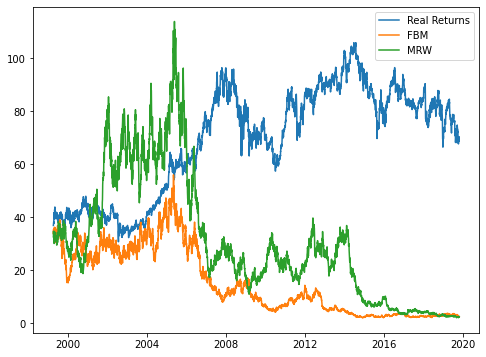

In [215]:
plt.figure(figsize=(8,6))
plt.plot(real, label = 'Real Returns')
plt.plot(FBM_simulated_price, label = 'FBM')
plt.plot(MRW_simulated_price, label = 'MRW')
#plt.plot(observations['XOM Closing price'], color = 'red', linestyle = 'dashed', label = 'Observation')
plt.legend()
plt.show()

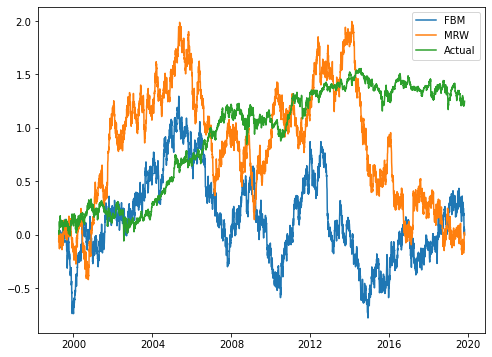

In [216]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(FBM_daily_returns-1), label = 'FBM')
plt.plot(np.cumsum(MRW_daily_returns-1), label = 'MRW')
plt.plot(np.cumsum(ground_truth_returns-1), label = 'Actual')
plt.legend()
plt.show()

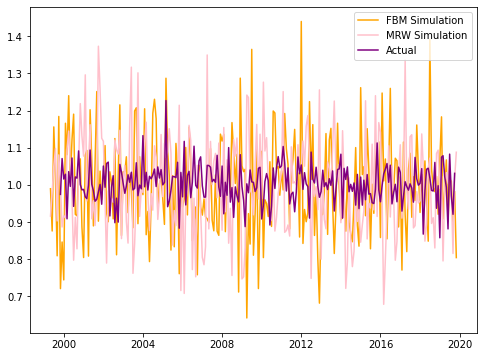

In [217]:
# Monthly
plt.figure(figsize=(8,6))
plt.plot(FBM_monthly_returns, label='FBM Simulation', color = 'orange')
plt.plot(MRW_monthly_returns, label='MRW Simulation',  color = 'pink')
plt.plot(XOM_returns_m.loc[:'2019-10-23'], label='Actual',  color = 'purple')
plt.legend()
plt.show()

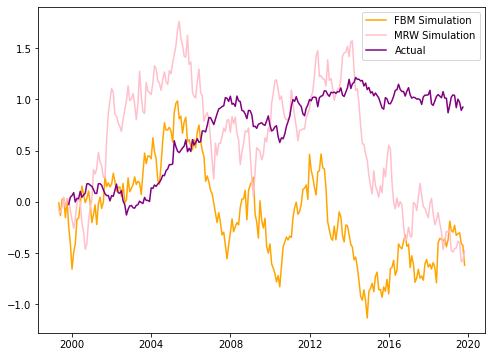

In [218]:
# Monthly
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(FBM_monthly_returns-1), label='FBM Simulation', color = 'orange')
plt.plot(np.cumsum(MRW_monthly_returns-1), label='MRW Simulation',  color = 'pink')
plt.plot(np.cumsum(XOM_returns_m.loc[:'2019-10-23']-1), label='Actual',  color = 'purple')
plt.legend()
plt.show()

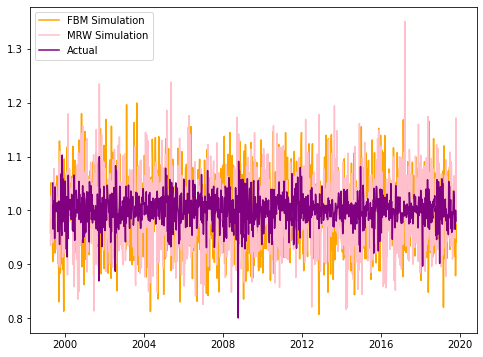

In [219]:
# Weekly
plt.figure(figsize=(8,6))
plt.plot(FBM_weekly_returns, label='FBM Simulation', color = 'orange')
plt.plot(MRW_weekly_returns, label='MRW Simulation',  color = 'pink')
plt.plot(XOM_returns_w.loc[:'2019-10-23'], label='Actual',  color = 'purple')
plt.legend()
plt.show()

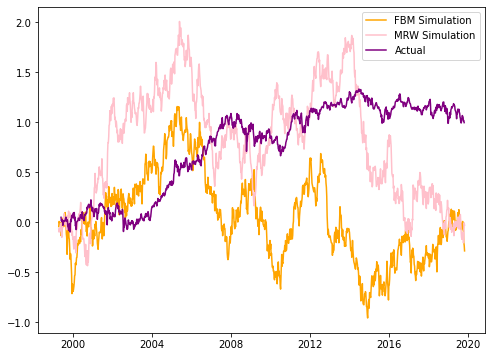

In [220]:
# Weekly
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(FBM_weekly_returns-1), label='FBM Simulation', color = 'orange')
plt.plot(np.cumsum(MRW_weekly_returns-1), label='MRW Simulation',  color = 'pink')
plt.plot(np.cumsum(XOM_returns_w.loc[:'2019-10-23']-1), label='Actual',  color = 'purple')
plt.legend()
plt.show()

In [221]:
import collections 

assimilated_results_m = collections.deque()

# Running variance of the observations 

start_date = '1999-10-31'
end_date = '2019-10-23'

observations = collections.deque()         # FBM_monthly_returns

for i in range(len(XOM_returns_m.loc[start_date:end_date]) - 1): # When looking at the mean over trading days do len(FBM_no_mean), else len(FBM_no_mean.T)

    observations.append(XOM_returns_m.loc[start_date:end_date].values[i])
    returns_var = np.var(observations)

    Kalman_gain = FBM_monthly_variance * 1/(FBM_monthly_variance + returns_var) # Using this gives the mean over trading days
    
    x_analysis_obs = FBM_monthly_returns[i] + Kalman_gain * (observations[i] - FBM_monthly_returns[i])
    
    assimilated_results_m.append(x_analysis_obs - 1)

assimilated_results_m = pd.DataFrame(assimilated_results_m, index = FBM_monthly_returns.loc[start_date:end_date].index[:-1])
    

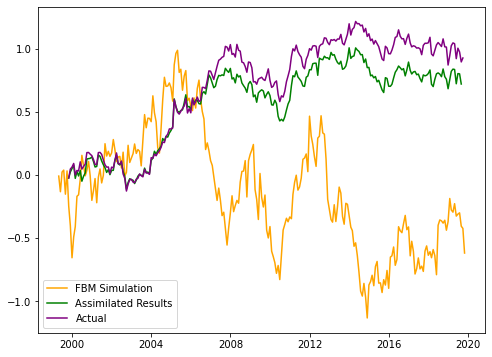

In [222]:
# Monthly
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(FBM_monthly_returns-1), label='FBM Simulation', color = 'orange')
plt.plot(np.cumsum(assimilated_results_m), label='Assimilated Results',  color = 'green')
plt.plot(np.cumsum(XOM_returns_m.loc[start_date:'2019-10-23']-1), label='Actual',  color = 'purple') #'2019-10-23'
plt.legend()
plt.show()

# KF idea for Rossella 

In [223]:

train_data_proportion = 3/5 
train_data = filtered_monthly_data[:int(train_data_proportion * len(filtered_monthly_data))]

print(f'Length of training data: {len(train_data)}')

LSTM_assimilated_results = collections.deque()

train_pred_var = collections.deque()
train_obs_var = collections.deque()

for i in range(len(x_train_m_AAPL)-1):

    input = torch.unsqueeze(x_train_m_AAPL[i], 0)
    
    train_pred = AAPL_model_m(input)
    train_pred = train_pred.cpu().detach().numpy().item()
    train_pred_var.append(train_pred)

    observation = y_train_m_AAPL[i].cpu().detach().numpy().item()
    train_obs_var.append(observation)

    Kalman_gain = np.var(train_pred_var) * 1/(np.var(train_pred_var) + np.var(train_obs_var)) 
    
    analysis_obs = train_pred + Kalman_gain * (observation - train_pred)

    LSTM_assimilated_results.append(np.array(analysis_obs))

print(len(LSTM_assimilated_results))
Assimilated_results = pd.DataFrame(LSTM_assimilated_results, index = train_data.index[:-3])

Length of training data: 152
149


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


In [224]:
Assimilated_results.dropna(inplace=True)
train_pred_df = pd.DataFrame(np.array(train_pred_var), index = train_data.index[:-3])
train_obs_df = pd.DataFrame(np.array(train_obs_var), index = train_data.index[:-3])

# Define the MAPE and MSE as defined in the sklearn package to compute the metrics

In [225]:
from sklearn.utils.validation import check_consistent_length, check_array

def mean_absolute_percentage_error(y_true, y_pred,
                                   sample_weight=None,
                                   multioutput='uniform_average'):
    """Mean absolute percentage error regression loss.
    Note here that we do not represent the output as a percentage in range
    [0, 100]. Instead, we represent it in range [0, 1/eps]. Read more in the
    :ref:`User Guide <mean_absolute_percentage_error>`.
    .. versionadded:: 0.24
    Parameters
    ----------
    y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Ground truth (correct) target values.
    y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Estimated target values.
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.
    multioutput : {'raw_values', 'uniform_average'} or array-like
        Defines aggregating of multiple output values.
        Array-like value defines weights used to average errors.
        If input is list then the shape must be (n_outputs,).
        'raw_values' :
            Returns a full set of errors in case of multioutput input.
        'uniform_average' :
            Errors of all outputs are averaged with uniform weight.
    Returns
    -------
    loss : float or ndarray of floats in the range [0, 1/eps]
        If multioutput is 'raw_values', then mean absolute percentage error
        is returned for each output separately.
        If multioutput is 'uniform_average' or an ndarray of weights, then the
        weighted average of all output errors is returned.
        MAPE output is non-negative floating point. The best value is 0.0.
        But note the fact that bad predictions can lead to arbitarily large
        MAPE values, especially if some y_true values are very close to zero.
        Note that we return a large value instead of `inf` when y_true is zero.
    Examples
    --------
    >>> from sklearn.metrics import mean_absolute_percentage_error
    >>> y_true = [3, -0.5, 2, 7]
    >>> y_pred = [2.5, 0.0, 2, 8]
    >>> mean_absolute_percentage_error(y_true, y_pred)
    0.3273...
    >>> y_true = [[0.5, 1], [-1, 1], [7, -6]]
    >>> y_pred = [[0, 2], [-1, 2], [8, -5]]
    >>> mean_absolute_percentage_error(y_true, y_pred)
    0.5515...
    >>> mean_absolute_percentage_error(y_true, y_pred, multioutput=[0.3, 0.7])
    0.6198...
    """
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
        y_true, y_pred, multioutput)
    check_consistent_length(y_true, y_pred, sample_weight)
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon)
    output_errors = np.average(mape,
                               weights=sample_weight, axis=0)
    if isinstance(multioutput, str):
        if multioutput == 'raw_values':
            return output_errors
        elif multioutput == 'uniform_average':
            # pass None as weights to np.average: uniform mean
            multioutput = None

    return np.average(output_errors, weights=multioutput)

def _check_reg_targets(y_true, y_pred, multioutput, dtype="numeric"):
    """Check that y_true and y_pred belong to the same regression task.
    Parameters
    ----------
    y_true : array-like
    y_pred : array-like
    multioutput : array-like or string in ['raw_values', uniform_average',
        'variance_weighted'] or None
        None is accepted due to backward compatibility of r2_score().
    Returns
    -------
    type_true : one of {'continuous', continuous-multioutput'}
        The type of the true target data, as output by
        'utils.multiclass.type_of_target'.
    y_true : array-like of shape (n_samples, n_outputs)
        Ground truth (correct) target values.
    y_pred : array-like of shape (n_samples, n_outputs)
        Estimated target values.
    multioutput : array-like of shape (n_outputs) or string in ['raw_values',
        uniform_average', 'variance_weighted'] or None
        Custom output weights if ``multioutput`` is array-like or
        just the corresponding argument if ``multioutput`` is a
        correct keyword.
    dtype : str or list, default="numeric"
        the dtype argument passed to check_array.
    """
    check_consistent_length(y_true, y_pred)
    y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)

    if y_true.ndim == 1:
        y_true = y_true.reshape((-1, 1))

    if y_pred.ndim == 1:
        y_pred = y_pred.reshape((-1, 1))

    if y_true.shape[1] != y_pred.shape[1]:
        raise ValueError("y_true and y_pred have different number of output "
                         "({0}!={1})".format(y_true.shape[1], y_pred.shape[1]))

    n_outputs = y_true.shape[1]
    allowed_multioutput_str = ('raw_values', 'uniform_average',
                               'variance_weighted')
    if isinstance(multioutput, str):
        if multioutput not in allowed_multioutput_str:
            raise ValueError("Allowed 'multioutput' string values are {}. "
                             "You provided multioutput={!r}".format(
                                 allowed_multioutput_str,
                                 multioutput))
    elif multioutput is not None:
        multioutput = check_array(multioutput, ensure_2d=False)
        if n_outputs == 1:
            raise ValueError("Custom weights are useful only in "
                             "multi-output cases.")
        elif n_outputs != len(multioutput):
            raise ValueError(("There must be equally many custom weights "
                              "(%d) as outputs (%d).") %
                             (len(multioutput), n_outputs))
    y_type = 'continuous' if n_outputs == 1 else 'continuous-multioutput'

    return y_type, y_true, y_pred, multioutput

# Testing the two metrics on an Optimal Interpolation of the LSTM predictions and the actual target variables

## Training Dataset

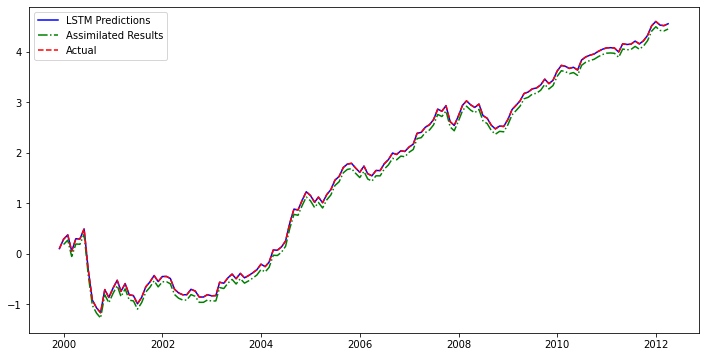

Mean Square Forecast Error: 2.3446000098423365e-14
Mean Square Forecast Error: 5.8852574691695245e-15
MAPE: 2063143.9627026238


In [226]:
# Monthly
plt.figure(figsize=(12,6))
plt.plot(np.cumsum(train_pred_df), label='LSTM Predictions', color = 'blue')
plt.plot(np.cumsum(Assimilated_results), label='Assimilated Results',  color = 'green', linestyle = '-.')
plt.plot(np.cumsum(train_obs_df), label='Actual',  color = 'red', linestyle = '--')
plt.legend()
plt.savefig('Train-Monthly-Returns-KF.png')
plt.show()

print(f'Mean Square Forecast Error: {mean_squared_error(train_obs_df, train_pred_df)}')
print(f'Mean Square Forecast Error: {mean_squared_error(train_obs_df[1:], Assimilated_results)}')
print(f'MAPE: {mean_absolute_percentage_error(train_obs_df[1:], Assimilated_results)}')

## Validation Dataset

In [ ]:


val_data_proportion = 1/5 
val_data = filtered_monthly_data[int(-2*val_data_proportion * len(filtered_monthly_data)):-int(val_data_proportion * len(filtered_monthly_data))]

print(f'Length of validation data: {len(val_data)}')

LSTM_val_assimilated_results = collections.deque()

val_pred_var = collections.deque()
val_obs_var = collections.deque()

for i in range(len(x_val_m_AAPL)-1):

    input = torch.unsqueeze(x_val_m_AAPL[i], 0)
    
    val_pred = AAPL_model_m(input)
    val_pred = val_pred.cpu().detach().numpy().item()
    val_pred_var.append(val_pred)

    observation = y_val_m_AAPL[i].cpu().detach().numpy().item()
    val_obs_var.append(observation)

    Kalman_gain = np.var(val_pred_var) * 1/(np.var(val_pred_var) + np.var(val_obs_var)) 
    
    analysis_obs = val_pred + Kalman_gain * (observation - val_pred) 

    LSTM_val_assimilated_results.append(np.array(analysis_obs))

print(len(LSTM_val_assimilated_results))
Assimilated_val_results = pd.DataFrame(LSTM_val_assimilated_results, index = val_data.index[:-2])
Assimilated_val_results.dropna(inplace=True)

val_pred_df = pd.DataFrame(np.array(val_pred_var), index = val_data.index[:-2])
val_obs_df = pd.DataFrame(np.array(val_obs_var), index = val_data.index[:-2])

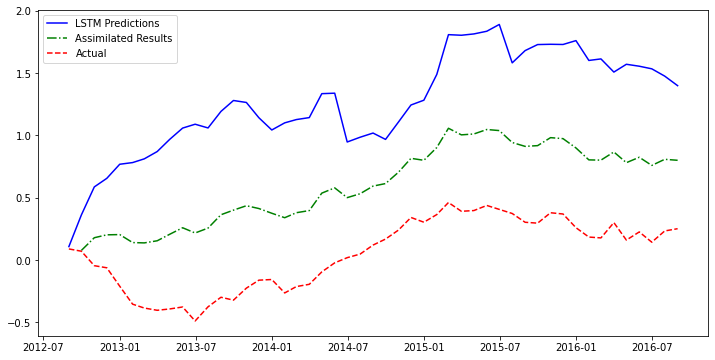

Mean Square Forecast Error: 0.021161035546232273
Mean Square Forecast Error: 0.003479270710248583
MAPE: 1.1003071358057517


In [228]:
# Monthly
plt.figure(figsize=(12,6))
plt.plot(np.cumsum(val_pred_df), label='LSTM Predictions', color = 'blue')
plt.plot(np.cumsum(Assimilated_val_results), label='Assimilated Results',  color = 'green', linestyle = '-.')
plt.plot(np.cumsum(val_obs_df), label='Actual',  color = 'red', linestyle = '--')
plt.legend()
plt.savefig('Val-Monthly-Returns-KF.png')
plt.show()

print(f'Mean Square Forecast Error: {mean_squared_error(val_obs_df, val_pred_df)}')
print(f'Mean Square Forecast Error: {mean_squared_error(val_obs_df[1:], Assimilated_val_results)}')
print(f'MAPE: {mean_absolute_percentage_error(val_obs_df[1:], Assimilated_val_results)}')

## Test Dataset

In [229]:

test_data_proportion = 1/5 
test_data = filtered_monthly_data[-int(1*val_data_proportion * len(filtered_monthly_data)):]

print(f'Length of test data: {len(test_data)}')

LSTM_test_assimilated_results = collections.deque()

test_pred_var = collections.deque()
test_obs_var = collections.deque()

for i in range(len(x_test_m_AAPL)-1):

    input = torch.unsqueeze(x_test_m_AAPL[i], 0)
    
    test_pred = AAPL_model_m(input)
    test_pred = test_pred.cpu().detach().numpy().item()
    test_pred_var.append(test_pred)

    observation = y_test_m_AAPL[i].cpu().detach().numpy().item()
    test_obs_var.append(observation)

    Kalman_gain = np.var(test_pred_var) * 1/(np.var(test_pred_var) + np.var(test_obs_var)) 
    
    test_analysis_obs = test_pred + Kalman_gain * (observation - test_pred) 

    LSTM_test_assimilated_results.append(np.array(test_analysis_obs))

print(len(LSTM_test_assimilated_results))
Assimilated_test_results = pd.DataFrame(LSTM_test_assimilated_results, index = test_data.index)
Assimilated_test_results.dropna(inplace=True)

test_pred_df = pd.DataFrame(np.array(test_pred_var), index = test_data.index)
test_obs_df = pd.DataFrame(np.array(test_obs_var), index = test_data.index)

Length of test data: 50
50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


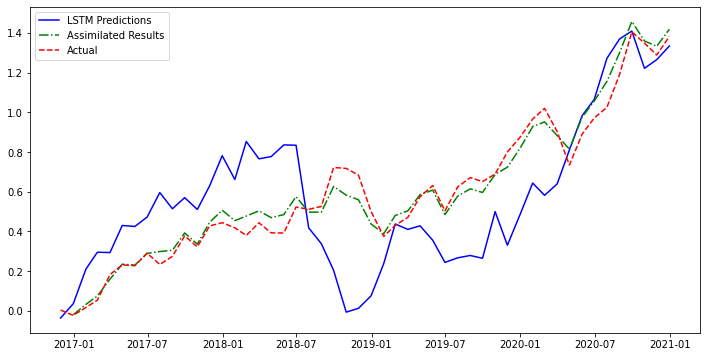

Mean Square Forecast Error: 0.022777612895874436
Mean Square Forecast Error: 0.0015179215553024089
MAPE: 1.1578177059557977


In [230]:
# Monthly
plt.figure(figsize=(12,6))
plt.plot(np.cumsum(test_pred_df), label='LSTM Predictions', color = 'blue')
plt.plot(np.cumsum(Assimilated_test_results), label='Assimilated Results',  color = 'green', linestyle = '-.')
plt.plot(np.cumsum(test_obs_df), label='Actual',  color = 'red', linestyle = '--')
plt.legend()
plt.savefig('Test-Monthly-Returns-KF.png')
plt.show()

print(f'Mean Square Forecast Error: {mean_squared_error(test_obs_df, test_pred_df)}')
print(f'Mean Square Forecast Error: {mean_squared_error(test_obs_df[1:], Assimilated_test_results)}')
print(f'MAPE: {mean_absolute_percentage_error(test_obs_df[1:], Assimilated_test_results)}')

# Data Driven Approach Assimilating a multi-step Data Driven Model (LSTM) with FBM Forecasts

In [231]:
FBM_monthly_returns

Dates
1999-04-30    0.989688
1999-05-31    0.875994
1999-06-30    1.155997
1999-07-31    1.015362
1999-08-31    0.809240
                ...   
2019-06-30    1.015572
2019-07-31    1.010211
2019-08-31    0.894043
2019-09-30    0.982597
2019-10-31    0.804447
Freq: M, Length: 247, dtype: float64

In [232]:
XOM_returns_m.iloc[5].values.item(0)

1.0356832721217963

In [233]:
AAPL_0_returns_monthly = AAPL_0_returns_monthly + 1
AAPL_0_returns_monthly

Dates
1999-11-30    1.222378
1999-12-31    1.050343
2000-01-31    0.973004
2000-02-29    1.104752
2000-03-31    1.185728
                ...   
2020-08-31    1.214380
2020-09-30    0.943555
2020-10-31    0.939988
2020-11-30    1.093606
2020-12-31    1.092749
Freq: M, Name: AAPL Daily Returns, Length: 254, dtype: float64

In [234]:
XOM_returns_m.head()

,Daily Returns
Dates,
1999-10-31,0.974508
1999-11-30,1.070886
1999-12-31,1.015760
2000-01-31,1.028703
2000-02-29,0.908749


In [235]:
#returns_XOM
XOM_data = pd.read_excel('/content/gdrive/MyDrive/MSc_Thesis/Exon_Mobil_Data/XOM_full_data.xlsx')

XOM_data.dropna(inplace=True)
XOM_data.set_index(XOM_data['Dates'], inplace=True)
XOM_data.drop(columns = ['Dates'], inplace=True)

XOM_data = XOM_data['1999-10-30':]
XOM_data.head()

,XOM Closing price,XOM Opening price,XOM Bid price,XOM Ask price,XOM High price,XOM Low price,XOM VOLATILITY_10D,XOM VOLATILITY_30D,XOM Price_earning ratio,XOM Price_book_ratio,XOM Current_ratio,XOM Price_sales_ratio,XOM Dividend_payout_ratio,XOM INTEREST_COVERAGE_RATIO,XOM Adjusted Beta,XOM Adjusted alpha
Dates,,,,,,,,,,,,,,,,
1999-11-01,37.3750,37.0313,37.125,37.3750,37.5000,36.7813,38.512,28.069,30.5102,4.1430,0.8364,1.2786,66.7739,20.0446,0.6610,0.0102
1999-11-02,37.0625,37.1875,36.875,37.1875,37.5938,36.9688,30.644,27.666,30.2551,4.1084,0.8364,1.2679,66.7739,20.0446,0.6613,0.0089
1999-11-03,36.5000,37.3125,35.875,37.0000,37.3125,36.2813,31.294,27.944,29.7959,4.0460,0.8364,1.2487,66.7739,20.0446,0.6606,0.0054
1999-11-04,36.5000,36.8438,36.375,36.6250,36.9688,36.2500,30.116,27.944,29.7959,4.0460,0.8364,1.2487,66.7739,20.0446,0.6604,0.0041
1999-11-05,35.3125,36.5000,35.250,35.7500,36.5000,35.0313,28.430,29.505,28.8265,3.9144,0.8364,1.2081,66.7739,20.0446,0.6591,-0.0003


In [236]:

XOM_monthly_data = XOM_data.groupby(pd.Grouper(freq='M')).mean()
XOM_monthly_data['Returns'] = XOM_returns_m
#XOM_monthly_data['Dates'] = XOM_monthly_data.index
XOM_monthly_data.head()

,XOM Closing price,XOM Opening price,XOM Bid price,XOM Ask price,XOM High price,XOM Low price,XOM VOLATILITY_10D,XOM VOLATILITY_30D,XOM Price_earning ratio,XOM Price_book_ratio,XOM Current_ratio,XOM Price_sales_ratio,XOM Dividend_payout_ratio,XOM INTEREST_COVERAGE_RATIO,XOM Adjusted Beta,XOM Adjusted alpha,Returns
Dates,,,,,,,,,,,,,,,,,
1999-11-30,38.556391,38.482968,38.223018,38.796882,38.906277,38.063945,29.370773,31.484545,31.474573,4.273986,0.836400,1.319050,66.773900,20.044600,0.656991,0.016691,1.070886
1999-12-31,41.275326,41.233713,41.048913,41.457883,41.789426,40.748652,29.511391,28.996609,33.472287,4.573130,0.834991,1.413548,66.898135,19.689596,0.649430,0.030300,1.015760
2000-01-31,41.523829,41.398824,41.351195,41.674110,42.159243,40.799129,37.466095,34.704667,28.637105,4.549790,0.804000,1.455462,69.631300,11.879500,0.637038,0.038948,1.028703
2000-02-29,38.626510,38.761919,38.546133,38.903276,39.375024,38.010438,40.494381,37.008286,26.638952,4.232324,0.804000,1.353895,69.631300,11.879500,0.645790,0.025476,0.908749
2000-03-31,38.667978,38.398109,38.429352,38.851909,39.332909,37.690239,49.340870,46.263174,26.486861,4.233809,0.806865,1.351326,68.803378,12.670848,0.637383,0.019687,1.035683


In [237]:
#scaler = StandardScaler()
#scaler.fit(XOM_monthly_data[:3 * len(XOM_monthly_data) // 5])
#scaled_dataset = scaler.transform(XOM_monthly_data)

#XOM_monthly_data = pd.DataFrame(data=scaled_dataset, index=XOM_monthly_data.index, columns=XOM_monthly_data.columns)

In [238]:
#XOM_monthly_data = helper_funcs.scale_dataset(XOM_monthly_data, min=False)
XOM_monthly_data.head()

,XOM Closing price,XOM Opening price,XOM Bid price,XOM Ask price,XOM High price,XOM Low price,XOM VOLATILITY_10D,XOM VOLATILITY_30D,XOM Price_earning ratio,XOM Price_book_ratio,XOM Current_ratio,XOM Price_sales_ratio,XOM Dividend_payout_ratio,XOM INTEREST_COVERAGE_RATIO,XOM Adjusted Beta,XOM Adjusted alpha,Returns
Dates,,,,,,,,,,,,,,,,,
1999-11-30,38.556391,38.482968,38.223018,38.796882,38.906277,38.063945,29.370773,31.484545,31.474573,4.273986,0.836400,1.319050,66.773900,20.044600,0.656991,0.016691,1.070886
1999-12-31,41.275326,41.233713,41.048913,41.457883,41.789426,40.748652,29.511391,28.996609,33.472287,4.573130,0.834991,1.413548,66.898135,19.689596,0.649430,0.030300,1.015760
2000-01-31,41.523829,41.398824,41.351195,41.674110,42.159243,40.799129,37.466095,34.704667,28.637105,4.549790,0.804000,1.455462,69.631300,11.879500,0.637038,0.038948,1.028703
2000-02-29,38.626510,38.761919,38.546133,38.903276,39.375024,38.010438,40.494381,37.008286,26.638952,4.232324,0.804000,1.353895,69.631300,11.879500,0.645790,0.025476,0.908749
2000-03-31,38.667978,38.398109,38.429352,38.851909,39.332909,37.690239,49.340870,46.263174,26.486861,4.233809,0.806865,1.351326,68.803378,12.670848,0.637383,0.019687,1.035683


In [239]:
print(len(XOM_returns_m))
print(len(XOM_monthly_data))

260
259


In [240]:
T_m = 6
Outputs = 12

X_M_XOM, Y_M_XOM = helper_funcs.create_datasets(T_m, Outputs,  XOM_monthly_data['Returns'], 'XOM', XOM_monthly_data, True)

x_train_m_XOM, y_train_m_XOM, x_val_m_XOM, y_val_m_XOM, x_test_m_XOM, y_test_m_XOM = helper_funcs.data_split(X_M_XOM, Y_M_XOM)
x_train_m_XOM, y_train_m_XOM, x_val_m_XOM, y_val_m_XOM, x_test_m_XOM, y_test_m_XOM = x_train_m_XOM.to(device), y_train_m_XOM.to(device), x_val_m_XOM.to(device), y_val_m_XOM.to(device), x_test_m_XOM.to(device), y_test_m_XOM.to(device)

X shape : (240, 6, 17)
Y shape : (240, 12)
Shape of X: (240, 6, 17) Shape of Y: (240, 12)


In [241]:
print(f'The lookback for monthly data is {T_m}')

The lookback for monthly data is 6


Epoch 25/500, Train Loss: 0.0096, Validation Loss: 0.0112
Epoch 50/500, Train Loss: 0.0030, Validation Loss: 0.0029
Epoch 75/500, Train Loss: 0.0027, Validation Loss: 0.0025
Epoch 100/500, Train Loss: 0.0026, Validation Loss: 0.0024
Epoch 125/500, Train Loss: 0.0024, Validation Loss: 0.0024
Epoch 150/500, Train Loss: 0.0023, Validation Loss: 0.0025
Epoch 175/500, Train Loss: 0.0022, Validation Loss: 0.0026
Epoch 200/500, Train Loss: 0.0021, Validation Loss: 0.0026
Epoch 225/500, Train Loss: 0.0021, Validation Loss: 0.0026
Epoch 250/500, Train Loss: 0.0020, Validation Loss: 0.0026
Epoch 275/500, Train Loss: 0.0019, Validation Loss: 0.0027
Epoch 300/500, Train Loss: 0.0018, Validation Loss: 0.0028
Epoch 325/500, Train Loss: 0.0018, Validation Loss: 0.0029
Epoch 350/500, Train Loss: 0.0017, Validation Loss: 0.0031
Epoch 375/500, Train Loss: 0.0016, Validation Loss: 0.0033
Epoch 400/500, Train Loss: 0.0016, Validation Loss: 0.0034
Epoch 425/500, Train Loss: 0.0015, Validation Loss: 0.0036


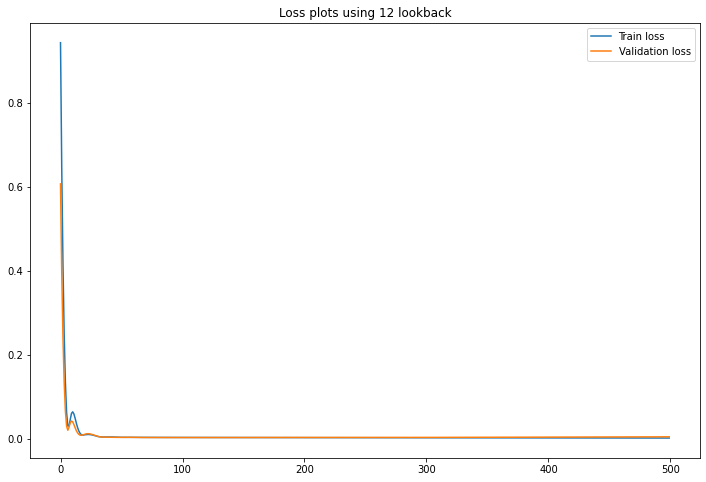

In [242]:
Hidden = 512 #512

XOM_model_multi = LSTM(len(X_M_XOM.T), Hidden, 1, Outputs)
XOM_model_multi.to(device)

loss_function = nn.MSELoss()
learning_rate = 5e-4
epochs = 500
XOM_model_multi_optimizer = torch.optim.Adam(XOM_model_multi.parameters(), lr = learning_rate)


train_loss_multi, validation_loss_multi = full_gd(XOM_model_multi,
                                      loss_function,
                                      XOM_model_multi_optimizer,
                                      x_train_m_XOM, 
                                      y_train_m_XOM, 
                                      x_val_m_XOM,
                                      y_val_m_XOM, 
                                      epochs)


plot_loss_funcs(train_loss_multi, validation_loss_multi, 12)


In [ ]:
x_t_1 = torch.from_numpy(XOM_monthly_data['4-1-2018':'9-2018'].values).to(device)
print(x_t_1.shape)
x_t_1 = x_t_1.unsqueeze(0).float()
print(x_t_1.shape)

In [244]:
test = XOM_model_multi(x_t_1)
test = test.squeeze()
test = test.cpu().detach().numpy()
print(test.shape)
#test = scaler.inverse_transform(test)
print(test)

(12,)
[0.95218706 1.0321765  0.80010897 0.8624177  0.9464525  0.88941693
 1.0394591  1.022623   0.8853109  0.9838863  0.98406184 0.9796097 ]


In [245]:
import datetime 
from dateutil.relativedelta import relativedelta

In [246]:
XOM_returns_m.loc[XOM_returns_m['2018-09'].index.date[0] : XOM_returns_m['2018-09'].index.date[0]+ relativedelta(months =+ Outputs)]

,Daily Returns
Dates,
2018-09-30,1.060496
2018-10-31,0.937191
2018-11-30,0.997741
2018-12-31,0.857736
2019-01-31,1.074644
2019-02-28,1.078466
2019-03-31,1.022397
2019-04-30,0.993564
2019-05-31,0.881540


# Using the Modified KF algorithm to make predictions across the entire test set and assimilating them with the apropriately indexed FBM simulations. 

In [247]:
test_set_predictions = XOM_model_multi(x_test_m_XOM)

test_set_predictions = test_set_predictions.detach().cpu().numpy()
test_set_predictions[2]

array([0.8563927 , 0.87955815, 0.67831755, 1.021672  , 0.6953998 ,
       0.7580945 , 1.0624042 , 1.0533422 , 0.9114136 , 0.94490075,
       0.85586095, 0.65500665], dtype=float32)

In [248]:
print(len(test_set_predictions))


48


In [249]:
print(FBM_monthly_returns.loc['2012-10-31':])

Dates
2012-10-31    0.801722
2012-11-30    0.681922
2012-12-31    0.917910
2013-01-31    0.921270
2013-02-28    0.979719
                ...   
2019-06-30    1.015572
2019-07-31    1.010211
2019-08-31    0.894043
2019-09-30    0.982597
2019-10-31    0.804447
Freq: M, Length: 85, dtype: float64


In [250]:

c = FBM_monthly_returns.loc[FBM_monthly_returns['2012-10-31':].index.date[1] : FBM_monthly_returns['2012-10-31':].index.date[Outputs]] 

print(len(c))
print(c)

12
Dates
2012-11-30    0.681922
2012-12-31    0.917910
2013-01-31    0.921270
2013-02-28    0.979719
2013-03-31    1.138087
2013-04-30    0.866879
2013-05-31    1.120744
2013-06-30    1.152151
2013-07-31    0.952119
2013-08-31    0.815542
2013-09-30    0.938186
2013-10-31    1.165950
Freq: M, dtype: float64


In [251]:
u = FBM_monthly_returns.loc[FBM_monthly_returns['2012-10-31':].index.date[1] : FBM_monthly_returns['2012-10-31':].index.date[Outputs]] # + relativedelta(months =+ Outputs)]
print(len(u))

u

12


Dates
2012-11-30    0.681922
2012-12-31    0.917910
2013-01-31    0.921270
2013-02-28    0.979719
2013-03-31    1.138087
2013-04-30    0.866879
2013-05-31    1.120744
2013-06-30    1.152151
2013-07-31    0.952119
2013-08-31    0.815542
2013-09-30    0.938186
2013-10-31    1.165950
Freq: M, dtype: float64

In [252]:
FBM_monthly_returns.loc[FBM_monthly_returns['2012-10-31':].index.date[4] : FBM_monthly_returns['2012-10-31':].index.date[4] + relativedelta(months =+ Outputs-1)].index.date

array([datetime.date(2013, 2, 28), datetime.date(2013, 3, 31),
       datetime.date(2013, 4, 30), datetime.date(2013, 5, 31),
       datetime.date(2013, 6, 30), datetime.date(2013, 7, 31),
       datetime.date(2013, 8, 31), datetime.date(2013, 9, 30),
       datetime.date(2013, 10, 31), datetime.date(2013, 11, 30),
       datetime.date(2013, 12, 31)], dtype=object)

In [253]:
FBM_monthly_returns['2012-10-31':'2012-12-31'].index.date[1]

datetime.date(2012, 11, 30)

In [254]:
[y for x in range(3) for y in [x, x]]

[0, 0, 1, 1, 2, 2]

In [255]:
#[index_arrays, date_arrays]
#xc = list(zip(*[index_arrays, date_arrays]))

In [256]:
f = FBM_monthly_returns.loc[FBM_monthly_returns['2012-10-31':].index[0] : FBM_monthly_returns['2012-10-31':].index.date[+Outputs]].index.date.tolist()
print(f)
print('\n')
tr = [[0,0,0,0,0,0,0,0,0,0,0,0], f]

f1 = list(zip(*tr))
f1

[datetime.date(2012, 10, 31), datetime.date(2012, 11, 30), datetime.date(2012, 12, 31), datetime.date(2013, 1, 31), datetime.date(2013, 2, 28), datetime.date(2013, 3, 31), datetime.date(2013, 4, 30), datetime.date(2013, 5, 31), datetime.date(2013, 6, 30), datetime.date(2013, 7, 31), datetime.date(2013, 8, 31), datetime.date(2013, 9, 30), datetime.date(2013, 10, 31)]




[(0, datetime.date(2012, 10, 31)),
 (0, datetime.date(2012, 11, 30)),
 (0, datetime.date(2012, 12, 31)),
 (0, datetime.date(2013, 1, 31)),
 (0, datetime.date(2013, 2, 28)),
 (0, datetime.date(2013, 3, 31)),
 (0, datetime.date(2013, 4, 30)),
 (0, datetime.date(2013, 5, 31)),
 (0, datetime.date(2013, 6, 30)),
 (0, datetime.date(2013, 7, 31)),
 (0, datetime.date(2013, 8, 31)),
 (0, datetime.date(2013, 9, 30))]

In [257]:
de = pd.MultiIndex.from_tuples(f1, names = ['Batch', 'Dates'] )
df = pd.DataFrame(index = de)
df

Empty DataFrame
Columns: []
Index: [(0, 2012-10-31 00:00:00), (0, 2012-11-30 00:00:00), (0, 2012-12-31 00:00:00), (0, 2013-01-31 00:00:00), (0, 2013-02-28 00:00:00), (0, 2013-03-31 00:00:00), (0, 2013-04-30 00:00:00), (0, 2013-05-31 00:00:00), (0, 2013-06-30 00:00:00), (0, 2013-07-31 00:00:00), (0, 2013-08-31 00:00:00), (0, 2013-09-30 00:00:00)]

In [258]:
index_arrays = [y for x in range(len(x_test_m_XOM)) for y in [x, x, x, x, x, x, x, x, x, x, x, x]]
date_arrays = [FBM_monthly_returns.loc[FBM_monthly_returns['2012-10-31':].index.date[i] : FBM_monthly_returns['2012-10-31':].index.date[i+Outputs-1]].index.date.tolist() for i in range(len(x_test_m_XOM))]
date_arrays[0]

[datetime.date(2012, 10, 31),
 datetime.date(2012, 11, 30),
 datetime.date(2012, 12, 31),
 datetime.date(2013, 1, 31),
 datetime.date(2013, 2, 28),
 datetime.date(2013, 3, 31),
 datetime.date(2013, 4, 30),
 datetime.date(2013, 5, 31),
 datetime.date(2013, 6, 30),
 datetime.date(2013, 7, 31),
 datetime.date(2013, 8, 31),
 datetime.date(2013, 9, 30)]

In [259]:
u = []

print(len(date_arrays))
print(len(date_arrays)*Outputs)

for i in range(len(date_arrays)):

    u.append(list(zip(*[[i,i,i,i,i,i,i,i,i,i,i,i], date_arrays[i]])))

48
576


In [260]:
flatList = [item for elem in u for item in elem]
print(len(flatList))


576


In [261]:
flatList[:5]

[(0, datetime.date(2012, 10, 31)),
 (0, datetime.date(2012, 11, 30)),
 (0, datetime.date(2012, 12, 31)),
 (0, datetime.date(2013, 1, 31)),
 (0, datetime.date(2013, 2, 28))]

In [262]:
indexer = pd.MultiIndex.from_tuples(flatList, names = ['Batches', 'Dates'])
indexer

MultiIndex([( 0, '2012-10-31'),
            ( 0, '2012-11-30'),
            ( 0, '2012-12-31'),
            ( 0, '2013-01-31'),
            ( 0, '2013-02-28'),
            ( 0, '2013-03-31'),
            ( 0, '2013-04-30'),
            ( 0, '2013-05-31'),
            ( 0, '2013-06-30'),
            ( 0, '2013-07-31'),
            ...
            (47, '2016-11-30'),
            (47, '2016-12-31'),
            (47, '2017-01-31'),
            (47, '2017-02-28'),
            (47, '2017-03-31'),
            (47, '2017-04-30'),
            (47, '2017-05-31'),
            (47, '2017-06-30'),
            (47, '2017-07-31'),
            (47, '2017-08-31')],
           names=['Batches', 'Dates'], length=576)

In [263]:
test_preds = test_set_predictions.flatten()

In [264]:
test_prediction_df = pd.DataFrame(test_preds, index = indexer, columns = ['Predictions'])
Assimilated_test_predictions = pd.DataFrame(index = indexer, columns = ['Assimilated'])

In [265]:
test_prediction_df

Predictions
Batches Dates                  
0       2012-10-31     0.875631
        2012-11-30     0.941822
        2012-12-31     0.684594
        2013-01-31     0.949065
        2013-02-28     0.828062
...                         ...
47      2017-04-30     0.863979
        2017-05-31     0.907869
        2017-06-30     0.972983
        2017-07-31     0.881555
        2017-08-31     1.039806

[576 rows x 1 columns]

In [266]:
test_prediction_df['FBM'] = np.nan
test_prediction_df['Assimilated'] = np.nan
test_prediction_df

Predictions  FBM  Assimilated
Batches Dates                                    
0       2012-10-31     0.875631  NaN          NaN
        2012-11-30     0.941822  NaN          NaN
        2012-12-31     0.684594  NaN          NaN
        2013-01-31     0.949065  NaN          NaN
        2013-02-28     0.828062  NaN          NaN
...                         ...  ...          ...
47      2017-04-30     0.863979  NaN          NaN
        2017-05-31     0.907869  NaN          NaN
        2017-06-30     0.972983  NaN          NaN
        2017-07-31     0.881555  NaN          NaN
        2017-08-31     1.039806  NaN          NaN

[576 rows x 3 columns]

In [267]:
for t in test_prediction_df.loc[0]['Predictions']:
    print(t*2)

1.7512611150741577
1.883643627166748
1.369187593460083
1.8981300592422485
1.6561247110366821
1.5553265810012817
2.1733005046844482
1.935166835784912
1.9800606966018677
2.0159528255462646
1.9422427415847778
1.398836374282837


In [268]:
#Assimilated_test_predictions.loc[0]['2012-10'] = 4
#Assimilated_test_predictions

In [269]:
test_set_predictions[3]

array([0.8943941 , 0.8838075 , 0.66449815, 1.0293281 , 0.68258834,
       0.747311  , 1.016128  , 1.0913798 , 0.924484  , 0.932312  ,
       0.8435596 , 0.61309475], dtype=float32)

In [270]:
test_prediction_df.index.get_level_values(1)[0:5].date[0]

datetime.date(2012, 10, 31)

In [271]:
test_prediction_df.loc[0]['2012-10-31':]

,Predictions,FBM,Assimilated
Dates,,,
2012-10-31,0.875631,NaN,NaN
2012-11-30,0.941822,NaN,NaN
2012-12-31,0.684594,NaN,NaN
2013-01-31,0.949065,NaN,NaN
2013-02-28,0.828062,NaN,NaN
2013-03-31,0.777663,NaN,NaN
2013-04-30,1.086650,NaN,NaN
2013-05-31,0.967583,NaN,NaN
2013-06-30,0.990030,NaN,NaN


In [272]:
for j in test_prediction_df.loc[1]['Predictions']:
    print(j)

0.8497626781463623
0.9205982685089111
0.7015351057052612
0.9569105505943298
0.8008953332901001
0.7590816020965576
1.072279930114746
0.9836219549179077
0.9797061085700989
0.998359203338623
0.9435331225395203
0.7013581395149231


In [273]:
test_prediction_df.loc[0]['2012-10':].index.date[0]

datetime.date(2012, 10, 31)

In [274]:
FBM_monthly_returns.loc[FBM_monthly_returns['2012-10-31':].index.date[i] : FBM_monthly_returns['2012-10-31':].index.date[i]+ relativedelta(months =+ Outputs-1)].index

DatetimeIndex(['2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31',
               '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31'],
              dtype='datetime64[ns]', name='Dates', freq='M')

In [275]:
test_prediction_df.loc[0].index.date[0] : test_prediction_df.loc[0].index.date[0] + relativedelta(months =+ Outputs-1)

In [276]:
test_prediction_df.loc[0].index.date[0] #: 
 #test_prediction_df.loc[0].index.date[0] + relativedelta(months =+ Outputs-1)].index

#test_prediction_df.loc[
#+ relativedelta(months =+ Outputs-1)].index

datetime.date(2012, 10, 31)

In [277]:
test_prediction_df.loc[2].iloc[0:].index.date[0]

datetime.date(2012, 12, 31)

In [278]:
test_prediction_df.loc[0][test_prediction_df.loc[0]['2012-10-31':].index.date[0] : test_prediction_df.loc[0]['2012-10-31':].index.date[0]+ relativedelta(months =+ Outputs-1)].index.date[:]

array([datetime.date(2012, 10, 31), datetime.date(2012, 11, 30),
       datetime.date(2012, 12, 31), datetime.date(2013, 1, 31),
       datetime.date(2013, 2, 28), datetime.date(2013, 3, 31),
       datetime.date(2013, 4, 30), datetime.date(2013, 5, 31),
       datetime.date(2013, 6, 30), datetime.date(2013, 7, 31),
       datetime.date(2013, 8, 31), datetime.date(2013, 9, 30)],
      dtype=object)

In [279]:
FBM_monthly_returns['2012-10-31':].index.date[0]

datetime.date(2012, 10, 31)

In [280]:
FBM_monthly_returns.loc[FBM_monthly_returns['2012-10-31':].index.date[0] : FBM_monthly_returns['2012-10-31':].index.date[0] + relativedelta(months =+ Outputs-1)].index.date[0]

datetime.date(2012, 10, 31)

In [281]:
[FBM_monthly_returns.loc[test_prediction_df.loc[i].iloc[0:].index.date[0] : 
                         test_prediction_df.loc[i].iloc[0:].index.date[0] 
                         + relativedelta(months =+ 11-1)].index.date[0]]

[datetime.date(2016, 9, 30)]

In [282]:
FBM_tensor = np.zeros(test_set_predictions.shape)
print(FBM_tensor.shape)

(48, 12)


In [283]:
np.arange(0, len(x_test_m_XOM))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])

In [284]:


for p in range(len(x_test_m_XOM)):
    for j in range(12):
        date = FBM_monthly_returns.loc[test_prediction_df.loc[p].iloc[0:].index.date[j] : test_prediction_df.loc[p].iloc[0:].index.date[j] + relativedelta(months =+ Outputs-1)].index[0]
        value = FBM_monthly_returns.loc[date].item()
        FBM_tensor[p][j] = value 
        



In [ ]:
FBM_tensor[:3]

In [286]:
test_prediction_df['FBM'] = FBM_tensor.flatten()

In [287]:
test_prediction_df

Predictions       FBM  Assimilated
Batches Dates                                         
0       2012-10-31     0.875631  0.801722          NaN
        2012-11-30     0.941822  0.681922          NaN
        2012-12-31     0.684594  0.917910          NaN
        2013-01-31     0.949065  0.921270          NaN
        2013-02-28     0.828062  0.979719          NaN
...                         ...       ...          ...
47      2017-04-30     0.863979  0.820460          NaN
        2017-05-31     0.907869  1.042265          NaN
        2017-06-30     0.972983  1.085082          NaN
        2017-07-31     0.881555  0.912975          NaN
        2017-08-31     1.039806  1.021943          NaN

[576 rows x 3 columns]

In [288]:
test_prediction_df.loc[0].iloc[0]['Predictions']

0.8756305575370789

In [289]:
Assimilated_tensor = np.zeros(test_set_predictions.shape)

for p in range(len(x_test_m_XOM)):
    FBM_var = []
    Data_driven_var = []

    for j in range(12):
        date = test_prediction_df.loc[p][test_prediction_df.loc[p].iloc[0:].index.date[j] : test_prediction_df.loc[p].iloc[0:].index.date[j] + relativedelta(months =+ Outputs-1)].index[0]
        FBM_value = FBM_monthly_returns.loc[date].item()
        Data_driven_value = test_prediction_df.loc[p].iloc[j]['Predictions']

        FBM_var.append(FBM_value)
        Data_driven_var.append(Data_driven_value)

        if np.var(Data_driven_var) == 0:
            analysis = Data_driven_value

        else:

            Kalman_gain = np.var(Data_driven_var)* 1/ (np.var(Data_driven_var) + np.var(FBM_var))

            analysis = Data_driven_value + Kalman_gain * (FBM_value - Data_driven_value)

        Assimilated_tensor[p][j] = analysis
        

In [290]:
Assimilated_tensor[:3]

array([[0.87563056, 0.88103751, 0.81563667, 0.93404364, 0.8965558 ,
        0.88566219, 0.98629316, 1.02889681, 1.04882351, 0.98661743,
        0.91360667, 0.80384912],
       [0.84976268, 0.92037607, 0.78918475, 0.96655279, 0.89362971,
        0.79126295, 1.0916019 , 1.04651782, 0.96892124, 0.92807253,
        0.94146377, 0.88954322],
       [0.85639268, 0.92041057, 0.95240994, 1.09742837, 0.80655169,
        0.96450051, 1.11745964, 0.98666924, 0.8550106 , 0.94094121,
        1.02191357, 0.85499459]])

In [291]:
test_prediction_df['Assimilated'] = Assimilated_tensor.flatten()

In [292]:
test_prediction_df['Actual'] = y_test_m_XOM.detach().cpu().flatten()

In [293]:
test_prediction_df

Predictions       FBM  Assimilated    Actual
Batches Dates                                                   
0       2012-10-31     0.875631  0.801722     0.875631  1.007014
        2012-11-30     0.941822  0.681922     0.881038  1.053022
        2012-12-31     0.684594  0.917910     0.815637  0.948901
        2013-01-31     0.949065  0.921270     0.934044  0.979652
        2013-02-28     0.828062  0.979719     0.896556  1.001607
...                         ...       ...          ...       ...
47      2017-04-30     0.863979  0.820460     0.852763  1.168915
        2017-05-31     0.907869  1.042265     0.941321  1.081039
        2017-06-30     0.972983  1.085082     1.000024  1.087821
        2017-07-31     0.881555  0.912975     0.889217  1.212533
        2017-08-31     1.039806  1.021943     1.034635  1.026853

[576 rows x 4 columns]

In [294]:
print(mean_squared_error(test_prediction_df["Predictions"], test_prediction_df["Actual"]))
print(mean_squared_error(test_prediction_df["FBM"], test_prediction_df["Actual"]))
print(mean_squared_error(test_prediction_df["Assimilated"], test_prediction_df['Actual']))

0.021725256
0.02274023036767849
0.013210248672346436


In [295]:
# Above we can see that overall we have a lower MSE for the assimilated results
# What I want to do next is to compute the MSE across batches and compare how many batches it has lower MSE
# Finally I will investigate if using the assimilated series as input improves the LSTM's forecasting capabilities

In [296]:
mean_squared_error(test_prediction_df.loc[0]["Predictions"], test_prediction_df.loc[0]["Actual"])

0.02183795

In [297]:
test_prediction_df['MSE Pred-A'] = np.nan
test_prediction_df['MSE FBM-A'] = np.nan
test_prediction_df['MSE Assim-A'] = np.nan

In [298]:
for j in range(len(x_test_m_XOM)):

    test_prediction_df.loc[j, 'MSE Pred-A'] = mean_squared_error(test_prediction_df.loc[j, "Predictions"], test_prediction_df.loc[j, "Actual"])
    test_prediction_df.loc[j, 'MSE FBM-A'] = mean_squared_error(test_prediction_df.loc[j, "FBM"], test_prediction_df.loc[j, "Actual"])
    test_prediction_df.loc[j, 'MSE Assim-A'] = mean_squared_error(test_prediction_df.loc[j, "Assimilated"], test_prediction_df.loc[j, "Actual"])

In [299]:
test_prediction_df


Predictions       FBM  ...  MSE FBM-A  MSE Assim-A
Batches Dates                              ...                        
0       2012-10-31     0.875631  0.801722  ...   0.029088     0.012217
        2012-11-30     0.941822  0.681922  ...   0.029088     0.012217
        2012-12-31     0.684594  0.917910  ...   0.029088     0.012217
        2013-01-31     0.949065  0.921270  ...   0.029088     0.012217
        2013-02-28     0.828062  0.979719  ...   0.029088     0.012217
...                         ...       ...  ...        ...          ...
47      2017-04-30     0.863979  0.820460  ...   0.029778     0.027807
        2017-05-31     0.907869  1.042265  ...   0.029778     0.027807
        2017-06-30     0.972983  1.085082  ...   0.029778     0.027807
        2017-07-31     0.881555  0.912975  ...   0.029778     0.027807
        2017-08-31     1.039806  1.021943  ...   0.029778     0.027807

[576 rows x 7 columns]

In [300]:
Pred_Actual_MSE = [test_prediction_df.loc[j, 'MSE Pred-A'].iloc[0] for j in range(len(x_test_m_XOM))]
FBM_Actual_MSE = [test_prediction_df.loc[j, 'MSE FBM-A'].iloc[0] for j in range(len(x_test_m_XOM))]
Assim_Actual_MSE = [test_prediction_df.loc[j, 'MSE Assim-A'].iloc[0] for j in range(len(x_test_m_XOM))]

In [301]:
Percentage_diff_Assim_Pred = [Pred_Actual_MSE[i]/Assim_Actual_MSE[i] - 1 for i in range(len(Pred_Actual_MSE))]
Percentage_diff_Assim_FBM = [FBM_Actual_MSE[i]/Pred_Actual_MSE[i] - 1 for i in range(len(FBM_Actual_MSE))]

print(f'The average percentage difference between the assimilated series and the LSTM predictions is :{np.average(Percentage_diff_Assim_Pred)}')
print(f'The average percentage difference between the assimilated series and the FBM is :{np.average(Percentage_diff_Assim_FBM)}')

The average percentage difference between the assimilated series and the LSTM predictions is :0.6279036092527449
The average percentage difference between the assimilated series and the FBM is :0.686782078553736


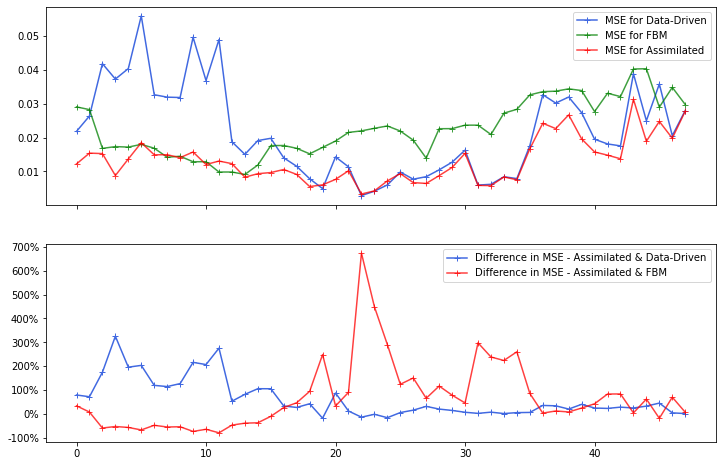

In [302]:
fig, ax = plt.subplots(2, 1, sharex = True, sharey = False, figsize=(12,8))

ax[0].plot(Pred_Actual_MSE, label = 'MSE for Data-Driven', color = 'royalblue', marker="+")
ax[0].plot(FBM_Actual_MSE, label = 'MSE for FBM', color = 'green', alpha = .75, marker="+")
ax[0].plot(Assim_Actual_MSE, label = 'MSE for Assimilated', color = 'red', alpha = .75, marker="+")
ax[0].legend()

ax[1].plot(Percentage_diff_Assim_Pred, label = 'Difference in MSE - Assimilated & Data-Driven', color = 'royalblue', marker="+")
ax[1].plot(Percentage_diff_Assim_FBM, label = 'Difference in MSE - Assimilated & FBM', color = 'red', alpha = 0.75, marker="+")
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax[1].legend()

fig.savefig('X.png')
fig.show()

## Now I want to do what Rossella suggested to investigate if using the assimilated series as input has better performance than the FBM or LSTM predictions

In [ ]:
Assimilated_LSTM_inputs = np.array([test_prediction_df.loc[j, 'Assimilated'].iloc[0] for j in range(len(x_test_m_XOM))])

Assimilated_LSTM_inputs = torch.from_numpy(Assimilated_LSTM_inputs)

print(Assimilated_LSTM_inputs.shape)
print(x_test_m_XOM.shape)

#Assimilated_LSTM_outputs = XOM_model_multi(Assimilated_LSTM_inputs)


In [304]:
T_m = 6
Outputs = 12

Assim_X_M_XOM, Assim_Y_M_XOM = helper_funcs.create_datasets(T_m, Outputs,  XOM_monthly_data['Returns'], 'XOM', XOM_monthly_data, True)

x_train_m_XOM, y_train_m_XOM, x_val_m_XOM, y_val_m_XOM, x_test_m_XOM, y_test_m_XOM = helper_funcs.data_split(X_M_XOM, Y_M_XOM)
x_train_m_XOM, y_train_m_XOM, x_val_m_XOM, y_val_m_XOM, x_test_m_XOM, y_test_m_XOM = x_train_m_XOM.to(device), y_train_m_XOM.to(device), x_val_m_XOM.to(device), y_val_m_XOM.to(device), x_test_m_XOM.to(device), y_test_m_XOM.to(device)

X shape : (240, 6, 17)
Y shape : (240, 12)
Shape of X: (240, 6, 17) Shape of Y: (240, 12)


Epoch 25/500, Train Loss: 0.0098, Validation Loss: 0.0142
Epoch 50/500, Train Loss: 0.0032, Validation Loss: 0.0035
Epoch 75/500, Train Loss: 0.0028, Validation Loss: 0.0030
Epoch 100/500, Train Loss: 0.0026, Validation Loss: 0.0029
Epoch 125/500, Train Loss: 0.0025, Validation Loss: 0.0027
Epoch 150/500, Train Loss: 0.0024, Validation Loss: 0.0027
Epoch 175/500, Train Loss: 0.0022, Validation Loss: 0.0027
Epoch 200/500, Train Loss: 0.0021, Validation Loss: 0.0027
Epoch 225/500, Train Loss: 0.0021, Validation Loss: 0.0028
Epoch 250/500, Train Loss: 0.0020, Validation Loss: 0.0030
Epoch 275/500, Train Loss: 0.0019, Validation Loss: 0.0032
Epoch 300/500, Train Loss: 0.0018, Validation Loss: 0.0034
Epoch 325/500, Train Loss: 0.0017, Validation Loss: 0.0035
Epoch 350/500, Train Loss: 0.0017, Validation Loss: 0.0037
Epoch 375/500, Train Loss: 0.0016, Validation Loss: 0.0037
Epoch 400/500, Train Loss: 0.0015, Validation Loss: 0.0039
Epoch 425/500, Train Loss: 0.0014, Validation Loss: 0.0040


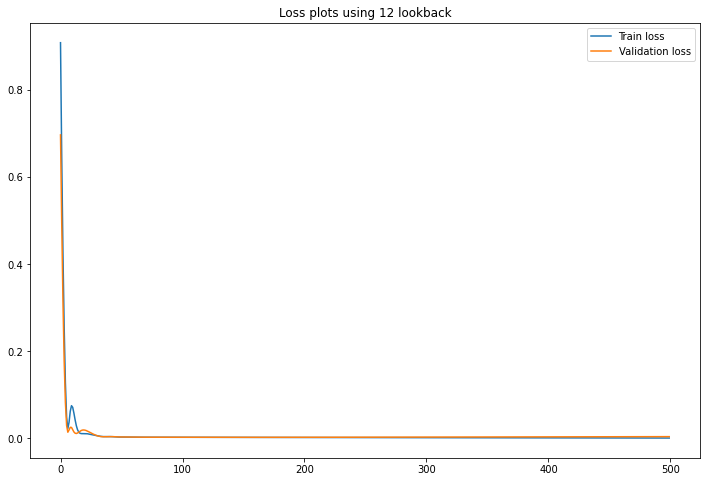

In [305]:
Hidden = 512 #512

XOM_model_multi = LSTM(len(X_M_XOM.T), Hidden, 1, Outputs)
XOM_model_multi.to(device)

loss_function = nn.MSELoss()
learning_rate = 5e-4
epochs = 500
XOM_model_multi_optimizer = torch.optim.Adam(XOM_model_multi.parameters(), lr = learning_rate)


train_loss_multi, validation_loss_multi = full_gd(XOM_model_multi,
                                      loss_function,
                                      XOM_model_multi_optimizer,
                                      x_train_m_XOM, 
                                      y_train_m_XOM, 
                                      x_val_m_XOM,
                                      y_val_m_XOM, 
                                      epochs)


plot_loss_funcs(train_loss_multi, validation_loss_multi, 12)


# Modified KF Algoirthm used and results plotted over a 12 month period beginning 10-2018 

In [ ]:
test = pd.DataFrame(test, index = XOM_returns_m.loc[XOM_returns_m['10-2018'].index.date[0] : XOM_returns_m['10-2018'].index.date[0]+ relativedelta(months =+ Outputs-1)].index)
test

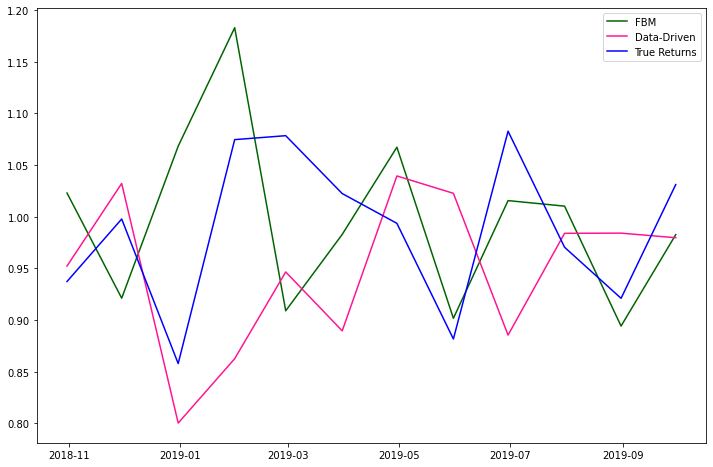

In [307]:
plt.figure(figsize =(12,8))
plt.plot(FBM_monthly_returns.loc['10-2018':'9-2019'], label = 'FBM', color = 'darkgreen')
plt.plot(test, label ='Data-Driven', color = 'deeppink')
plt.plot(XOM_returns_m.loc['10-2018':'9-2019'], label = 'True Returns', color = 'blue')
plt.legend()
plt.show()

# KF on the Data-Driven Method and FBM Simulations

In [308]:
FBM_monthly_returns = FBM_monthly_returns.to_frame()

In [309]:
Data_Driven_assimilated_results = collections.deque()

FBM_variance_deque = collections.deque()
data_driven_variance_deque = collections.deque()

for i in range(Outputs):

    input = x_t_1

    data_driven_pred = XOM_model_multi(input)
    data_driven_pred = data_driven_pred.squeeze().cpu().detach().numpy()[i]
    data_driven_variance_deque.append(data_driven_pred)

    observation = FBM_monthly_returns.loc['10-2018':].iloc[i].values.item(0)
    FBM_variance_deque.append(observation)

    Kalman_gain = np.var(data_driven_variance_deque) * 1/(np.var(data_driven_variance_deque) + np.var(FBM_variance_deque)) 

    analysis_obs = data_driven_pred + Kalman_gain * (observation - data_driven_pred) 

    Data_Driven_assimilated_results.append(np.array(analysis_obs))

Data_Driven_assimilated_results = pd.DataFrame(Data_Driven_assimilated_results, 
                                               index = XOM_returns_m.loc[XOM_returns_m['10-2018'].index.date[0] : XOM_returns_m['10-2018'].index.date[0]+ relativedelta(months =+ Outputs-1)].index)
Data_Driven_assimilated_results.dropna(inplace=True)

data_driven_variance_deque = pd.DataFrame(np.array(data_driven_variance_deque), 
                                          index = XOM_returns_m.loc[XOM_returns_m['10-2018'].index.date[0] : XOM_returns_m['10-2018'].index.date[0]+ relativedelta(months =+ Outputs-1)].index)

FBM_variance_deque = pd.DataFrame(np.array(FBM_variance_deque), 
                                  index = XOM_returns_m.loc[XOM_returns_m['10-2018'].index.date[0] : XOM_returns_m['10-2018'].index.date[0]+ relativedelta(months =+ Outputs-1)].index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


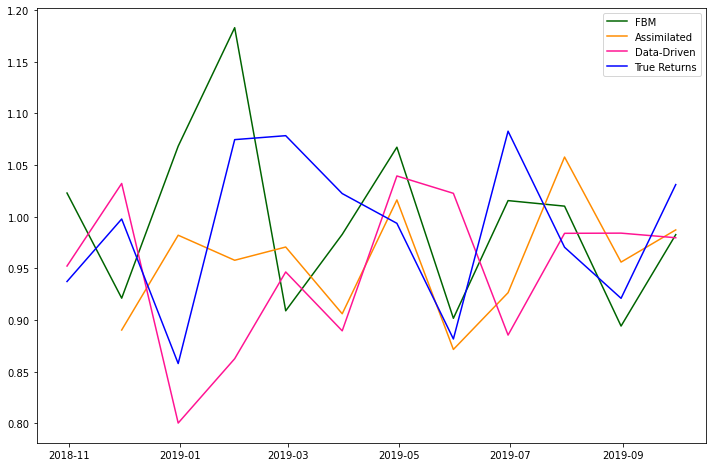

In [310]:
plt.figure(figsize =(12,8))
plt.plot(FBM_monthly_returns.loc['10-2018':'9-2019'], label = 'FBM', color = 'darkgreen')
plt.plot(Data_Driven_assimilated_results, label = 'Assimilated', color = 'darkorange')
plt.plot(test, label ='Data-Driven', color = 'deeppink')
plt.plot(XOM_returns_m.loc['10-2018':'9-2019'], label = 'True Returns', color = 'blue')
plt.legend()
plt.savefig('Multi-Step-Forecast-XOM.png')
plt.show()

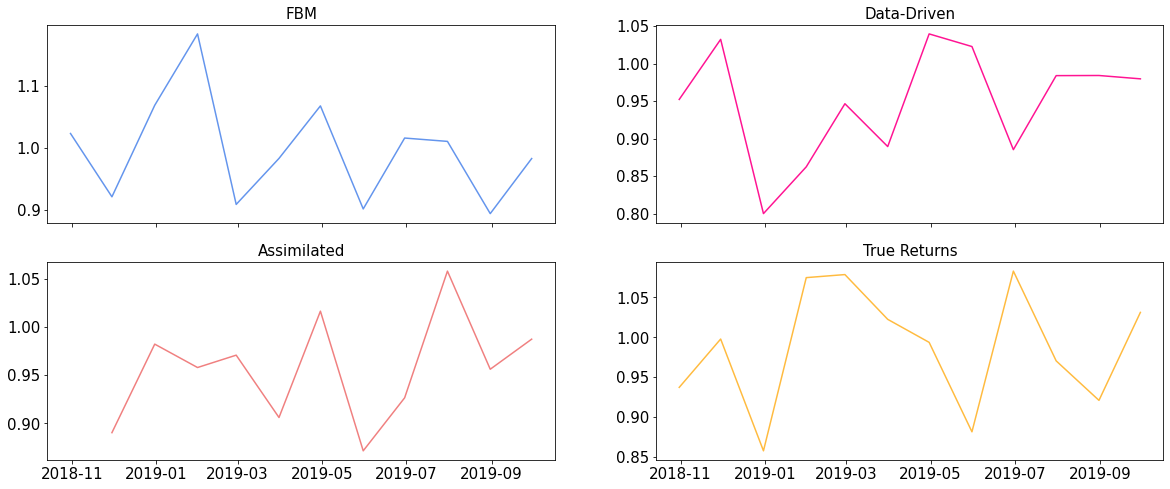

In [311]:
fig, ax = plt.subplots(2, 2, sharex = True, sharey = False, figsize=(20,8))

ax[0,0].plot(FBM_monthly_returns.loc['10-2018':'9-2019'], label = 'FBM', color = 'cornflowerblue')
ax[0,0].set_title('FBM', size=15)
ax[0,0].tick_params(labelsize = 15)

ax[1,0].plot(Data_Driven_assimilated_results, label = 'Assimilated', color = 'lightcoral')
ax[1,0].set_title('Assimilated', size=15)
ax[1,0].tick_params(labelsize = 15)

ax[0,1].plot(test, label ='Data-Driven', color = 'deeppink')
ax[0,1].set_title('Data-Driven', size=15)
ax[0,1].tick_params(labelsize = 15)

ax[1,1].plot(XOM_returns_m.loc['10-2018':'9-2019'], label = 'True Returns', color = 'orange', alpha = 0.75)
ax[1,1].set_title('True Returns', size=15)
ax[1,1].tick_params(labelsize = 15)

#plt.savefig('Comparison of XOM Daily Returns, Simulated Returns & OI.png')

plt.show()

In [312]:
#Comparing the MSE between the data-driven, FBM, Assimilated with the Actual Returns

x = mean_squared_error(XOM_returns_m.loc['10-2018':'9-2019'].values, test)
y = mean_squared_error(XOM_returns_m.loc['10-2018':'9-2019'].values, FBM_monthly_returns.loc['10-2018':'9-2019'])
z = mean_squared_error(XOM_returns_m.loc['11-2018':'9-2019'].values, Data_Driven_assimilated_results)

print(f'The MSE between the Data-Driven Predictions and the Actual Returns is: {x}')
print(f'The MSE between the FBM Predictions and the Actual Returns is: {y}')
print(f'The MSE between the Assimilated Predictions and the Actual Returns is: {z}')

def compare_mse(x , y , z):
    # x : data-driven, y : FBM, z : Assimilated

    if z < y and z < x:
        return 'Yes' 
    else:
        return 'No'

def compute_percentage_improvement(x, y, z):
    # x : data-driven, y : FBM, z : Assimilated

    a = (z/x - 1) * - 1
    b = (z/y - 1) * - 1  

    return (a,b)
    
print(f'Do the assimilated results have a lower MSE than either the FBM or data-driven results: {compare_mse(x, y, z)}')
print(f'Improvement over the FBM simulation: {compute_percentage_improvement(x, y, z)[0]:.0%} & improvement over data-driven forecasts: {compute_percentage_improvement(x, y, z)[1]:.0%}')


The MSE between the Data-Driven Predictions and the Actual Returns is: 0.012726451587752525
The MSE between the FBM Predictions and the Actual Returns is: 0.009556214404256266
The MSE between the Assimilated Predictions and the Actual Returns is: 0.009250256381412887
Do the assimilated results have a lower MSE than either the FBM or data-driven results: Yes
Improvement over the FBM simulation: 27% & improvement over data-driven forecasts: 3%


# Investigating the distribution of the simulations and predictions

In [313]:
def compute_moments(returns):

    mean = np.mean(returns)
    var = np.var(returns)
    std = returns.std()
    min = returns.min()
    max = returns.max()
    x = np.linspace(min, max, len(returns))
    P = scipy.stats.norm.pdf(x, mean, std)

    skew = scipy.stats.skew(returns)
    kurtosis = scipy.stats.kurtosis(returns)

    #print(f"Mean: {mean:.4f}, Variance: {var:.4f}, Standard Deviation: {std:.4f}, Skewness: {skew:.4f}, Kurtosis: {kurtosis:.4f}")

    return mean, var, std, P, skew, kurtosis, x

In [314]:
XOM_returns

,Daily Returns
Dates,
1999-04-06,NaN
1999-04-07,0.006879
1999-04-08,0.014516
1999-04-09,0.005894
1999-04-12,0.010042
...,...
2021-04-29,0.014283
2021-04-30,-0.028843
2021-05-03,0.027603


In [315]:

True_returns_mean = np.mean(XOM_returns)
True_returns_var = np.var(XOM_returns)
True_returns_std = XOM_returns.std()
min = XOM_returns.min()
max = XOM_returns.max()
x = np.linspace(min, max, len(XOM_returns))
True_p = scipy.stats.norm.pdf(x, True_returns_mean, True_returns_std)

True_returns_skew = scipy.stats.skew(XOM_returns)
True_returns_kurtosis = scipy.stats.kurtosis(XOM_returns)
#print(f"True Return Mean: {True_returns_mean:.4f}, True Return Variance: {True_returns_var:.4f}, True Return Standard Deviation: {True_returns_std:.4f},  True Return Skewness: {True_returns_skew:.4f}, True Return Kurtosis: {True_returns_kurtosis:.4f}")
print('\n')

#FBM_mean_returns = FBM_mean_returns+1
FBM_returns_mean = np.mean(FBM_mean_returns)
FBM_returns_var = np.var(FBM_mean_returns)
FBM_returns_std = FBM_mean_returns.std()
FBM_min = np.min(FBM_mean_returns)
FBM_max = np.max(FBM_mean_returns)
FBM_x = np.linspace(FBM_min, FBM_max, len(FBM_mean_returns))
FBM_p = scipy.stats.norm.pdf(FBM_x, FBM_returns_mean, FBM_returns_std)

FBM_returns_skew = scipy.stats.skew(FBM_mean_returns)
FBM_returns_kurtosis = scipy.stats.kurtosis(FBM_mean_returns)
print(f"FBM Return Mean: {FBM_returns_mean:.4f}, FBM Return Variance: {FBM_returns_var:.4f}, FBM Return Standard Deviation: {FBM_returns_std:.4f}, FBM Return Skewness: {FBM_returns_skew:.4f}, FBM Return Kurtosis: {FBM_returns_kurtosis:.4f}")
print('\n')

#MRW_mean_returns = MRW_mean_returns + 1
MRW_returns_mean = np.mean(MRW_mean_returns)
MRW_returns_var = np.var(MRW_mean_returns)
MRW_returns_std = MRW_mean_returns.std()
MRW_min = np.min(MRW_mean_returns)
MRW_max = np.max(MRW_mean_returns)
MRW_x = np.linspace(MRW_min, MRW_max, len(MRW_mean_returns))
MRW_p = scipy.stats.norm.pdf(MRW_x, MRW_returns_mean, MRW_returns_std)

MRW_returns_skew = scipy.stats.skew(MRW_mean_returns)
MRW_returns_kurtosis = scipy.stats.kurtosis(MRW_mean_returns)
print(f"MRW Return Mean: {MRW_returns_mean:.4f}, MRW Return Variance: {MRW_returns_var:.4f}, MRW Return Standard Deviation: {MRW_returns_std:.4f}, MRW Return Skewness: {MRW_returns_skew:.4f}, MRW Return Kurtosis: {MRW_returns_kurtosis:.4f}")
print('\n')



FBM Return Mean: -0.0000, FBM Return Variance: 0.0010, FBM Return Standard Deviation: 0.0321, FBM Return Skewness: -0.0001, FBM Return Kurtosis: -0.1590


MRW Return Mean: 0.0000, MRW Return Variance: 0.0010, MRW Return Standard Deviation: 0.0314, MRW Return Skewness: 0.0102, MRW Return Kurtosis: -0.0241




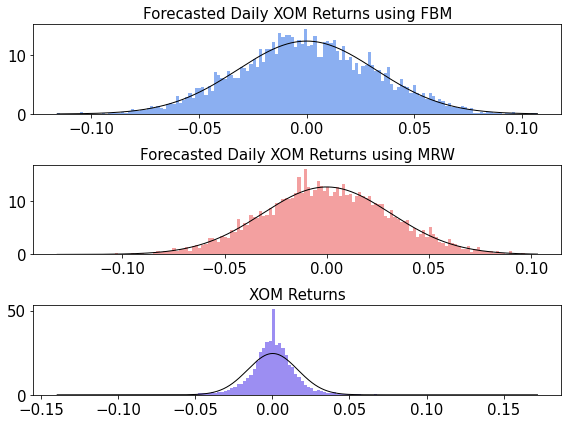

In [316]:
fig, ax = plt.subplots(3, 1, sharex = False, sharey = False, figsize=(8,6))

ax[0].hist(FBM_mean_returns, bins = 150, color = 'cornflowerblue', alpha = 0.75, label = 'Forecast - FBM', density=True)
ax[0].plot(FBM_x, FBM_p, 'k', linewidth = 1)
ax[0].set_title('Forecasted Daily XOM Returns using FBM', size=15)
ax[0].tick_params(labelsize = 15)

ax[1].hist(MRW_mean_returns, bins = 150, color = 'lightcoral', alpha = 0.75, label = 'Forecast - MRW', density=True)
ax[1].plot(MRW_x, MRW_p, 'k', linewidth = 1)
ax[1].set_title('Forecasted Daily XOM Returns using MRW', size=15)
ax[1].tick_params(labelsize = 15)

ax[2].hist(XOM_returns.values, bins = 150, color = 'mediumslateblue',alpha = 0.75,  label = 'True Returns', density=True)
ax[2].plot(x, True_p, 'k', linewidth = 1)
ax[2].set_title('XOM Returns', size=15)
ax[2].tick_params(labelsize = 15)

plt.tight_layout()

# Keras Seq2Seq model

In [317]:
break

SyntaxError: ignored

In [ ]:
print(scaled_Monthly_AAPL_data.shape)
scaled_Monthly_AAPL_data.head()

In [ ]:
filtered_weekly_data.head()

In [ ]:
filtered_monthly_data.head()

In [ ]:
past_sequences = 24
prediction_horizon = 12

X_train, Y_train = helper_funcs.create_datasets(past_sequences, prediction_horizon, Monthly_AAPL_returns, 'AAPL', filtered_monthly_data, multi_step = True)
Y_train = Y_train.reshape(-1, prediction_horizon, 1)
print(Y_train.shape)
X_test, Y_test = X_train[int(-1/5 * len(X_train)):], Y_train[int(-1/5 * len(Y_train)):]
X_train, Y_train = X_train[:int(4/5 * len(X_train))], Y_train[:int(4/5 * len(Y_train))]

In [ ]:
print(f'Shape of X train: {X_train.shape}, Shape of Y train: {Y_train.shape}')
print(f'Shape of X test: {X_test.shape}, Shape of Y test: {Y_test.shape}')

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(Y_train[-1, :, :], label = 'True Monthly Returns')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.plot()

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from keras.optimizers import Adam
#from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import pydot as pyd
from keras.utils.vis_utils import plot_model, model_to_dot
keras.utils.vis_utils.pydot = pyd

In [ ]:
n_hidden = 512

input_train = Input(shape=(X_train.shape[1], X_train.shape[2]))
output_train = Input(shape=(Y_train.shape[1], Y_train.shape[2]))

print(input_train.shape)
print(output_train.shape)

print(type(X_train))
print(type(input_train))

In [ ]:
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_state=True, return_sequences=True)(input_train)

print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

In [ ]:
encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

In [ ]:
decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
print(decoder_input)

In [ ]:
decoder_stack_h = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
 return_state=False, return_sequences=True)(
 decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)

In [ ]:
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)
print(attention)

In [ ]:
context = dot([attention, encoder_stack_h], axes=[2,1])
context = BatchNormalization(momentum=0.6)(context)
print(context)

In [ ]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

In [ ]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
print(out)

In [ ]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(learning_rate=1e-4, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse'])
model.summary()

In [ ]:
epc = 1000
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_train[:, :, :], Y_train[:, :, :], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=50)

train_mse = history.history['mse']
valid_mse = history.history['val_mse']
 
model.save('model_forecasting_seq2seq.h5')

In [ ]:
plt.figure(figsize = (12,5))
plt.plot(train_mae, label='train mse'),
plt.plot(valid_mae, label='validation mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mse)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [ ]:
train_pred = model.predict(X_train[:, :, :])
test_pred = model.predict(X_test[:, :, :])
print(f'Train prediction shape: {train_pred.shape}, Test prediction shape: {test_pred.shape}')

train_true = Y_train[:, :, :]
test_true = Y_test[:, :, :]
print(f'Train data shape: {train_true.shape}, Test data shape: {test_true.shape}')

In [ ]:
print(train_pred[-1, :, :].shape)

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_pred[-1, :, :], label = 'Train pred')
plt.plot(train_true[-1, :, :], label = 'Train True')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.plot()

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test_pred[-1, :, :], label = 'Test pred')
plt.plot(test_true[-1, :, :], label = 'Test True')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.plot()

In [ ]:
break

In [ ]:
t = 4
t_target = 2

inputs = []
outputs = []

for i in range(len(scaled_Monthly_AAPL_data) - t - t_target - 1):
    b = scaled_Monthly_AAPL_data[i:i + t]
    #print(b.shape)
    inputs.append(b)
    #print(f'Input to the model :\n {scaled_AAPL_returns[i:i + t]}')
    #print('\n')
    #print(f'Entire sequence: \n {Monthly_AAPL_returns[i:i + t + t_target]}')
    #print('\n')
    l = Monthly_AAPL_returns[i+t:i+t + t_target]
    #print(l.shape)
    outputs.append(l)
    #print(f'Target :\n {Monthly_AAPL_returns[i+t:i+t + t_target]}')


In [ ]:
inputs[2]

In [ ]:
np_inputs = np.array(inputs)
print(np_inputs.shape)


In [ ]:
reshape_inp = np_inputs.reshape(-1, t, len(scaled_Monthly_AAPL_data.T))
print(reshape_inp.shape)

In [ ]:
np_outputs = np.array(outputs)
print(np_outputs.shape)

In [ ]:
reshape_targets = np_outputs.reshape(-1, t_target)
print(reshape_targets.shape)
reshape_targets[-1]

In [ ]:
scaled_Monthly_AAPL_data.head()

In [ ]:
xyz = pd.DataFrame(Monthly_AAPL_returns)
xyz.head()

In [ ]:
T = 6
T_target = 3

D = len(scaled_Monthly_AAPL_data.T)
X_obs = []
Y_obs = []
Target_obs = xyz

for i in range(len(scaled_Monthly_AAPL_data) - T - T_target - 1):

    x = scaled_Monthly_AAPL_data[i : (i + T)]
    X_obs.append(x)

    l = xyz[(i+T) : (i + T + T_target)]
    Y_obs.append(l)

X_obs = np.array(X_obs)
Y_obs = np.array(Y_obs)
print(f'X shape : {X_obs.shape}')
print(f'Y shape : {Y_obs.shape}')

X_obs = X_obs.reshape(-1, T, D)
Y_obs = Y_obs.reshape(-1, T_target)

print('Shape of X:', X_obs.shape, 'Shape of Y:', Y_obs.shape)